## CS5488 Project - Price Prediction on Cryptocurrencies
### Project Group 5
<!--
Poon Bing-chun
Jia Shuyue
Li Ka-faat
Tso Yiu-chuen
-->

#### Objective
In this project, we attempt to predict the exchange rates of cryptocurrencies using historical prices of other cryptocurrencies, by training a deep neural network distributedly across several machines.

Distributed training is a collection of techniques for using multiple processors located on different machines for training machine learning models. It is an increasingly important deep learning technique, since it enables the training of wider neural networks which is too cumbersome to manage on one machine only.

#### Plan
The [**Horovod** library](https://github.com/horovod/horovod) ([paper](https://towardsdatascience.com/paper-summary-horovod-fast-and-easy-distributed-deep-learning-in-tensorflow-5be535c748d1)) will be used and the training machines will be grouped by an [**Apache Spark** cluster](https://horovod.readthedocs.io/en/stable/spark_include.html) (which will be covered in the last few weeks of the lecture). Horovod distributes training batches to machines for training, averages the gradients of gradient descents, and aggregates the validation metrics returned by each machine. It supports common deep learning frameworks like **Keras**, **TensorFlow** and **PyTorch**.

We will compare the convergence rates with and without distributed training using TensorBoard.

In [1]:
import pandas as pd
from urllib.request import urlopen as u

#### Data Collection

We have written a Python script [**downloadData_5m.py**](https://github.com/verybighub/CS5488_Project/blob/main/downloadData_5m.py) to collect historical cryptocurrency finance data from [https://coinmarketcap.com/](https://coinmarketcap.com/). The date range is 1st January, 2019 to 22nd September, 2021 (i.e. the day we collected the data). We have parsed the data into the machine-readable `pandas` `DataFrame` format and placed it in Google Drive.

In [2]:
from requests import Session

def download_from_google_drive(id):
    URL = "https://docs.google.com/uc?export=download"

    session = Session()

    response = session.get(URL, params = {'id': id }, stream = True)
    token = get_confirm_token(response)

    if token:
        params = {'id': id, 'confirm': token }
        response = session.get(URL, params = params, stream = True)

    save_response_content(response)    

def get_confirm_token(response):
    for key, value in response.cookies.items():
        if key.startswith('download_warning'):
            return value

    return None

def save_response_content(response):
    CHUNK_SIZE = 32768

    with open('historical_coin_data_5m.json', "wb") as f:
        for chunk in response.iter_content(CHUNK_SIZE):
            if chunk: # filter out keep-alive new chunks
                f.write(chunk)

download_from_google_drive('1gkXRtX1BfeC3uxYb6WxGTn2fN5U8S1OZ')

In [2]:
df = pd.read_json('historical_coin_data_5m.json')

In [4]:
df

Currency            DateTime    Price USD  \
0                 Litecoin 2019-01-01 08:04:00    31.133169   
1                  Bitcoin 2019-01-01 08:04:01  3804.417038   
2                      XRP 2019-01-01 08:04:01     0.360121   
3                 Dogecoin 2019-01-01 08:04:02     0.002367   
4                  Stellar 2019-01-01 08:04:04     0.114630   
...                    ...                 ...          ...   
5124733  Internet Computer 2021-09-22 05:49:10    48.568079   
5124734  Internet Computer 2021-09-22 05:49:12    48.568079   
5124735            VeChain 2021-09-22 05:54:14     0.096595   
5124736            VeChain 2021-09-22 05:54:16     0.096595   
5124737            VeChain 2021-09-22 05:54:17     0.096595   

         Trading Volume Last 24h    Market Cap     Price BTC  DunnoWhatThisIs  
0                   3.800241e+08  1.862125e+09  8.183427e-03     4.894641e+05  
1                   4.637869e+09  6.640638e+10  1.000000e+00     1.745508e+07  
2                   5.027181e+08  1.469083e+10  9.465870e-05     3.861520e+06  
3                   1.779630e+07  2.784091e+08  6.221000e-07     7.318046e+04  
4                   9.050305e+07  2.196406e+09  3.013080e-05     5.773304e+05  
...                          ...           ...           ...              ...  
5124733             3.332303e+08  7.911265e+09  1.121945e-03     1.827539e+05  
5124734             3.332303e+08  7.911265e+09  1.121945e-03     1.827539e+05  
5124735             5.599202e+08  6.212570e+09  2.231800e-06     1.435412e+05  
5124736             5.599202e+08  6.212570e+09  2.231800e-06     1.435412e+05  
5124737             5.599202e+08  6.212570e+09  2.231800e-06     1.435412e+05  

[5124738 rows x 7 columns]

In [38]:
import numpy as np

currency = 'Dogecoin'
price = df[df['Currency'] == currency]['Price USD'][::12]#.pct_change()
vol =  df[df['Currency'] == currency]['Trading Volume Last 24h'][::12]#.pct_change()
marketcap =  df[df['Currency'] == currency]['Market Cap'][::12]#.pct_change()

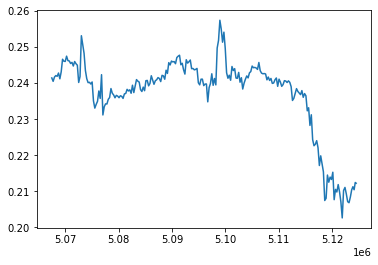

In [942]:
plt.plot(price[-228:])

In [39]:
feats=np.dstack([np.log(price[1:] + 1),np.log(vol[1:] + 1),np.log(marketcap[1:] + 1)])[0,:,:]
#feats=np.dstack([np.log(price[1:] + 1)])[0,:,:]

print(feats.shape)

from sklearn.preprocessing import RobustScaler, MinMaxScaler

scaler = RobustScaler()
scaler2 = MinMaxScaler()

feats_scaled = scaler2.fit_transform(scaler.fit_transform(feats))
print(feats_scaled)

(23906, 3)
[[0.00168695 0.05286699 0.07061557]
 [0.00167435 0.0539078  0.07015104]
 [0.00168624 0.05442583 0.07058955]
 ...
 [0.3464706  0.59223302 0.80366707]
 [0.34951051 0.59012483 0.80518738]
 [0.34919753 0.58019958 0.80503141]]


In [800]:
feats

array([[1.08249941e-06, 1.54902547e+01, 1.92454018e+01],
       [1.07789942e-06, 1.55031485e+01, 1.92392447e+01],
       [1.08079942e-06, 1.55054702e+01, 1.92432963e+01],
       ...,
       [2.22559752e-06, 2.03245865e+01, 2.25504349e+01],
       [2.23139751e-06, 2.02356795e+01, 2.25468678e+01],
       [2.23059751e-06, 2.01554806e+01, 2.25481336e+01]])

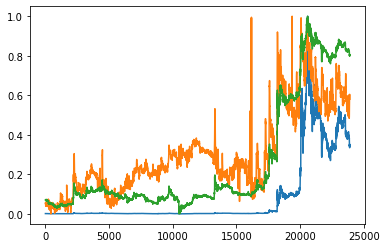

In [40]:
plt.plot(feats_scaled)

In [41]:
# size: 24 * 7 => weekly
sliding_window = np.lib.stride_tricks.sliding_window_view(feats_scaled, (4*7*10,3), axis=(0,1))
sliding_window = sliding_window.reshape((sliding_window.shape[0], sliding_window.shape[2], sliding_window.shape[3]))
Xs = np.array([i[:-3] for i in sliding_window])
Ys = np.array([i[-3:,0] for i in sliding_window])

print(np.array([i[-3:] for i in sliding_window]))
print('-----------------------')
print(np.array([i[-3:,0] for i in sliding_window]))
print(Xs.shape)
print(Ys.shape)

[[[0.0012448  0.04311266 0.05365496]
  [0.0012409  0.04114392 0.05349476]
  [0.0012449  0.03900421 0.05365894]]

 [[0.0012409  0.04114392 0.05349476]
  [0.0012449  0.03900421 0.05365894]
  [0.00125316 0.03525721 0.0539972 ]]

 [[0.0012449  0.03900421 0.05365894]
  [0.00125316 0.03525721 0.0539972 ]
  [0.00124333 0.03322072 0.05359458]]

 ...

 [[0.34644113 0.59356427 0.80365227]
  [0.3477278  0.5923881  0.80429727]
  [0.3464706  0.59223302 0.80366707]]

 [[0.3477278  0.5923881  0.80429727]
  [0.3464706  0.59223302 0.80366707]
  [0.34951051 0.59012483 0.80518738]]

 [[0.3464706  0.59223302 0.80366707]
  [0.34951051 0.59012483 0.80518738]
  [0.34919753 0.58019958 0.80503141]]]
-----------------------
[[0.0012448  0.0012409  0.0012449 ]
 [0.0012409  0.0012449  0.00125316]
 [0.0012449  0.00125316 0.00124333]
 ...
 [0.34644113 0.3477278  0.3464706 ]
 [0.3477278  0.3464706  0.34951051]
 [0.3464706  0.34951051 0.34919753]]
(23627, 277, 3)
(23627, 3)


In [ ]:
# size: 24 * 7 => weekly
sliding_window = np.lib.stride_tricks.sliding_window_view(feats_scaled, (4*7*10,3), axis=(0,1))
sliding_window = sliding_window.reshape((sliding_window.shape[0], sliding_window.shape[2], sliding_window.shape[3]))
Xs = np.array([i[:-3] for i in sliding_window])
Ys = np.array([i[-3:][0] for i in sliding_window])

# print(sliding_window)
# print(sliding_window.shape)
print(Xs.shape)
print(Ys.shape)
print(Xs)
print(Ys)

In [869]:
# size: 24 * 7 => weekly
sliding_window = np.lib.stride_tricks.sliding_window_view(feats_scaled, (4*7*10,1), axis=(0,1))
sliding_window = sliding_window.reshape((sliding_window.shape[0], sliding_window.shape[2], sliding_window.shape[3]))
Xs = np.array([i[:-1] for i in sliding_window])
Ys = np.array([i[-1][0] for i in sliding_window])

# print(sliding_window)
# print(sliding_window.shape)
print(Xs.shape)
print(Ys.shape)
print(Xs)
print(Ys)

(23627, 279, 1)
(23627,)
[[[0.01057149]
  [0.01046204]
  [0.01053399]
  ...
  [0.01034858]
  [0.01039092]
  [0.01037302]]

 [[0.01046204]
  [0.01053399]
  [0.01003348]
  ...
  [0.01039092]
  [0.01037302]
  [0.01018796]]

 [[0.01053399]
  [0.01003348]
  [0.00995232]
  ...
  [0.01037302]
  [0.01018796]
  [0.01013945]]

 ...

 [[0.48591059]
  [0.49360211]
  [0.49160713]
  ...
  [0.39246657]
  [0.39049532]
  [0.39207456]]

 [[0.49360211]
  [0.49160713]
  [0.4927809 ]
  ...
  [0.39049532]
  [0.39207456]
  [0.39424628]]

 [[0.49160713]
  [0.4927809 ]
  [0.50044844]
  ...
  [0.39207456]
  [0.39424628]
  [0.39288023]]]
[0.01018796 0.01013945 0.01012561 ... 0.39424628 0.39288023 0.39336448]


In [7]:
'''
from sklearn.decomposition import PCA

pca = PCA(n_components=10)
pca.fit_transform(Xs)
'''

'\nfrom sklearn.decomposition import PCA\n\npca = PCA(n_components=10)\npca.fit_transform(Xs)\n'


***********************************
-----------------------

In [631]:
print(np.array(hourly_price).reshape(-1,1))

from sklearn.preprocessing import RobustScaler, MinMaxScaler

scaler = RobustScaler()
scaler2 = MinMaxScaler()

hourly_price_scaled = scaler2.fit_transform(scaler.fit_transform(np.array(hourly_price).reshape(-1,1)))

hourly_price = hourly_price_scaled.ravel()

[[        nan]
 [-0.01824408]
 [-0.00311219]
 ...
 [ 0.00768207]
 [-0.00493738]
 [ 0.00299013]]


In [647]:
# size: 24 * 7 => weekly
sliding_window = np.lib.stride_tricks.sliding_window_view(hourly_price, 4*7*10)
Xs = np.array([i[:-1] for i in sliding_window])
Ys = np.array([i[-1] for i in sliding_window])

print(sliding_window)
print(hourly_price.shape)
print(sliding_window.shape)
print(Xs.shape)
print(Ys.shape)
print(Xs)
print(Ys)

[[       nan 0.66602417 0.68821085 ... 0.69729012 0.69810545 0.69859675]
 [0.66602417 0.68821085 0.69341289 ... 0.69810545 0.69859675 0.69083188]
 [0.68821085 0.69341289 0.70636605 ... 0.69859675 0.69083188 0.69409936]
 ...
 [0.72158176 0.70346081 0.68006989 ... 0.67280827 0.70824113 0.7040376 ]
 [0.70346081 0.68006989 0.70146132 ... 0.70824113 0.7040376  0.68553471]
 [0.68006989 0.70146132 0.68445945 ... 0.7040376  0.68553471 0.69715817]]
(5977,)
(5698, 280)
(5698, 279)
(5698,)
[[       nan 0.66602417 0.68821085 ... 0.6768964  0.69729012 0.69810545]
 [0.66602417 0.68821085 0.69341289 ... 0.69729012 0.69810545 0.69859675]
 [0.68821085 0.69341289 0.70636605 ... 0.69810545 0.69859675 0.69083188]
 ...
 [0.72158176 0.70346081 0.68006989 ... 0.65532171 0.67280827 0.70824113]
 [0.70346081 0.68006989 0.70146132 ... 0.67280827 0.70824113 0.7040376 ]
 [0.68006989 0.70146132 0.68445945 ... 0.70824113 0.7040376  0.68553471]]
[0.69859675 0.69083188 0.69409936 ... 0.7040376  0.68553471 0.69715817]


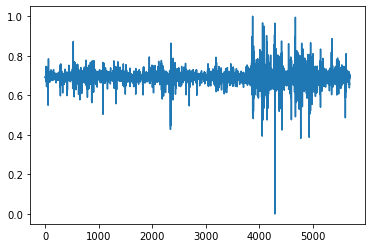

In [574]:
plt.plot(Ys)

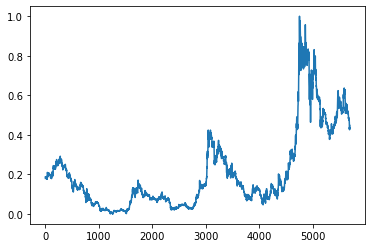

In [756]:
plt.plot(Ys)

In [117]:
Ys

array([0.63271675, 0.63248566, 0.63075295, ..., 0.64217399, 0.65233127,
       0.64980418])

# Data splitting
We will use the holdout method. The split percentages are 60% for training, 20% for verification, and 20% for validation.

In [60]:
TrainLen = int(len(Xs) * 0.92)
ValLen = int(len(Xs) * 0.96)
TestLen = len(Xs) - TrainLen

x_train = Xs[0:TrainLen,:]
y_train = Ys[0:TrainLen]

x_val = Xs[TrainLen:ValLen,:]
y_val = Ys[TrainLen:ValLen]

x_test = Xs[ValLen:,:]
y_test = Ys[ValLen:]

# y_train = y_train.reshape((y_train.shape[0],y_train.shape[1],1))
# y_val = y_val.reshape((y_val.shape[0],y_val.shape[1],1))
# y_test = y_test.reshape((y_test.shape[0],y_test.shape[1],1))

In [61]:
print(x_train.shape)
print(x_val.shape)
print(x_test.shape)

print(y_train.shape)
print(y_val.shape)
print(y_test.shape)

(21736, 277, 3)
(945, 277, 3)
(946, 277, 3)
(21736, 3)
(945, 3)
(946, 3)


In [52]:
y_val.reshape((y_val.shape[0],y_val.shape[1],1))

array([[[0.40626015],
        [0.403831  ],
        [0.40539117]],

       [[0.403831  ],
        [0.40539117],
        [0.39985331]],

       [[0.40539117],
        [0.39985331],
        [0.40011788]],

       ...,

       [[0.43089189],
        [0.44005676],
        [0.43433159]],

       [[0.44005676],
        [0.43433159],
        [0.43494534]],

       [[0.43433159],
        [0.43494534],
        [0.43529758]]])

In [11]:
import pandas as pd
import matplotlib.pyplot as plt

import numpy as np
from sklearn.preprocessing import MinMaxScaler

from tensorflow.keras import backend as K
#from tensorflow.keras.models import Sequential
#import tensorflow as tf
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Dropout

In [749]:
x_train=x_train.reshape(x_train.shape[0],x_train.shape[1],1)
print(x_train.shape)
x_val=x_val.reshape(x_val.shape[0],x_val.shape[1],1)
print(x_val.shape)
x_test=x_test.reshape(x_test.shape[0],x_test.shape[1],1)
print(x_test.shape)

ValueError: cannot reshape array of size 4386717 into shape (5241,279,1)

In [62]:
optimizer = keras.optimizers.Adadelta()

model = Sequential()
model.add(LSTM(12, dropout=0.05, return_sequences=True))
model.add(LSTM(4, dropout=0.05))
model.add(Dense(3, activation='sigmoid'))

model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_squared_error'])


model.fit(x_train, y_train, callbacks=[], epochs=500, verbose=2, validation_data=(x_val, y_val))

Epoch 1/500
680/680 - 54s - loss: 0.0308 - mean_squared_error: 0.0308 - val_loss: 0.0114 - val_mean_squared_error: 0.0114
Epoch 2/500
680/680 - 51s - loss: 0.0026 - mean_squared_error: 0.0026 - val_loss: 2.8104e-04 - val_mean_squared_error: 2.8104e-04
Epoch 3/500
680/680 - 51s - loss: 9.7551e-04 - mean_squared_error: 9.7551e-04 - val_loss: 3.9434e-04 - val_mean_squared_error: 3.9434e-04
Epoch 4/500
680/680 - 51s - loss: 5.7702e-04 - mean_squared_error: 5.7702e-04 - val_loss: 6.0223e-04 - val_mean_squared_error: 6.0223e-04
Epoch 5/500
680/680 - 51s - loss: 4.1904e-04 - mean_squared_error: 4.1904e-04 - val_loss: 1.9585e-04 - val_mean_squared_error: 1.9585e-04
Epoch 6/500
680/680 - 53s - loss: 3.3902e-04 - mean_squared_error: 3.3902e-04 - val_loss: 2.1339e-04 - val_mean_squared_error: 2.1339e-04
Epoch 7/500
680/680 - 51s - loss: 2.9921e-04 - mean_squared_error: 2.9921e-04 - val_loss: 4.8569e-04 - val_mean_squared_error: 4.8569e-04
Epoch 8/500
680/680 - 51s - loss: 2.6474e-04 - mean_square

KeyboardInterrupt: 

In [44]:
from time import time

optimizer = keras.optimizers.Adadelta()

model = Sequential()
model.add(LSTM(12, dropout=0.05, return_sequences=True))
model.add(LSTM(4, dropout=0.05))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_squared_error'])

time0 = time()
model.fit(x_train, y_train, callbacks=[], epochs=500, verbose=2, validation_data=(x_val, y_val))
# TODO: Early stop
# Interrupt callback blow:
print(time() - time0)

# Also, measure the time needed for each epoch.

Epoch 1/500
680/680 - 62s - loss: 0.0223 - mean_squared_error: 0.0223 - val_loss: 0.0077 - val_mean_squared_error: 0.0077
Epoch 2/500
680/680 - 60s - loss: 0.0017 - mean_squared_error: 0.0017 - val_loss: 0.0133 - val_mean_squared_error: 0.0133
Epoch 3/500
680/680 - 60s - loss: 8.0726e-04 - mean_squared_error: 8.0726e-04 - val_loss: 0.0024 - val_mean_squared_error: 0.0024
Epoch 4/500
680/680 - 60s - loss: 5.3179e-04 - mean_squared_error: 5.3179e-04 - val_loss: 5.5830e-04 - val_mean_squared_error: 5.5830e-04
Epoch 5/500
680/680 - 61s - loss: 3.9861e-04 - mean_squared_error: 3.9861e-04 - val_loss: 2.4615e-04 - val_mean_squared_error: 2.4615e-04
Epoch 6/500
680/680 - 60s - loss: 3.5103e-04 - mean_squared_error: 3.5103e-04 - val_loss: 3.4275e-04 - val_mean_squared_error: 3.4275e-04
Epoch 7/500
680/680 - 60s - loss: 2.9308e-04 - mean_squared_error: 2.9308e-04 - val_loss: 1.9621e-04 - val_mean_squared_error: 1.9621e-04
Epoch 8/500
680/680 - 60s - loss: 2.7907e-04 - mean_squared_error: 2.7907e

KeyboardInterrupt: 

In [63]:
model.save('checkpoint')

INFO:tensorflow:Assets written to: checkpoint\assets


INFO:tensorflow:Assets written to: checkpoint\assets


In [948]:
from time import time

optimizer = keras.optimizers.Adadelta()

model = Sequential()
model.add(LSTM(12, dropout=0.05, return_sequences=True))
model.add(LSTM(4, dropout=0.05))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_squared_error'])

time0 = time()
model.fit(x_train, y_train, callbacks=[], epochs=500, verbose=2, validation_data=(x_val, y_val))
# TODO: Early stop
# Interrupt callback blow:
print(time() - time0)

# Also, measure the time needed for each epoch.

Epoch 1/500
680/680 - 55s - loss: 0.0180 - mean_squared_error: 0.0180 - val_loss: 0.0016 - val_mean_squared_error: 0.0016
Epoch 2/500
680/680 - 52s - loss: 0.0012 - mean_squared_error: 0.0012 - val_loss: 1.5570e-04 - val_mean_squared_error: 1.5570e-04
Epoch 3/500
680/680 - 53s - loss: 5.9678e-04 - mean_squared_error: 5.9678e-04 - val_loss: 3.4136e-04 - val_mean_squared_error: 3.4136e-04
Epoch 4/500
680/680 - 55s - loss: 4.1002e-04 - mean_squared_error: 4.1002e-04 - val_loss: 1.8168e-04 - val_mean_squared_error: 1.8168e-04
Epoch 5/500
680/680 - 61s - loss: 3.0787e-04 - mean_squared_error: 3.0787e-04 - val_loss: 1.7846e-04 - val_mean_squared_error: 1.7846e-04
Epoch 6/500
680/680 - 62s - loss: 2.6374e-04 - mean_squared_error: 2.6374e-04 - val_loss: 1.1377e-04 - val_mean_squared_error: 1.1377e-04
Epoch 7/500
680/680 - 61s - loss: 2.4866e-04 - mean_squared_error: 2.4866e-04 - val_loss: 3.5099e-04 - val_mean_squared_error: 3.5099e-04
Epoch 8/500
680/680 - 61s - loss: 2.2134e-04 - mean_square

KeyboardInterrupt: 

In [841]:
#optimizer = keras.optimizers.Adadelta()

model = Sequential()
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_squared_error'])


model.fit(x_train, y_train, batch_size=4, callbacks=[], epochs=200, verbose=2, validation_data=(x_val, y_val))

Epoch 1/200
5434/5434 - 12s - loss: 0.0031 - mean_squared_error: 0.0031 - val_loss: 0.0040 - val_mean_squared_error: 0.0040
Epoch 2/200
5434/5434 - 11s - loss: 0.0021 - mean_squared_error: 0.0021 - val_loss: 0.0071 - val_mean_squared_error: 0.0071
Epoch 3/200
5434/5434 - 12s - loss: 0.0021 - mean_squared_error: 0.0021 - val_loss: 0.0076 - val_mean_squared_error: 0.0076
Epoch 4/200
5434/5434 - 12s - loss: 0.0020 - mean_squared_error: 0.0020 - val_loss: 0.0056 - val_mean_squared_error: 0.0056
Epoch 5/200
5434/5434 - 12s - loss: 0.0020 - mean_squared_error: 0.0020 - val_loss: 0.0055 - val_mean_squared_error: 0.0055
Epoch 6/200
5434/5434 - 12s - loss: 0.0020 - mean_squared_error: 0.0020 - val_loss: 0.0037 - val_mean_squared_error: 0.0037
Epoch 7/200
5434/5434 - 12s - loss: 0.0020 - mean_squared_error: 0.0020 - val_loss: 0.0081 - val_mean_squared_error: 0.0081
Epoch 8/200
5434/5434 - 12s - loss: 0.0020 - mean_squared_error: 0.0020 - val_loss: 0.0037 - val_mean_squared_error: 0.0037
Epoch 9/

KeyboardInterrupt: 

In [ ]:
i = model.predict(x_test)
predicted = np.ravel(i)

print(predicted)
print(y_test)
'''
for x_test:
    model.predict()
'''

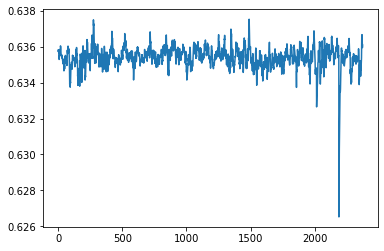

In [152]:
plt.plot(predicted)

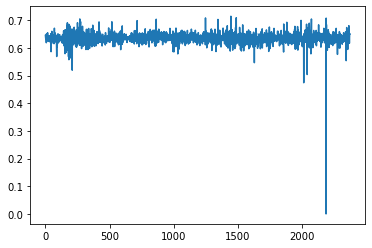

In [145]:
plt.plot(y_test)

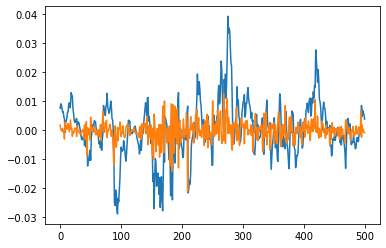

In [168]:
plt.plot((scaler.inverse_transform(i).ravel()*20)[0:500])
plt.plot(scaler.inverse_transform(y_test.reshape(-1, 1))[0:500])

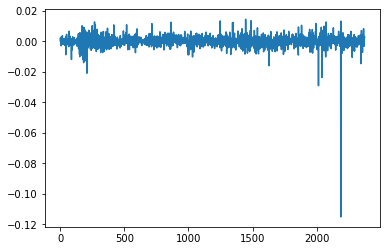

In [160]:
plt.plot(scaler.inverse_transform(y_test.reshape(-1, 1)))

In [49]:
x_train.shape

(18988, 167)

In [64]:
i = model.predict(x_test)
predicted = np.ravel(i)

print(i)
print(y_test)

print(i.shape)
print(y_test.shape)
'''
for x_test:
    model.predict()
'''

[[0.41995144 0.41670263 0.41858464]
 [0.42059168 0.4173521  0.41927373]
 [0.42105252 0.41784343 0.41978616]
 ...
 [0.33939973 0.33392996 0.33970416]
 [0.3392715  0.33374077 0.33962458]
 [0.33938986 0.33379036 0.33979052]]
[[0.43494534 0.43529758 0.44065384]
 [0.43529758 0.44065384 0.44410876]
 [0.44065384 0.44410876 0.44185762]
 ...
 [0.34644113 0.3477278  0.3464706 ]
 [0.3477278  0.3464706  0.34951051]
 [0.3464706  0.34951051 0.34919753]]
(946, 3)
(946, 3)


'\nfor x_test:\n    model.predict()\n'

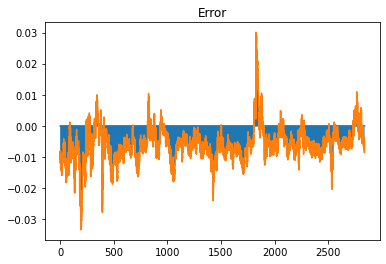

In [83]:
predicted2 = np.ravel(i)
y_test2 = np.ravel(y_test)

plt.title('Error')
error = scaler.inverse_transform(scaler2.inverse_transform([[x,0,0] for x in predicted2]))[:,0] - scaler.inverse_transform(scaler2.inverse_transform([[x,0,0] for x in y_test2]))[:, 0]
plt.plot(np.arange(len(error)), [0] * len(error))
plt.plot(error)
plt.fill_between(np.arange(len(error)), [0] * len(error), error)

In [ ]:
i3 = scaler2.inverse_transform([[x,0,0] for x in predicted2]).reshape(i.shape)
y_test3 = 

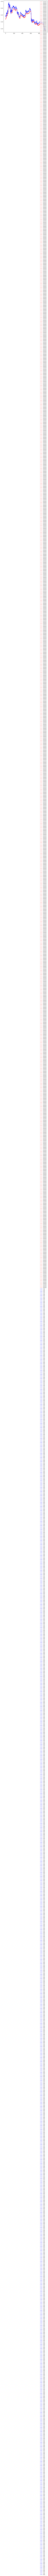

In [82]:
from matplotlib.pyplot import figure

figure(figsize=(8, 6), dpi=80)
for x in range(len(i)):
    plt.plot(np.arange(x,x+3), i[x],'r--',label="predict")
for x1 in range(len(y_test)):
    plt.plot(np.arange(x1,x1+3), y_test[x1],'b-',label="real")
plt.legend()

In [850]:
i = model.predict(x_test)
predicted = np.ravel(i)

print(predicted)
print(y_test)
'''
for x_test:
    model.predict()
'''

[0.4378854  0.43973172 0.4417416  0.44377974 0.4458659  0.44780722
 0.44950938 0.4506773  0.45129335 0.4518196  0.4523243  0.452843
 0.45324412 0.45407626 0.45529908 0.45660892 0.45820165 0.46036774
 0.4628315  0.46525478 0.46759838 0.46994972 0.47215456 0.4745888
 0.47727993 0.48006767 0.4828425  0.48457748 0.4857702  0.48677534
 0.48767695 0.48897022 0.49083808 0.4931028  0.4952983  0.49756175
 0.49987805 0.5016203  0.5034652  0.50522804 0.50693315 0.50911313
 0.5115885  0.5142452  0.51671857 0.51863366 0.5203795  0.5214724
 0.5216707  0.52131593 0.5208393  0.52032447 0.51971114 0.518686
 0.51754665 0.51705766 0.516501   0.5167649  0.5173264  0.51809263
 0.51901126 0.5204118  0.5219221  0.5239981  0.5263093  0.52919734
 0.5322615  0.5350671  0.5373984  0.5394421  0.54128855 0.5428385
 0.54440635 0.54563963 0.54645693 0.5473013  0.54842055 0.549471
 0.5501796  0.55022454 0.54969525 0.5490546  0.54828274 0.5476332
 0.5468276  0.544894   0.54278594 0.5407517  0.5386078  0.5355243
 0.532

'\nfor x_test:\n    model.predict()\n'

In [684]:
plt.plot(scaler2.inverse_transform(scaler.inverse_transform(i)).ravel()[0:100], label='predict')
plt.plot(scaler2.inverse_transform(scaler.inverse_transform(y_test.reshape(-1, 1)))[0:100], label='actual')
plt.xlabel('Hours')
plt.ylabel('Log percentage change')
plt.legend()

ValueError: non-broadcastable output operand with shape (217,1) doesn't match the broadcast shape (217,3)

In [874]:
i = model.predict(x_test)
predicted = np.ravel(i)

print(predicted)
print(y_test)
'''
for x_test:
    model.predict()
'''

[0.4346044  0.4366358  0.43880162 0.44098186 0.4431715  0.4451952
 0.44693857 0.4481206  0.4486825  0.44904676 0.44934425 0.449632
 0.44981638 0.4503995  0.4514351  0.45263976 0.45415682 0.4562742
 0.4587683  0.461285   0.46373898 0.46618834 0.46848977 0.47095644
 0.47366267 0.47647005 0.47927043 0.4811461  0.48239994 0.4833874
 0.48421127 0.48533627 0.48702395 0.4891729  0.49137017 0.49367535
 0.49607795 0.49800694 0.49994978 0.50182366 0.5036168  0.50580627
 0.5083206  0.51105314 0.5136884  0.5158477  0.5177907  0.5191305
 0.5195655  0.51933223 0.51883113 0.518198   0.517418   0.5162416
 0.5148934  0.514098   0.5133566  0.5133643  0.51382387 0.51458114
 0.5155799  0.5170802  0.5187876  0.5210385  0.52360874 0.52674294
 0.5301415  0.5333659  0.53616095 0.53862345 0.54082817 0.5426933
 0.5444721  0.54592156 0.5469255  0.5478496  0.548977   0.5500791
 0.5509008  0.55113    0.5507584  0.5501517  0.5493482  0.54856306
 0.5476327  0.5456962  0.54339445 0.54106814 0.53859377 0.53523463
 0.5

'\nfor x_test:\n    model.predict()\n'

In [949]:
i2 = model.predict(x_test)
predicted2 = np.ravel(i2)

print(predicted)
print(y_test)
'''
for x_test:
    model.predict()
'''

[0.4346044  0.4366358  0.43880162 0.44098186 0.4431715  0.4451952
 0.44693857 0.4481206  0.4486825  0.44904676 0.44934425 0.449632
 0.44981638 0.4503995  0.4514351  0.45263976 0.45415682 0.4562742
 0.4587683  0.461285   0.46373898 0.46618834 0.46848977 0.47095644
 0.47366267 0.47647005 0.47927043 0.4811461  0.48239994 0.4833874
 0.48421127 0.48533627 0.48702395 0.4891729  0.49137017 0.49367535
 0.49607795 0.49800694 0.49994978 0.50182366 0.5036168  0.50580627
 0.5083206  0.51105314 0.5136884  0.5158477  0.5177907  0.5191305
 0.5195655  0.51933223 0.51883113 0.518198   0.517418   0.5162416
 0.5148934  0.514098   0.5133566  0.5133643  0.51382387 0.51458114
 0.5155799  0.5170802  0.5187876  0.5210385  0.52360874 0.52674294
 0.5301415  0.5333659  0.53616095 0.53862345 0.54082817 0.5426933
 0.5444721  0.54592156 0.5469255  0.5478496  0.548977   0.5500791
 0.5509008  0.55113    0.5507584  0.5501517  0.5493482  0.54856306
 0.5476327  0.5456962  0.54339445 0.54106814 0.53859377 0.53523463
 0.5

'\nfor x_test:\n    model.predict()\n'

In [880]:
x_test[1][-1]

array([0.46628292])

In [916]:
a = list(x_test[0].ravel())
length = len(a)
pred = model.predict(np.array([x_test[0]])).ravel()
a.append(pred[0])
for x in x_test[1:]:
    #a[-length:].reshape(-1,1)
    print(np.array(a[-length:]).reshape(1,-1,1))
    pred = model.predict(np.array(a[-length:]).reshape(1,-1,1)).ravel()
    a.append(pred[0])

[[[0.36626812]
  [0.36672348]
  [0.36636758]
  [0.36557322]
  [0.35784763]
  [0.35243509]
  [0.34703504]
  [0.34806715]
  [0.3524354 ]
  [0.35163254]
  [0.35204285]
  [0.35209475]
  [0.35565835]
  [0.35794163]
  [0.35408738]
  [0.35282076]
  [0.35720758]
  [0.35569435]
  [0.35293292]
  [0.35479685]
  [0.35635067]
  [0.35539696]
  [0.35635075]
  [0.35637608]
  [0.35523149]
  [0.35215056]
  [0.35010676]
  [0.35245017]
  [0.35443304]
  [0.35519394]
  [0.3559187 ]
  [0.351815  ]
  [0.35096712]
  [0.34725824]
  [0.34684862]
  [0.34278563]
  [0.34191134]
  [0.34495133]
  [0.34269399]
  [0.34277627]
  [0.34462079]
  [0.34243353]
  [0.34120745]
  [0.34663352]
  [0.35188313]
  [0.34614892]
  [0.3439232 ]
  [0.34507914]
  [0.34106513]
  [0.34481628]
  [0.34367201]
  [0.34805265]
  [0.34890799]
  [0.35034746]
  [0.34689532]
  [0.35353451]
  [0.35151418]
  [0.34976002]
  [0.34649528]
  [0.35157397]
  [0.35188411]
  [0.34614805]
  [0.34614926]
  [0.346374  ]
  [0.34848757]
  [0.35232894]
  [0.35335

[[[0.34703504]
  [0.34806715]
  [0.3524354 ]
  [0.35163254]
  [0.35204285]
  [0.35209475]
  [0.35565835]
  [0.35794163]
  [0.35408738]
  [0.35282076]
  [0.35720758]
  [0.35569435]
  [0.35293292]
  [0.35479685]
  [0.35635067]
  [0.35539696]
  [0.35635075]
  [0.35637608]
  [0.35523149]
  [0.35215056]
  [0.35010676]
  [0.35245017]
  [0.35443304]
  [0.35519394]
  [0.3559187 ]
  [0.351815  ]
  [0.35096712]
  [0.34725824]
  [0.34684862]
  [0.34278563]
  [0.34191134]
  [0.34495133]
  [0.34269399]
  [0.34277627]
  [0.34462079]
  [0.34243353]
  [0.34120745]
  [0.34663352]
  [0.35188313]
  [0.34614892]
  [0.3439232 ]
  [0.34507914]
  [0.34106513]
  [0.34481628]
  [0.34367201]
  [0.34805265]
  [0.34890799]
  [0.35034746]
  [0.34689532]
  [0.35353451]
  [0.35151418]
  [0.34976002]
  [0.34649528]
  [0.35157397]
  [0.35188411]
  [0.34614805]
  [0.34614926]
  [0.346374  ]
  [0.34848757]
  [0.35232894]
  [0.3533571 ]
  [0.35924649]
  [0.35731941]
  [0.36224693]
  [0.36468338]
  [0.3615953 ]
  [0.36157

[[[0.35794163]
  [0.35408738]
  [0.35282076]
  [0.35720758]
  [0.35569435]
  [0.35293292]
  [0.35479685]
  [0.35635067]
  [0.35539696]
  [0.35635075]
  [0.35637608]
  [0.35523149]
  [0.35215056]
  [0.35010676]
  [0.35245017]
  [0.35443304]
  [0.35519394]
  [0.3559187 ]
  [0.351815  ]
  [0.35096712]
  [0.34725824]
  [0.34684862]
  [0.34278563]
  [0.34191134]
  [0.34495133]
  [0.34269399]
  [0.34277627]
  [0.34462079]
  [0.34243353]
  [0.34120745]
  [0.34663352]
  [0.35188313]
  [0.34614892]
  [0.3439232 ]
  [0.34507914]
  [0.34106513]
  [0.34481628]
  [0.34367201]
  [0.34805265]
  [0.34890799]
  [0.35034746]
  [0.34689532]
  [0.35353451]
  [0.35151418]
  [0.34976002]
  [0.34649528]
  [0.35157397]
  [0.35188411]
  [0.34614805]
  [0.34614926]
  [0.346374  ]
  [0.34848757]
  [0.35232894]
  [0.3533571 ]
  [0.35924649]
  [0.35731941]
  [0.36224693]
  [0.36468338]
  [0.3615953 ]
  [0.36157243]
  [0.36064984]
  [0.36371553]
  [0.36306336]
  [0.36234336]
  [0.36169433]
  [0.36218942]
  [0.35895

[[[0.35635067]
  [0.35539696]
  [0.35635075]
  [0.35637608]
  [0.35523149]
  [0.35215056]
  [0.35010676]
  [0.35245017]
  [0.35443304]
  [0.35519394]
  [0.3559187 ]
  [0.351815  ]
  [0.35096712]
  [0.34725824]
  [0.34684862]
  [0.34278563]
  [0.34191134]
  [0.34495133]
  [0.34269399]
  [0.34277627]
  [0.34462079]
  [0.34243353]
  [0.34120745]
  [0.34663352]
  [0.35188313]
  [0.34614892]
  [0.3439232 ]
  [0.34507914]
  [0.34106513]
  [0.34481628]
  [0.34367201]
  [0.34805265]
  [0.34890799]
  [0.35034746]
  [0.34689532]
  [0.35353451]
  [0.35151418]
  [0.34976002]
  [0.34649528]
  [0.35157397]
  [0.35188411]
  [0.34614805]
  [0.34614926]
  [0.346374  ]
  [0.34848757]
  [0.35232894]
  [0.3533571 ]
  [0.35924649]
  [0.35731941]
  [0.36224693]
  [0.36468338]
  [0.3615953 ]
  [0.36157243]
  [0.36064984]
  [0.36371553]
  [0.36306336]
  [0.36234336]
  [0.36169433]
  [0.36218942]
  [0.35895276]
  [0.36244718]
  [0.3666557 ]
  [0.36394001]
  [0.36521857]
  [0.36036783]
  [0.35995034]
  [0.35932

[[[0.35245017]
  [0.35443304]
  [0.35519394]
  [0.3559187 ]
  [0.351815  ]
  [0.35096712]
  [0.34725824]
  [0.34684862]
  [0.34278563]
  [0.34191134]
  [0.34495133]
  [0.34269399]
  [0.34277627]
  [0.34462079]
  [0.34243353]
  [0.34120745]
  [0.34663352]
  [0.35188313]
  [0.34614892]
  [0.3439232 ]
  [0.34507914]
  [0.34106513]
  [0.34481628]
  [0.34367201]
  [0.34805265]
  [0.34890799]
  [0.35034746]
  [0.34689532]
  [0.35353451]
  [0.35151418]
  [0.34976002]
  [0.34649528]
  [0.35157397]
  [0.35188411]
  [0.34614805]
  [0.34614926]
  [0.346374  ]
  [0.34848757]
  [0.35232894]
  [0.3533571 ]
  [0.35924649]
  [0.35731941]
  [0.36224693]
  [0.36468338]
  [0.3615953 ]
  [0.36157243]
  [0.36064984]
  [0.36371553]
  [0.36306336]
  [0.36234336]
  [0.36169433]
  [0.36218942]
  [0.35895276]
  [0.36244718]
  [0.3666557 ]
  [0.36394001]
  [0.36521857]
  [0.36036783]
  [0.35995034]
  [0.35932135]
  [0.35375427]
  [0.35351645]
  [0.35829273]
  [0.35507636]
  [0.35485644]
  [0.36305107]
  [0.36562

[[[0.34684862]
  [0.34278563]
  [0.34191134]
  [0.34495133]
  [0.34269399]
  [0.34277627]
  [0.34462079]
  [0.34243353]
  [0.34120745]
  [0.34663352]
  [0.35188313]
  [0.34614892]
  [0.3439232 ]
  [0.34507914]
  [0.34106513]
  [0.34481628]
  [0.34367201]
  [0.34805265]
  [0.34890799]
  [0.35034746]
  [0.34689532]
  [0.35353451]
  [0.35151418]
  [0.34976002]
  [0.34649528]
  [0.35157397]
  [0.35188411]
  [0.34614805]
  [0.34614926]
  [0.346374  ]
  [0.34848757]
  [0.35232894]
  [0.3533571 ]
  [0.35924649]
  [0.35731941]
  [0.36224693]
  [0.36468338]
  [0.3615953 ]
  [0.36157243]
  [0.36064984]
  [0.36371553]
  [0.36306336]
  [0.36234336]
  [0.36169433]
  [0.36218942]
  [0.35895276]
  [0.36244718]
  [0.3666557 ]
  [0.36394001]
  [0.36521857]
  [0.36036783]
  [0.35995034]
  [0.35932135]
  [0.35375427]
  [0.35351645]
  [0.35829273]
  [0.35507636]
  [0.35485644]
  [0.36305107]
  [0.36562796]
  [0.36276485]
  [0.36927839]
  [0.37041412]
  [0.37139002]
  [0.3724534 ]
  [0.3722499 ]
  [0.37248

[[[0.34243353]
  [0.34120745]
  [0.34663352]
  [0.35188313]
  [0.34614892]
  [0.3439232 ]
  [0.34507914]
  [0.34106513]
  [0.34481628]
  [0.34367201]
  [0.34805265]
  [0.34890799]
  [0.35034746]
  [0.34689532]
  [0.35353451]
  [0.35151418]
  [0.34976002]
  [0.34649528]
  [0.35157397]
  [0.35188411]
  [0.34614805]
  [0.34614926]
  [0.346374  ]
  [0.34848757]
  [0.35232894]
  [0.3533571 ]
  [0.35924649]
  [0.35731941]
  [0.36224693]
  [0.36468338]
  [0.3615953 ]
  [0.36157243]
  [0.36064984]
  [0.36371553]
  [0.36306336]
  [0.36234336]
  [0.36169433]
  [0.36218942]
  [0.35895276]
  [0.36244718]
  [0.3666557 ]
  [0.36394001]
  [0.36521857]
  [0.36036783]
  [0.35995034]
  [0.35932135]
  [0.35375427]
  [0.35351645]
  [0.35829273]
  [0.35507636]
  [0.35485644]
  [0.36305107]
  [0.36562796]
  [0.36276485]
  [0.36927839]
  [0.37041412]
  [0.37139002]
  [0.3724534 ]
  [0.3722499 ]
  [0.37248817]
  [0.37279463]
  [0.3690936 ]
  [0.36964398]
  [0.37055876]
  [0.36908091]
  [0.36768896]
  [0.37008

[[[0.34106513]
  [0.34481628]
  [0.34367201]
  [0.34805265]
  [0.34890799]
  [0.35034746]
  [0.34689532]
  [0.35353451]
  [0.35151418]
  [0.34976002]
  [0.34649528]
  [0.35157397]
  [0.35188411]
  [0.34614805]
  [0.34614926]
  [0.346374  ]
  [0.34848757]
  [0.35232894]
  [0.3533571 ]
  [0.35924649]
  [0.35731941]
  [0.36224693]
  [0.36468338]
  [0.3615953 ]
  [0.36157243]
  [0.36064984]
  [0.36371553]
  [0.36306336]
  [0.36234336]
  [0.36169433]
  [0.36218942]
  [0.35895276]
  [0.36244718]
  [0.3666557 ]
  [0.36394001]
  [0.36521857]
  [0.36036783]
  [0.35995034]
  [0.35932135]
  [0.35375427]
  [0.35351645]
  [0.35829273]
  [0.35507636]
  [0.35485644]
  [0.36305107]
  [0.36562796]
  [0.36276485]
  [0.36927839]
  [0.37041412]
  [0.37139002]
  [0.3724534 ]
  [0.3722499 ]
  [0.37248817]
  [0.37279463]
  [0.3690936 ]
  [0.36964398]
  [0.37055876]
  [0.36908091]
  [0.36768896]
  [0.37008954]
  [0.3713192 ]
  [0.37083593]
  [0.37362923]
  [0.37364495]
  [0.37328052]
  [0.37320898]
  [0.37679

[[[0.35353451]
  [0.35151418]
  [0.34976002]
  [0.34649528]
  [0.35157397]
  [0.35188411]
  [0.34614805]
  [0.34614926]
  [0.346374  ]
  [0.34848757]
  [0.35232894]
  [0.3533571 ]
  [0.35924649]
  [0.35731941]
  [0.36224693]
  [0.36468338]
  [0.3615953 ]
  [0.36157243]
  [0.36064984]
  [0.36371553]
  [0.36306336]
  [0.36234336]
  [0.36169433]
  [0.36218942]
  [0.35895276]
  [0.36244718]
  [0.3666557 ]
  [0.36394001]
  [0.36521857]
  [0.36036783]
  [0.35995034]
  [0.35932135]
  [0.35375427]
  [0.35351645]
  [0.35829273]
  [0.35507636]
  [0.35485644]
  [0.36305107]
  [0.36562796]
  [0.36276485]
  [0.36927839]
  [0.37041412]
  [0.37139002]
  [0.3724534 ]
  [0.3722499 ]
  [0.37248817]
  [0.37279463]
  [0.3690936 ]
  [0.36964398]
  [0.37055876]
  [0.36908091]
  [0.36768896]
  [0.37008954]
  [0.3713192 ]
  [0.37083593]
  [0.37362923]
  [0.37364495]
  [0.37328052]
  [0.37320898]
  [0.37679672]
  [0.3778368 ]
  [0.38250804]
  [0.38961246]
  [0.39172566]
  [0.3935748 ]
  [0.39299152]
  [0.39477

[[[0.34614926]
  [0.346374  ]
  [0.34848757]
  [0.35232894]
  [0.3533571 ]
  [0.35924649]
  [0.35731941]
  [0.36224693]
  [0.36468338]
  [0.3615953 ]
  [0.36157243]
  [0.36064984]
  [0.36371553]
  [0.36306336]
  [0.36234336]
  [0.36169433]
  [0.36218942]
  [0.35895276]
  [0.36244718]
  [0.3666557 ]
  [0.36394001]
  [0.36521857]
  [0.36036783]
  [0.35995034]
  [0.35932135]
  [0.35375427]
  [0.35351645]
  [0.35829273]
  [0.35507636]
  [0.35485644]
  [0.36305107]
  [0.36562796]
  [0.36276485]
  [0.36927839]
  [0.37041412]
  [0.37139002]
  [0.3724534 ]
  [0.3722499 ]
  [0.37248817]
  [0.37279463]
  [0.3690936 ]
  [0.36964398]
  [0.37055876]
  [0.36908091]
  [0.36768896]
  [0.37008954]
  [0.3713192 ]
  [0.37083593]
  [0.37362923]
  [0.37364495]
  [0.37328052]
  [0.37320898]
  [0.37679672]
  [0.3778368 ]
  [0.38250804]
  [0.38961246]
  [0.39172566]
  [0.3935748 ]
  [0.39299152]
  [0.39477278]
  [0.39078548]
  [0.38622272]
  [0.38561865]
  [0.38913664]
  [0.395869  ]
  [0.40419639]
  [0.40417

[[[0.36224693]
  [0.36468338]
  [0.3615953 ]
  [0.36157243]
  [0.36064984]
  [0.36371553]
  [0.36306336]
  [0.36234336]
  [0.36169433]
  [0.36218942]
  [0.35895276]
  [0.36244718]
  [0.3666557 ]
  [0.36394001]
  [0.36521857]
  [0.36036783]
  [0.35995034]
  [0.35932135]
  [0.35375427]
  [0.35351645]
  [0.35829273]
  [0.35507636]
  [0.35485644]
  [0.36305107]
  [0.36562796]
  [0.36276485]
  [0.36927839]
  [0.37041412]
  [0.37139002]
  [0.3724534 ]
  [0.3722499 ]
  [0.37248817]
  [0.37279463]
  [0.3690936 ]
  [0.36964398]
  [0.37055876]
  [0.36908091]
  [0.36768896]
  [0.37008954]
  [0.3713192 ]
  [0.37083593]
  [0.37362923]
  [0.37364495]
  [0.37328052]
  [0.37320898]
  [0.37679672]
  [0.3778368 ]
  [0.38250804]
  [0.38961246]
  [0.39172566]
  [0.3935748 ]
  [0.39299152]
  [0.39477278]
  [0.39078548]
  [0.38622272]
  [0.38561865]
  [0.38913664]
  [0.395869  ]
  [0.40419639]
  [0.40417971]
  [0.40448345]
  [0.40849215]
  [0.41738101]
  [0.4140476 ]
  [0.42502479]
  [0.43248651]
  [0.44186

[[[0.36234336]
  [0.36169433]
  [0.36218942]
  [0.35895276]
  [0.36244718]
  [0.3666557 ]
  [0.36394001]
  [0.36521857]
  [0.36036783]
  [0.35995034]
  [0.35932135]
  [0.35375427]
  [0.35351645]
  [0.35829273]
  [0.35507636]
  [0.35485644]
  [0.36305107]
  [0.36562796]
  [0.36276485]
  [0.36927839]
  [0.37041412]
  [0.37139002]
  [0.3724534 ]
  [0.3722499 ]
  [0.37248817]
  [0.37279463]
  [0.3690936 ]
  [0.36964398]
  [0.37055876]
  [0.36908091]
  [0.36768896]
  [0.37008954]
  [0.3713192 ]
  [0.37083593]
  [0.37362923]
  [0.37364495]
  [0.37328052]
  [0.37320898]
  [0.37679672]
  [0.3778368 ]
  [0.38250804]
  [0.38961246]
  [0.39172566]
  [0.3935748 ]
  [0.39299152]
  [0.39477278]
  [0.39078548]
  [0.38622272]
  [0.38561865]
  [0.38913664]
  [0.395869  ]
  [0.40419639]
  [0.40417971]
  [0.40448345]
  [0.40849215]
  [0.41738101]
  [0.4140476 ]
  [0.42502479]
  [0.43248651]
  [0.44186516]
  [0.43118664]
  [0.42970834]
  [0.43193537]
  [0.42347155]
  [0.42656634]
  [0.42178077]
  [0.41827

[[[0.36521857]
  [0.36036783]
  [0.35995034]
  [0.35932135]
  [0.35375427]
  [0.35351645]
  [0.35829273]
  [0.35507636]
  [0.35485644]
  [0.36305107]
  [0.36562796]
  [0.36276485]
  [0.36927839]
  [0.37041412]
  [0.37139002]
  [0.3724534 ]
  [0.3722499 ]
  [0.37248817]
  [0.37279463]
  [0.3690936 ]
  [0.36964398]
  [0.37055876]
  [0.36908091]
  [0.36768896]
  [0.37008954]
  [0.3713192 ]
  [0.37083593]
  [0.37362923]
  [0.37364495]
  [0.37328052]
  [0.37320898]
  [0.37679672]
  [0.3778368 ]
  [0.38250804]
  [0.38961246]
  [0.39172566]
  [0.3935748 ]
  [0.39299152]
  [0.39477278]
  [0.39078548]
  [0.38622272]
  [0.38561865]
  [0.38913664]
  [0.395869  ]
  [0.40419639]
  [0.40417971]
  [0.40448345]
  [0.40849215]
  [0.41738101]
  [0.4140476 ]
  [0.42502479]
  [0.43248651]
  [0.44186516]
  [0.43118664]
  [0.42970834]
  [0.43193537]
  [0.42347155]
  [0.42656634]
  [0.42178077]
  [0.4182731 ]
  [0.41355862]
  [0.41734038]
  [0.41590843]
  [0.41950064]
  [0.42108373]
  [0.41908191]
  [0.42359

[[[0.35507636]
  [0.35485644]
  [0.36305107]
  [0.36562796]
  [0.36276485]
  [0.36927839]
  [0.37041412]
  [0.37139002]
  [0.3724534 ]
  [0.3722499 ]
  [0.37248817]
  [0.37279463]
  [0.3690936 ]
  [0.36964398]
  [0.37055876]
  [0.36908091]
  [0.36768896]
  [0.37008954]
  [0.3713192 ]
  [0.37083593]
  [0.37362923]
  [0.37364495]
  [0.37328052]
  [0.37320898]
  [0.37679672]
  [0.3778368 ]
  [0.38250804]
  [0.38961246]
  [0.39172566]
  [0.3935748 ]
  [0.39299152]
  [0.39477278]
  [0.39078548]
  [0.38622272]
  [0.38561865]
  [0.38913664]
  [0.395869  ]
  [0.40419639]
  [0.40417971]
  [0.40448345]
  [0.40849215]
  [0.41738101]
  [0.4140476 ]
  [0.42502479]
  [0.43248651]
  [0.44186516]
  [0.43118664]
  [0.42970834]
  [0.43193537]
  [0.42347155]
  [0.42656634]
  [0.42178077]
  [0.4182731 ]
  [0.41355862]
  [0.41734038]
  [0.41590843]
  [0.41950064]
  [0.42108373]
  [0.41908191]
  [0.42359574]
  [0.43766584]
  [0.42547552]
  [0.42716875]
  [0.43050597]
  [0.43352805]
  [0.43889671]
  [0.43638

[[[0.37139002]
  [0.3724534 ]
  [0.3722499 ]
  [0.37248817]
  [0.37279463]
  [0.3690936 ]
  [0.36964398]
  [0.37055876]
  [0.36908091]
  [0.36768896]
  [0.37008954]
  [0.3713192 ]
  [0.37083593]
  [0.37362923]
  [0.37364495]
  [0.37328052]
  [0.37320898]
  [0.37679672]
  [0.3778368 ]
  [0.38250804]
  [0.38961246]
  [0.39172566]
  [0.3935748 ]
  [0.39299152]
  [0.39477278]
  [0.39078548]
  [0.38622272]
  [0.38561865]
  [0.38913664]
  [0.395869  ]
  [0.40419639]
  [0.40417971]
  [0.40448345]
  [0.40849215]
  [0.41738101]
  [0.4140476 ]
  [0.42502479]
  [0.43248651]
  [0.44186516]
  [0.43118664]
  [0.42970834]
  [0.43193537]
  [0.42347155]
  [0.42656634]
  [0.42178077]
  [0.4182731 ]
  [0.41355862]
  [0.41734038]
  [0.41590843]
  [0.41950064]
  [0.42108373]
  [0.41908191]
  [0.42359574]
  [0.43766584]
  [0.42547552]
  [0.42716875]
  [0.43050597]
  [0.43352805]
  [0.43889671]
  [0.43638886]
  [0.43891385]
  [0.43132117]
  [0.43321727]
  [0.42518401]
  [0.42752125]
  [0.43105781]
  [0.42847

[[[0.37055876]
  [0.36908091]
  [0.36768896]
  [0.37008954]
  [0.3713192 ]
  [0.37083593]
  [0.37362923]
  [0.37364495]
  [0.37328052]
  [0.37320898]
  [0.37679672]
  [0.3778368 ]
  [0.38250804]
  [0.38961246]
  [0.39172566]
  [0.3935748 ]
  [0.39299152]
  [0.39477278]
  [0.39078548]
  [0.38622272]
  [0.38561865]
  [0.38913664]
  [0.395869  ]
  [0.40419639]
  [0.40417971]
  [0.40448345]
  [0.40849215]
  [0.41738101]
  [0.4140476 ]
  [0.42502479]
  [0.43248651]
  [0.44186516]
  [0.43118664]
  [0.42970834]
  [0.43193537]
  [0.42347155]
  [0.42656634]
  [0.42178077]
  [0.4182731 ]
  [0.41355862]
  [0.41734038]
  [0.41590843]
  [0.41950064]
  [0.42108373]
  [0.41908191]
  [0.42359574]
  [0.43766584]
  [0.42547552]
  [0.42716875]
  [0.43050597]
  [0.43352805]
  [0.43889671]
  [0.43638886]
  [0.43891385]
  [0.43132117]
  [0.43321727]
  [0.42518401]
  [0.42752125]
  [0.43105781]
  [0.42847749]
  [0.42074846]
  [0.42106741]
  [0.41868691]
  [0.41501495]
  [0.4118685 ]
  [0.40819874]
  [0.40865

[[[0.37362923]
  [0.37364495]
  [0.37328052]
  [0.37320898]
  [0.37679672]
  [0.3778368 ]
  [0.38250804]
  [0.38961246]
  [0.39172566]
  [0.3935748 ]
  [0.39299152]
  [0.39477278]
  [0.39078548]
  [0.38622272]
  [0.38561865]
  [0.38913664]
  [0.395869  ]
  [0.40419639]
  [0.40417971]
  [0.40448345]
  [0.40849215]
  [0.41738101]
  [0.4140476 ]
  [0.42502479]
  [0.43248651]
  [0.44186516]
  [0.43118664]
  [0.42970834]
  [0.43193537]
  [0.42347155]
  [0.42656634]
  [0.42178077]
  [0.4182731 ]
  [0.41355862]
  [0.41734038]
  [0.41590843]
  [0.41950064]
  [0.42108373]
  [0.41908191]
  [0.42359574]
  [0.43766584]
  [0.42547552]
  [0.42716875]
  [0.43050597]
  [0.43352805]
  [0.43889671]
  [0.43638886]
  [0.43891385]
  [0.43132117]
  [0.43321727]
  [0.42518401]
  [0.42752125]
  [0.43105781]
  [0.42847749]
  [0.42074846]
  [0.42106741]
  [0.41868691]
  [0.41501495]
  [0.4118685 ]
  [0.40819874]
  [0.40865525]
  [0.41551078]
  [0.42290159]
  [0.41757382]
  [0.40569618]
  [0.40407844]
  [0.40406

[[[0.38961246]
  [0.39172566]
  [0.3935748 ]
  [0.39299152]
  [0.39477278]
  [0.39078548]
  [0.38622272]
  [0.38561865]
  [0.38913664]
  [0.395869  ]
  [0.40419639]
  [0.40417971]
  [0.40448345]
  [0.40849215]
  [0.41738101]
  [0.4140476 ]
  [0.42502479]
  [0.43248651]
  [0.44186516]
  [0.43118664]
  [0.42970834]
  [0.43193537]
  [0.42347155]
  [0.42656634]
  [0.42178077]
  [0.4182731 ]
  [0.41355862]
  [0.41734038]
  [0.41590843]
  [0.41950064]
  [0.42108373]
  [0.41908191]
  [0.42359574]
  [0.43766584]
  [0.42547552]
  [0.42716875]
  [0.43050597]
  [0.43352805]
  [0.43889671]
  [0.43638886]
  [0.43891385]
  [0.43132117]
  [0.43321727]
  [0.42518401]
  [0.42752125]
  [0.43105781]
  [0.42847749]
  [0.42074846]
  [0.42106741]
  [0.41868691]
  [0.41501495]
  [0.4118685 ]
  [0.40819874]
  [0.40865525]
  [0.41551078]
  [0.42290159]
  [0.41757382]
  [0.40569618]
  [0.40407844]
  [0.40406374]
  [0.4075652 ]
  [0.40795927]
  [0.40763256]
  [0.40384718]
  [0.40593758]
  [0.41142904]
  [0.42005

[[[0.38622272]
  [0.38561865]
  [0.38913664]
  [0.395869  ]
  [0.40419639]
  [0.40417971]
  [0.40448345]
  [0.40849215]
  [0.41738101]
  [0.4140476 ]
  [0.42502479]
  [0.43248651]
  [0.44186516]
  [0.43118664]
  [0.42970834]
  [0.43193537]
  [0.42347155]
  [0.42656634]
  [0.42178077]
  [0.4182731 ]
  [0.41355862]
  [0.41734038]
  [0.41590843]
  [0.41950064]
  [0.42108373]
  [0.41908191]
  [0.42359574]
  [0.43766584]
  [0.42547552]
  [0.42716875]
  [0.43050597]
  [0.43352805]
  [0.43889671]
  [0.43638886]
  [0.43891385]
  [0.43132117]
  [0.43321727]
  [0.42518401]
  [0.42752125]
  [0.43105781]
  [0.42847749]
  [0.42074846]
  [0.42106741]
  [0.41868691]
  [0.41501495]
  [0.4118685 ]
  [0.40819874]
  [0.40865525]
  [0.41551078]
  [0.42290159]
  [0.41757382]
  [0.40569618]
  [0.40407844]
  [0.40406374]
  [0.4075652 ]
  [0.40795927]
  [0.40763256]
  [0.40384718]
  [0.40593758]
  [0.41142904]
  [0.42005179]
  [0.42442758]
  [0.42899247]
  [0.42625359]
  [0.42969531]
  [0.42834832]
  [0.43288

[[[0.40448345]
  [0.40849215]
  [0.41738101]
  [0.4140476 ]
  [0.42502479]
  [0.43248651]
  [0.44186516]
  [0.43118664]
  [0.42970834]
  [0.43193537]
  [0.42347155]
  [0.42656634]
  [0.42178077]
  [0.4182731 ]
  [0.41355862]
  [0.41734038]
  [0.41590843]
  [0.41950064]
  [0.42108373]
  [0.41908191]
  [0.42359574]
  [0.43766584]
  [0.42547552]
  [0.42716875]
  [0.43050597]
  [0.43352805]
  [0.43889671]
  [0.43638886]
  [0.43891385]
  [0.43132117]
  [0.43321727]
  [0.42518401]
  [0.42752125]
  [0.43105781]
  [0.42847749]
  [0.42074846]
  [0.42106741]
  [0.41868691]
  [0.41501495]
  [0.4118685 ]
  [0.40819874]
  [0.40865525]
  [0.41551078]
  [0.42290159]
  [0.41757382]
  [0.40569618]
  [0.40407844]
  [0.40406374]
  [0.4075652 ]
  [0.40795927]
  [0.40763256]
  [0.40384718]
  [0.40593758]
  [0.41142904]
  [0.42005179]
  [0.42442758]
  [0.42899247]
  [0.42625359]
  [0.42969531]
  [0.42834832]
  [0.43288864]
  [0.42805193]
  [0.42995934]
  [0.43454464]
  [0.43361075]
  [0.42806044]
  [0.42680

[[[0.43118664]
  [0.42970834]
  [0.43193537]
  [0.42347155]
  [0.42656634]
  [0.42178077]
  [0.4182731 ]
  [0.41355862]
  [0.41734038]
  [0.41590843]
  [0.41950064]
  [0.42108373]
  [0.41908191]
  [0.42359574]
  [0.43766584]
  [0.42547552]
  [0.42716875]
  [0.43050597]
  [0.43352805]
  [0.43889671]
  [0.43638886]
  [0.43891385]
  [0.43132117]
  [0.43321727]
  [0.42518401]
  [0.42752125]
  [0.43105781]
  [0.42847749]
  [0.42074846]
  [0.42106741]
  [0.41868691]
  [0.41501495]
  [0.4118685 ]
  [0.40819874]
  [0.40865525]
  [0.41551078]
  [0.42290159]
  [0.41757382]
  [0.40569618]
  [0.40407844]
  [0.40406374]
  [0.4075652 ]
  [0.40795927]
  [0.40763256]
  [0.40384718]
  [0.40593758]
  [0.41142904]
  [0.42005179]
  [0.42442758]
  [0.42899247]
  [0.42625359]
  [0.42969531]
  [0.42834832]
  [0.43288864]
  [0.42805193]
  [0.42995934]
  [0.43454464]
  [0.43361075]
  [0.42806044]
  [0.42680271]
  [0.42757813]
  [0.42798345]
  [0.42480002]
  [0.42572939]
  [0.42987414]
  [0.42391685]
  [0.42567

[[[0.41355862]
  [0.41734038]
  [0.41590843]
  [0.41950064]
  [0.42108373]
  [0.41908191]
  [0.42359574]
  [0.43766584]
  [0.42547552]
  [0.42716875]
  [0.43050597]
  [0.43352805]
  [0.43889671]
  [0.43638886]
  [0.43891385]
  [0.43132117]
  [0.43321727]
  [0.42518401]
  [0.42752125]
  [0.43105781]
  [0.42847749]
  [0.42074846]
  [0.42106741]
  [0.41868691]
  [0.41501495]
  [0.4118685 ]
  [0.40819874]
  [0.40865525]
  [0.41551078]
  [0.42290159]
  [0.41757382]
  [0.40569618]
  [0.40407844]
  [0.40406374]
  [0.4075652 ]
  [0.40795927]
  [0.40763256]
  [0.40384718]
  [0.40593758]
  [0.41142904]
  [0.42005179]
  [0.42442758]
  [0.42899247]
  [0.42625359]
  [0.42969531]
  [0.42834832]
  [0.43288864]
  [0.42805193]
  [0.42995934]
  [0.43454464]
  [0.43361075]
  [0.42806044]
  [0.42680271]
  [0.42757813]
  [0.42798345]
  [0.42480002]
  [0.42572939]
  [0.42987414]
  [0.42391685]
  [0.42567684]
  [0.42704363]
  [0.42493615]
  [0.42685193]
  [0.43166908]
  [0.43122052]
  [0.42719737]
  [0.42879

[[[0.43766584]
  [0.42547552]
  [0.42716875]
  [0.43050597]
  [0.43352805]
  [0.43889671]
  [0.43638886]
  [0.43891385]
  [0.43132117]
  [0.43321727]
  [0.42518401]
  [0.42752125]
  [0.43105781]
  [0.42847749]
  [0.42074846]
  [0.42106741]
  [0.41868691]
  [0.41501495]
  [0.4118685 ]
  [0.40819874]
  [0.40865525]
  [0.41551078]
  [0.42290159]
  [0.41757382]
  [0.40569618]
  [0.40407844]
  [0.40406374]
  [0.4075652 ]
  [0.40795927]
  [0.40763256]
  [0.40384718]
  [0.40593758]
  [0.41142904]
  [0.42005179]
  [0.42442758]
  [0.42899247]
  [0.42625359]
  [0.42969531]
  [0.42834832]
  [0.43288864]
  [0.42805193]
  [0.42995934]
  [0.43454464]
  [0.43361075]
  [0.42806044]
  [0.42680271]
  [0.42757813]
  [0.42798345]
  [0.42480002]
  [0.42572939]
  [0.42987414]
  [0.42391685]
  [0.42567684]
  [0.42704363]
  [0.42493615]
  [0.42685193]
  [0.43166908]
  [0.43122052]
  [0.42719737]
  [0.42879559]
  [0.4324404 ]
  [0.44023897]
  [0.43283809]
  [0.42917305]
  [0.42094882]
  [0.4221041 ]
  [0.42638

[[[0.43891385]
  [0.43132117]
  [0.43321727]
  [0.42518401]
  [0.42752125]
  [0.43105781]
  [0.42847749]
  [0.42074846]
  [0.42106741]
  [0.41868691]
  [0.41501495]
  [0.4118685 ]
  [0.40819874]
  [0.40865525]
  [0.41551078]
  [0.42290159]
  [0.41757382]
  [0.40569618]
  [0.40407844]
  [0.40406374]
  [0.4075652 ]
  [0.40795927]
  [0.40763256]
  [0.40384718]
  [0.40593758]
  [0.41142904]
  [0.42005179]
  [0.42442758]
  [0.42899247]
  [0.42625359]
  [0.42969531]
  [0.42834832]
  [0.43288864]
  [0.42805193]
  [0.42995934]
  [0.43454464]
  [0.43361075]
  [0.42806044]
  [0.42680271]
  [0.42757813]
  [0.42798345]
  [0.42480002]
  [0.42572939]
  [0.42987414]
  [0.42391685]
  [0.42567684]
  [0.42704363]
  [0.42493615]
  [0.42685193]
  [0.43166908]
  [0.43122052]
  [0.42719737]
  [0.42879559]
  [0.4324404 ]
  [0.44023897]
  [0.43283809]
  [0.42917305]
  [0.42094882]
  [0.4221041 ]
  [0.42638067]
  [0.43132726]
  [0.43267128]
  [0.4348111 ]
  [0.43145431]
  [0.43166403]
  [0.43667497]
  [0.44284

[[[0.42074846]
  [0.42106741]
  [0.41868691]
  [0.41501495]
  [0.4118685 ]
  [0.40819874]
  [0.40865525]
  [0.41551078]
  [0.42290159]
  [0.41757382]
  [0.40569618]
  [0.40407844]
  [0.40406374]
  [0.4075652 ]
  [0.40795927]
  [0.40763256]
  [0.40384718]
  [0.40593758]
  [0.41142904]
  [0.42005179]
  [0.42442758]
  [0.42899247]
  [0.42625359]
  [0.42969531]
  [0.42834832]
  [0.43288864]
  [0.42805193]
  [0.42995934]
  [0.43454464]
  [0.43361075]
  [0.42806044]
  [0.42680271]
  [0.42757813]
  [0.42798345]
  [0.42480002]
  [0.42572939]
  [0.42987414]
  [0.42391685]
  [0.42567684]
  [0.42704363]
  [0.42493615]
  [0.42685193]
  [0.43166908]
  [0.43122052]
  [0.42719737]
  [0.42879559]
  [0.4324404 ]
  [0.44023897]
  [0.43283809]
  [0.42917305]
  [0.42094882]
  [0.4221041 ]
  [0.42638067]
  [0.43132726]
  [0.43267128]
  [0.4348111 ]
  [0.43145431]
  [0.43166403]
  [0.43667497]
  [0.44284766]
  [0.43797942]
  [0.44164267]
  [0.4393948 ]
  [0.44645836]
  [0.45699101]
  [0.45563235]
  [0.45104

[[[0.41551078]
  [0.42290159]
  [0.41757382]
  [0.40569618]
  [0.40407844]
  [0.40406374]
  [0.4075652 ]
  [0.40795927]
  [0.40763256]
  [0.40384718]
  [0.40593758]
  [0.41142904]
  [0.42005179]
  [0.42442758]
  [0.42899247]
  [0.42625359]
  [0.42969531]
  [0.42834832]
  [0.43288864]
  [0.42805193]
  [0.42995934]
  [0.43454464]
  [0.43361075]
  [0.42806044]
  [0.42680271]
  [0.42757813]
  [0.42798345]
  [0.42480002]
  [0.42572939]
  [0.42987414]
  [0.42391685]
  [0.42567684]
  [0.42704363]
  [0.42493615]
  [0.42685193]
  [0.43166908]
  [0.43122052]
  [0.42719737]
  [0.42879559]
  [0.4324404 ]
  [0.44023897]
  [0.43283809]
  [0.42917305]
  [0.42094882]
  [0.4221041 ]
  [0.42638067]
  [0.43132726]
  [0.43267128]
  [0.4348111 ]
  [0.43145431]
  [0.43166403]
  [0.43667497]
  [0.44284766]
  [0.43797942]
  [0.44164267]
  [0.4393948 ]
  [0.44645836]
  [0.45699101]
  [0.45563235]
  [0.45104322]
  [0.45470837]
  [0.45377331]
  [0.45450991]
  [0.4534814 ]
  [0.45711144]
  [0.4692999 ]
  [0.47220

[[[0.4075652 ]
  [0.40795927]
  [0.40763256]
  [0.40384718]
  [0.40593758]
  [0.41142904]
  [0.42005179]
  [0.42442758]
  [0.42899247]
  [0.42625359]
  [0.42969531]
  [0.42834832]
  [0.43288864]
  [0.42805193]
  [0.42995934]
  [0.43454464]
  [0.43361075]
  [0.42806044]
  [0.42680271]
  [0.42757813]
  [0.42798345]
  [0.42480002]
  [0.42572939]
  [0.42987414]
  [0.42391685]
  [0.42567684]
  [0.42704363]
  [0.42493615]
  [0.42685193]
  [0.43166908]
  [0.43122052]
  [0.42719737]
  [0.42879559]
  [0.4324404 ]
  [0.44023897]
  [0.43283809]
  [0.42917305]
  [0.42094882]
  [0.4221041 ]
  [0.42638067]
  [0.43132726]
  [0.43267128]
  [0.4348111 ]
  [0.43145431]
  [0.43166403]
  [0.43667497]
  [0.44284766]
  [0.43797942]
  [0.44164267]
  [0.4393948 ]
  [0.44645836]
  [0.45699101]
  [0.45563235]
  [0.45104322]
  [0.45470837]
  [0.45377331]
  [0.45450991]
  [0.4534814 ]
  [0.45711144]
  [0.4692999 ]
  [0.47220457]
  [0.47039066]
  [0.47085397]
  [0.46792952]
  [0.46843289]
  [0.47419928]
  [0.46599

[[[0.42442758]
  [0.42899247]
  [0.42625359]
  [0.42969531]
  [0.42834832]
  [0.43288864]
  [0.42805193]
  [0.42995934]
  [0.43454464]
  [0.43361075]
  [0.42806044]
  [0.42680271]
  [0.42757813]
  [0.42798345]
  [0.42480002]
  [0.42572939]
  [0.42987414]
  [0.42391685]
  [0.42567684]
  [0.42704363]
  [0.42493615]
  [0.42685193]
  [0.43166908]
  [0.43122052]
  [0.42719737]
  [0.42879559]
  [0.4324404 ]
  [0.44023897]
  [0.43283809]
  [0.42917305]
  [0.42094882]
  [0.4221041 ]
  [0.42638067]
  [0.43132726]
  [0.43267128]
  [0.4348111 ]
  [0.43145431]
  [0.43166403]
  [0.43667497]
  [0.44284766]
  [0.43797942]
  [0.44164267]
  [0.4393948 ]
  [0.44645836]
  [0.45699101]
  [0.45563235]
  [0.45104322]
  [0.45470837]
  [0.45377331]
  [0.45450991]
  [0.4534814 ]
  [0.45711144]
  [0.4692999 ]
  [0.47220457]
  [0.47039066]
  [0.47085397]
  [0.46792952]
  [0.46843289]
  [0.47419928]
  [0.4659969 ]
  [0.45155212]
  [0.45248442]
  [0.45479489]
  [0.46733732]
  [0.47385197]
  [0.4717836 ]
  [0.46299

[[[0.42995934]
  [0.43454464]
  [0.43361075]
  [0.42806044]
  [0.42680271]
  [0.42757813]
  [0.42798345]
  [0.42480002]
  [0.42572939]
  [0.42987414]
  [0.42391685]
  [0.42567684]
  [0.42704363]
  [0.42493615]
  [0.42685193]
  [0.43166908]
  [0.43122052]
  [0.42719737]
  [0.42879559]
  [0.4324404 ]
  [0.44023897]
  [0.43283809]
  [0.42917305]
  [0.42094882]
  [0.4221041 ]
  [0.42638067]
  [0.43132726]
  [0.43267128]
  [0.4348111 ]
  [0.43145431]
  [0.43166403]
  [0.43667497]
  [0.44284766]
  [0.43797942]
  [0.44164267]
  [0.4393948 ]
  [0.44645836]
  [0.45699101]
  [0.45563235]
  [0.45104322]
  [0.45470837]
  [0.45377331]
  [0.45450991]
  [0.4534814 ]
  [0.45711144]
  [0.4692999 ]
  [0.47220457]
  [0.47039066]
  [0.47085397]
  [0.46792952]
  [0.46843289]
  [0.47419928]
  [0.4659969 ]
  [0.45155212]
  [0.45248442]
  [0.45479489]
  [0.46733732]
  [0.47385197]
  [0.4717836 ]
  [0.46299737]
  [0.44356287]
  [0.44147493]
  [0.45066877]
  [0.45357179]
  [0.45273179]
  [0.45645428]
  [0.45115

[[[0.42480002]
  [0.42572939]
  [0.42987414]
  [0.42391685]
  [0.42567684]
  [0.42704363]
  [0.42493615]
  [0.42685193]
  [0.43166908]
  [0.43122052]
  [0.42719737]
  [0.42879559]
  [0.4324404 ]
  [0.44023897]
  [0.43283809]
  [0.42917305]
  [0.42094882]
  [0.4221041 ]
  [0.42638067]
  [0.43132726]
  [0.43267128]
  [0.4348111 ]
  [0.43145431]
  [0.43166403]
  [0.43667497]
  [0.44284766]
  [0.43797942]
  [0.44164267]
  [0.4393948 ]
  [0.44645836]
  [0.45699101]
  [0.45563235]
  [0.45104322]
  [0.45470837]
  [0.45377331]
  [0.45450991]
  [0.4534814 ]
  [0.45711144]
  [0.4692999 ]
  [0.47220457]
  [0.47039066]
  [0.47085397]
  [0.46792952]
  [0.46843289]
  [0.47419928]
  [0.4659969 ]
  [0.45155212]
  [0.45248442]
  [0.45479489]
  [0.46733732]
  [0.47385197]
  [0.4717836 ]
  [0.46299737]
  [0.44356287]
  [0.44147493]
  [0.45066877]
  [0.45357179]
  [0.45273179]
  [0.45645428]
  [0.45115757]
  [0.43947125]
  [0.43927122]
  [0.42774537]
  [0.4296806 ]
  [0.42400567]
  [0.4330532 ]
  [0.43575

[[[0.42685193]
  [0.43166908]
  [0.43122052]
  [0.42719737]
  [0.42879559]
  [0.4324404 ]
  [0.44023897]
  [0.43283809]
  [0.42917305]
  [0.42094882]
  [0.4221041 ]
  [0.42638067]
  [0.43132726]
  [0.43267128]
  [0.4348111 ]
  [0.43145431]
  [0.43166403]
  [0.43667497]
  [0.44284766]
  [0.43797942]
  [0.44164267]
  [0.4393948 ]
  [0.44645836]
  [0.45699101]
  [0.45563235]
  [0.45104322]
  [0.45470837]
  [0.45377331]
  [0.45450991]
  [0.4534814 ]
  [0.45711144]
  [0.4692999 ]
  [0.47220457]
  [0.47039066]
  [0.47085397]
  [0.46792952]
  [0.46843289]
  [0.47419928]
  [0.4659969 ]
  [0.45155212]
  [0.45248442]
  [0.45479489]
  [0.46733732]
  [0.47385197]
  [0.4717836 ]
  [0.46299737]
  [0.44356287]
  [0.44147493]
  [0.45066877]
  [0.45357179]
  [0.45273179]
  [0.45645428]
  [0.45115757]
  [0.43947125]
  [0.43927122]
  [0.42774537]
  [0.4296806 ]
  [0.42400567]
  [0.4330532 ]
  [0.43575273]
  [0.43671522]
  [0.43935443]
  [0.43488701]
  [0.4265512 ]
  [0.43515087]
  [0.43947157]
  [0.44715

[[[0.43283809]
  [0.42917305]
  [0.42094882]
  [0.4221041 ]
  [0.42638067]
  [0.43132726]
  [0.43267128]
  [0.4348111 ]
  [0.43145431]
  [0.43166403]
  [0.43667497]
  [0.44284766]
  [0.43797942]
  [0.44164267]
  [0.4393948 ]
  [0.44645836]
  [0.45699101]
  [0.45563235]
  [0.45104322]
  [0.45470837]
  [0.45377331]
  [0.45450991]
  [0.4534814 ]
  [0.45711144]
  [0.4692999 ]
  [0.47220457]
  [0.47039066]
  [0.47085397]
  [0.46792952]
  [0.46843289]
  [0.47419928]
  [0.4659969 ]
  [0.45155212]
  [0.45248442]
  [0.45479489]
  [0.46733732]
  [0.47385197]
  [0.4717836 ]
  [0.46299737]
  [0.44356287]
  [0.44147493]
  [0.45066877]
  [0.45357179]
  [0.45273179]
  [0.45645428]
  [0.45115757]
  [0.43947125]
  [0.43927122]
  [0.42774537]
  [0.4296806 ]
  [0.42400567]
  [0.4330532 ]
  [0.43575273]
  [0.43671522]
  [0.43935443]
  [0.43488701]
  [0.4265512 ]
  [0.43515087]
  [0.43947157]
  [0.44715857]
  [0.44788858]
  [0.4540219 ]
  [0.45209367]
  [0.45243406]
  [0.46177839]
  [0.46693317]
  [0.43460

[[[0.43267128]
  [0.4348111 ]
  [0.43145431]
  [0.43166403]
  [0.43667497]
  [0.44284766]
  [0.43797942]
  [0.44164267]
  [0.4393948 ]
  [0.44645836]
  [0.45699101]
  [0.45563235]
  [0.45104322]
  [0.45470837]
  [0.45377331]
  [0.45450991]
  [0.4534814 ]
  [0.45711144]
  [0.4692999 ]
  [0.47220457]
  [0.47039066]
  [0.47085397]
  [0.46792952]
  [0.46843289]
  [0.47419928]
  [0.4659969 ]
  [0.45155212]
  [0.45248442]
  [0.45479489]
  [0.46733732]
  [0.47385197]
  [0.4717836 ]
  [0.46299737]
  [0.44356287]
  [0.44147493]
  [0.45066877]
  [0.45357179]
  [0.45273179]
  [0.45645428]
  [0.45115757]
  [0.43947125]
  [0.43927122]
  [0.42774537]
  [0.4296806 ]
  [0.42400567]
  [0.4330532 ]
  [0.43575273]
  [0.43671522]
  [0.43935443]
  [0.43488701]
  [0.4265512 ]
  [0.43515087]
  [0.43947157]
  [0.44715857]
  [0.44788858]
  [0.4540219 ]
  [0.45209367]
  [0.45243406]
  [0.46177839]
  [0.46693317]
  [0.43460438]
  [0.4353857 ]
  [0.43544263]
  [0.43504438]
  [0.4343431 ]
  [0.43344495]
  [0.43242

[[[0.43797942]
  [0.44164267]
  [0.4393948 ]
  [0.44645836]
  [0.45699101]
  [0.45563235]
  [0.45104322]
  [0.45470837]
  [0.45377331]
  [0.45450991]
  [0.4534814 ]
  [0.45711144]
  [0.4692999 ]
  [0.47220457]
  [0.47039066]
  [0.47085397]
  [0.46792952]
  [0.46843289]
  [0.47419928]
  [0.4659969 ]
  [0.45155212]
  [0.45248442]
  [0.45479489]
  [0.46733732]
  [0.47385197]
  [0.4717836 ]
  [0.46299737]
  [0.44356287]
  [0.44147493]
  [0.45066877]
  [0.45357179]
  [0.45273179]
  [0.45645428]
  [0.45115757]
  [0.43947125]
  [0.43927122]
  [0.42774537]
  [0.4296806 ]
  [0.42400567]
  [0.4330532 ]
  [0.43575273]
  [0.43671522]
  [0.43935443]
  [0.43488701]
  [0.4265512 ]
  [0.43515087]
  [0.43947157]
  [0.44715857]
  [0.44788858]
  [0.4540219 ]
  [0.45209367]
  [0.45243406]
  [0.46177839]
  [0.46693317]
  [0.43460438]
  [0.4353857 ]
  [0.43544263]
  [0.43504438]
  [0.4343431 ]
  [0.43344495]
  [0.43242338]
  [0.43132815]
  [0.43019199]
  [0.42903623]
  [0.42787403]
  [0.4267135 ]
  [0.42555

[[[0.45104322]
  [0.45470837]
  [0.45377331]
  [0.45450991]
  [0.4534814 ]
  [0.45711144]
  [0.4692999 ]
  [0.47220457]
  [0.47039066]
  [0.47085397]
  [0.46792952]
  [0.46843289]
  [0.47419928]
  [0.4659969 ]
  [0.45155212]
  [0.45248442]
  [0.45479489]
  [0.46733732]
  [0.47385197]
  [0.4717836 ]
  [0.46299737]
  [0.44356287]
  [0.44147493]
  [0.45066877]
  [0.45357179]
  [0.45273179]
  [0.45645428]
  [0.45115757]
  [0.43947125]
  [0.43927122]
  [0.42774537]
  [0.4296806 ]
  [0.42400567]
  [0.4330532 ]
  [0.43575273]
  [0.43671522]
  [0.43935443]
  [0.43488701]
  [0.4265512 ]
  [0.43515087]
  [0.43947157]
  [0.44715857]
  [0.44788858]
  [0.4540219 ]
  [0.45209367]
  [0.45243406]
  [0.46177839]
  [0.46693317]
  [0.43460438]
  [0.4353857 ]
  [0.43544263]
  [0.43504438]
  [0.4343431 ]
  [0.43344495]
  [0.43242338]
  [0.43132815]
  [0.43019199]
  [0.42903623]
  [0.42787403]
  [0.4267135 ]
  [0.42555919]
  [0.4244135 ]
  [0.42327753]
  [0.42215139]
  [0.42103487]
  [0.41992748]
  [0.41882

[[[0.4692999 ]
  [0.47220457]
  [0.47039066]
  [0.47085397]
  [0.46792952]
  [0.46843289]
  [0.47419928]
  [0.4659969 ]
  [0.45155212]
  [0.45248442]
  [0.45479489]
  [0.46733732]
  [0.47385197]
  [0.4717836 ]
  [0.46299737]
  [0.44356287]
  [0.44147493]
  [0.45066877]
  [0.45357179]
  [0.45273179]
  [0.45645428]
  [0.45115757]
  [0.43947125]
  [0.43927122]
  [0.42774537]
  [0.4296806 ]
  [0.42400567]
  [0.4330532 ]
  [0.43575273]
  [0.43671522]
  [0.43935443]
  [0.43488701]
  [0.4265512 ]
  [0.43515087]
  [0.43947157]
  [0.44715857]
  [0.44788858]
  [0.4540219 ]
  [0.45209367]
  [0.45243406]
  [0.46177839]
  [0.46693317]
  [0.43460438]
  [0.4353857 ]
  [0.43544263]
  [0.43504438]
  [0.4343431 ]
  [0.43344495]
  [0.43242338]
  [0.43132815]
  [0.43019199]
  [0.42903623]
  [0.42787403]
  [0.4267135 ]
  [0.42555919]
  [0.4244135 ]
  [0.42327753]
  [0.42215139]
  [0.42103487]
  [0.41992748]
  [0.41882867]
  [0.41773781]
  [0.41665435]
  [0.41557765]
  [0.4145073 ]
  [0.41344285]
  [0.41238

[[[0.47419928]
  [0.4659969 ]
  [0.45155212]
  [0.45248442]
  [0.45479489]
  [0.46733732]
  [0.47385197]
  [0.4717836 ]
  [0.46299737]
  [0.44356287]
  [0.44147493]
  [0.45066877]
  [0.45357179]
  [0.45273179]
  [0.45645428]
  [0.45115757]
  [0.43947125]
  [0.43927122]
  [0.42774537]
  [0.4296806 ]
  [0.42400567]
  [0.4330532 ]
  [0.43575273]
  [0.43671522]
  [0.43935443]
  [0.43488701]
  [0.4265512 ]
  [0.43515087]
  [0.43947157]
  [0.44715857]
  [0.44788858]
  [0.4540219 ]
  [0.45209367]
  [0.45243406]
  [0.46177839]
  [0.46693317]
  [0.43460438]
  [0.4353857 ]
  [0.43544263]
  [0.43504438]
  [0.4343431 ]
  [0.43344495]
  [0.43242338]
  [0.43132815]
  [0.43019199]
  [0.42903623]
  [0.42787403]
  [0.4267135 ]
  [0.42555919]
  [0.4244135 ]
  [0.42327753]
  [0.42215139]
  [0.42103487]
  [0.41992748]
  [0.41882867]
  [0.41773781]
  [0.41665435]
  [0.41557765]
  [0.4145073 ]
  [0.41344285]
  [0.41238379]
  [0.41133004]
  [0.41028109]
  [0.40923682]
  [0.40819696]
  [0.40716127]
  [0.40612

[[[0.47385197]
  [0.4717836 ]
  [0.46299737]
  [0.44356287]
  [0.44147493]
  [0.45066877]
  [0.45357179]
  [0.45273179]
  [0.45645428]
  [0.45115757]
  [0.43947125]
  [0.43927122]
  [0.42774537]
  [0.4296806 ]
  [0.42400567]
  [0.4330532 ]
  [0.43575273]
  [0.43671522]
  [0.43935443]
  [0.43488701]
  [0.4265512 ]
  [0.43515087]
  [0.43947157]
  [0.44715857]
  [0.44788858]
  [0.4540219 ]
  [0.45209367]
  [0.45243406]
  [0.46177839]
  [0.46693317]
  [0.43460438]
  [0.4353857 ]
  [0.43544263]
  [0.43504438]
  [0.4343431 ]
  [0.43344495]
  [0.43242338]
  [0.43132815]
  [0.43019199]
  [0.42903623]
  [0.42787403]
  [0.4267135 ]
  [0.42555919]
  [0.4244135 ]
  [0.42327753]
  [0.42215139]
  [0.42103487]
  [0.41992748]
  [0.41882867]
  [0.41773781]
  [0.41665435]
  [0.41557765]
  [0.4145073 ]
  [0.41344285]
  [0.41238379]
  [0.41133004]
  [0.41028109]
  [0.40923682]
  [0.40819696]
  [0.40716127]
  [0.40612966]
  [0.40510201]
  [0.40407813]
  [0.40305799]
  [0.40204138]
  [0.40102834]
  [0.40001

[[[0.45273179]
  [0.45645428]
  [0.45115757]
  [0.43947125]
  [0.43927122]
  [0.42774537]
  [0.4296806 ]
  [0.42400567]
  [0.4330532 ]
  [0.43575273]
  [0.43671522]
  [0.43935443]
  [0.43488701]
  [0.4265512 ]
  [0.43515087]
  [0.43947157]
  [0.44715857]
  [0.44788858]
  [0.4540219 ]
  [0.45209367]
  [0.45243406]
  [0.46177839]
  [0.46693317]
  [0.43460438]
  [0.4353857 ]
  [0.43544263]
  [0.43504438]
  [0.4343431 ]
  [0.43344495]
  [0.43242338]
  [0.43132815]
  [0.43019199]
  [0.42903623]
  [0.42787403]
  [0.4267135 ]
  [0.42555919]
  [0.4244135 ]
  [0.42327753]
  [0.42215139]
  [0.42103487]
  [0.41992748]
  [0.41882867]
  [0.41773781]
  [0.41665435]
  [0.41557765]
  [0.4145073 ]
  [0.41344285]
  [0.41238379]
  [0.41133004]
  [0.41028109]
  [0.40923682]
  [0.40819696]
  [0.40716127]
  [0.40612966]
  [0.40510201]
  [0.40407813]
  [0.40305799]
  [0.40204138]
  [0.40102834]
  [0.40001872]
  [0.39901251]
  [0.3980096 ]
  [0.39700997]
  [0.39601353]
  [0.39502028]
  [0.39403015]
  [0.39304

[[[0.42400567]
  [0.4330532 ]
  [0.43575273]
  [0.43671522]
  [0.43935443]
  [0.43488701]
  [0.4265512 ]
  [0.43515087]
  [0.43947157]
  [0.44715857]
  [0.44788858]
  [0.4540219 ]
  [0.45209367]
  [0.45243406]
  [0.46177839]
  [0.46693317]
  [0.43460438]
  [0.4353857 ]
  [0.43544263]
  [0.43504438]
  [0.4343431 ]
  [0.43344495]
  [0.43242338]
  [0.43132815]
  [0.43019199]
  [0.42903623]
  [0.42787403]
  [0.4267135 ]
  [0.42555919]
  [0.4244135 ]
  [0.42327753]
  [0.42215139]
  [0.42103487]
  [0.41992748]
  [0.41882867]
  [0.41773781]
  [0.41665435]
  [0.41557765]
  [0.4145073 ]
  [0.41344285]
  [0.41238379]
  [0.41133004]
  [0.41028109]
  [0.40923682]
  [0.40819696]
  [0.40716127]
  [0.40612966]
  [0.40510201]
  [0.40407813]
  [0.40305799]
  [0.40204138]
  [0.40102834]
  [0.40001872]
  [0.39901251]
  [0.3980096 ]
  [0.39700997]
  [0.39601353]
  [0.39502028]
  [0.39403015]
  [0.39304307]
  [0.39205909]
  [0.39107811]
  [0.39010006]
  [0.38912499]
  [0.38815278]
  [0.38718337]
  [0.38621

[[[0.43515087]
  [0.43947157]
  [0.44715857]
  [0.44788858]
  [0.4540219 ]
  [0.45209367]
  [0.45243406]
  [0.46177839]
  [0.46693317]
  [0.43460438]
  [0.4353857 ]
  [0.43544263]
  [0.43504438]
  [0.4343431 ]
  [0.43344495]
  [0.43242338]
  [0.43132815]
  [0.43019199]
  [0.42903623]
  [0.42787403]
  [0.4267135 ]
  [0.42555919]
  [0.4244135 ]
  [0.42327753]
  [0.42215139]
  [0.42103487]
  [0.41992748]
  [0.41882867]
  [0.41773781]
  [0.41665435]
  [0.41557765]
  [0.4145073 ]
  [0.41344285]
  [0.41238379]
  [0.41133004]
  [0.41028109]
  [0.40923682]
  [0.40819696]
  [0.40716127]
  [0.40612966]
  [0.40510201]
  [0.40407813]
  [0.40305799]
  [0.40204138]
  [0.40102834]
  [0.40001872]
  [0.39901251]
  [0.3980096 ]
  [0.39700997]
  [0.39601353]
  [0.39502028]
  [0.39403015]
  [0.39304307]
  [0.39205909]
  [0.39107811]
  [0.39010006]
  [0.38912499]
  [0.38815278]
  [0.38718337]
  [0.38621688]
  [0.38525307]
  [0.38429207]
  [0.38333374]
  [0.3823781 ]
  [0.38142508]
  [0.38047463]
  [0.37952

[[[0.45243406]
  [0.46177839]
  [0.46693317]
  [0.43460438]
  [0.4353857 ]
  [0.43544263]
  [0.43504438]
  [0.4343431 ]
  [0.43344495]
  [0.43242338]
  [0.43132815]
  [0.43019199]
  [0.42903623]
  [0.42787403]
  [0.4267135 ]
  [0.42555919]
  [0.4244135 ]
  [0.42327753]
  [0.42215139]
  [0.42103487]
  [0.41992748]
  [0.41882867]
  [0.41773781]
  [0.41665435]
  [0.41557765]
  [0.4145073 ]
  [0.41344285]
  [0.41238379]
  [0.41133004]
  [0.41028109]
  [0.40923682]
  [0.40819696]
  [0.40716127]
  [0.40612966]
  [0.40510201]
  [0.40407813]
  [0.40305799]
  [0.40204138]
  [0.40102834]
  [0.40001872]
  [0.39901251]
  [0.3980096 ]
  [0.39700997]
  [0.39601353]
  [0.39502028]
  [0.39403015]
  [0.39304307]
  [0.39205909]
  [0.39107811]
  [0.39010006]
  [0.38912499]
  [0.38815278]
  [0.38718337]
  [0.38621688]
  [0.38525307]
  [0.38429207]
  [0.38333374]
  [0.3823781 ]
  [0.38142508]
  [0.38047463]
  [0.37952679]
  [0.37858146]
  [0.37763858]
  [0.3766982 ]
  [0.37576026]
  [0.3748247 ]
  [0.37389

[[[0.43344495]
  [0.43242338]
  [0.43132815]
  [0.430192  ]
  [0.42903623]
  [0.42787403]
  [0.4267135 ]
  [0.4255592 ]
  [0.4244135 ]
  [0.42327753]
  [0.4221514 ]
  [0.42103487]
  [0.41992748]
  [0.41882867]
  [0.4177378 ]
  [0.41665435]
  [0.41557765]
  [0.4145073 ]
  [0.41344285]
  [0.4123838 ]
  [0.41133004]
  [0.4102811 ]
  [0.40923682]
  [0.40819696]
  [0.40716127]
  [0.40612966]
  [0.405102  ]
  [0.40407813]
  [0.403058  ]
  [0.40204138]
  [0.40102834]
  [0.40001872]
  [0.3990125 ]
  [0.3980096 ]
  [0.39700997]
  [0.39601353]
  [0.39502028]
  [0.39403015]
  [0.39304307]
  [0.3920591 ]
  [0.3910781 ]
  [0.39010006]
  [0.389125  ]
  [0.38815278]
  [0.38718337]
  [0.38621688]
  [0.38525307]
  [0.38429207]
  [0.38333374]
  [0.3823781 ]
  [0.38142508]
  [0.38047463]
  [0.3795268 ]
  [0.37858146]
  [0.37763858]
  [0.3766982 ]
  [0.37576026]
  [0.3748247 ]
  [0.37389144]
  [0.37296057]
  [0.37203193]
  [0.37110558]
  [0.37018138]
  [0.36925942]
  [0.3683396 ]
  [0.36742193]
  [0.36650

[[[0.4255592 ]
  [0.4244135 ]
  [0.42327753]
  [0.4221514 ]
  [0.42103487]
  [0.41992748]
  [0.41882867]
  [0.4177378 ]
  [0.41665435]
  [0.41557765]
  [0.4145073 ]
  [0.41344285]
  [0.4123838 ]
  [0.41133004]
  [0.4102811 ]
  [0.40923682]
  [0.40819696]
  [0.40716127]
  [0.40612966]
  [0.405102  ]
  [0.40407813]
  [0.403058  ]
  [0.40204138]
  [0.40102834]
  [0.40001872]
  [0.3990125 ]
  [0.3980096 ]
  [0.39700997]
  [0.39601353]
  [0.39502028]
  [0.39403015]
  [0.39304307]
  [0.3920591 ]
  [0.3910781 ]
  [0.39010006]
  [0.389125  ]
  [0.38815278]
  [0.38718337]
  [0.38621688]
  [0.38525307]
  [0.38429207]
  [0.38333374]
  [0.3823781 ]
  [0.38142508]
  [0.38047463]
  [0.3795268 ]
  [0.37858146]
  [0.37763858]
  [0.3766982 ]
  [0.37576026]
  [0.3748247 ]
  [0.37389144]
  [0.37296057]
  [0.37203193]
  [0.37110558]
  [0.37018138]
  [0.36925942]
  [0.3683396 ]
  [0.36742193]
  [0.36650628]
  [0.36559272]
  [0.36468118]
  [0.36377168]
  [0.36286405]
  [0.3619584 ]
  [0.3610547 ]
  [0.36015

[[[0.4177378 ]
  [0.41665435]
  [0.41557765]
  [0.4145073 ]
  [0.41344285]
  [0.4123838 ]
  [0.41133004]
  [0.4102811 ]
  [0.40923682]
  [0.40819696]
  [0.40716127]
  [0.40612966]
  [0.405102  ]
  [0.40407813]
  [0.403058  ]
  [0.40204138]
  [0.40102834]
  [0.40001872]
  [0.3990125 ]
  [0.3980096 ]
  [0.39700997]
  [0.39601353]
  [0.39502028]
  [0.39403015]
  [0.39304307]
  [0.3920591 ]
  [0.3910781 ]
  [0.39010006]
  [0.389125  ]
  [0.38815278]
  [0.38718337]
  [0.38621688]
  [0.38525307]
  [0.38429207]
  [0.38333374]
  [0.3823781 ]
  [0.38142508]
  [0.38047463]
  [0.3795268 ]
  [0.37858146]
  [0.37763858]
  [0.3766982 ]
  [0.37576026]
  [0.3748247 ]
  [0.37389144]
  [0.37296057]
  [0.37203193]
  [0.37110558]
  [0.37018138]
  [0.36925942]
  [0.3683396 ]
  [0.36742193]
  [0.36650628]
  [0.36559272]
  [0.36468118]
  [0.36377168]
  [0.36286405]
  [0.3619584 ]
  [0.3610547 ]
  [0.36015278]
  [0.35925284]
  [0.35835466]
  [0.3574583 ]
  [0.35656375]
  [0.35567087]
  [0.35477972]
  [0.35389

[[[0.41133004]
  [0.4102811 ]
  [0.40923682]
  [0.40819696]
  [0.40716127]
  [0.40612966]
  [0.405102  ]
  [0.40407813]
  [0.403058  ]
  [0.40204138]
  [0.40102834]
  [0.40001872]
  [0.3990125 ]
  [0.3980096 ]
  [0.39700997]
  [0.39601353]
  [0.39502028]
  [0.39403015]
  [0.39304307]
  [0.3920591 ]
  [0.3910781 ]
  [0.39010006]
  [0.389125  ]
  [0.38815278]
  [0.38718337]
  [0.38621688]
  [0.38525307]
  [0.38429207]
  [0.38333374]
  [0.3823781 ]
  [0.38142508]
  [0.38047463]
  [0.3795268 ]
  [0.37858146]
  [0.37763858]
  [0.3766982 ]
  [0.37576026]
  [0.3748247 ]
  [0.37389144]
  [0.37296057]
  [0.37203193]
  [0.37110558]
  [0.37018138]
  [0.36925942]
  [0.3683396 ]
  [0.36742193]
  [0.36650628]
  [0.36559272]
  [0.36468118]
  [0.36377168]
  [0.36286405]
  [0.3619584 ]
  [0.3610547 ]
  [0.36015278]
  [0.35925284]
  [0.35835466]
  [0.3574583 ]
  [0.35656375]
  [0.35567087]
  [0.35477972]
  [0.3538903 ]
  [0.35300255]
  [0.35211644]
  [0.35123193]
  [0.35034907]
  [0.34946775]
  [0.34858

[[[0.405102  ]
  [0.40407813]
  [0.403058  ]
  [0.40204138]
  [0.40102834]
  [0.40001872]
  [0.3990125 ]
  [0.3980096 ]
  [0.39700997]
  [0.39601353]
  [0.39502028]
  [0.39403015]
  [0.39304307]
  [0.3920591 ]
  [0.3910781 ]
  [0.39010006]
  [0.389125  ]
  [0.38815278]
  [0.38718337]
  [0.38621688]
  [0.38525307]
  [0.38429207]
  [0.38333374]
  [0.3823781 ]
  [0.38142508]
  [0.38047463]
  [0.3795268 ]
  [0.37858146]
  [0.37763858]
  [0.3766982 ]
  [0.37576026]
  [0.3748247 ]
  [0.37389144]
  [0.37296057]
  [0.37203193]
  [0.37110558]
  [0.37018138]
  [0.36925942]
  [0.3683396 ]
  [0.36742193]
  [0.36650628]
  [0.36559272]
  [0.36468118]
  [0.36377168]
  [0.36286405]
  [0.3619584 ]
  [0.3610547 ]
  [0.36015278]
  [0.35925284]
  [0.35835466]
  [0.3574583 ]
  [0.35656375]
  [0.35567087]
  [0.35477972]
  [0.3538903 ]
  [0.35300255]
  [0.35211644]
  [0.35123193]
  [0.35034907]
  [0.34946775]
  [0.348588  ]
  [0.34770977]
  [0.34683308]
  [0.34595788]
  [0.3450841 ]
  [0.34421182]
  [0.34334

[[[0.3980096 ]
  [0.39700997]
  [0.39601353]
  [0.39502028]
  [0.39403015]
  [0.39304307]
  [0.3920591 ]
  [0.3910781 ]
  [0.39010006]
  [0.389125  ]
  [0.38815278]
  [0.38718337]
  [0.38621688]
  [0.38525307]
  [0.38429207]
  [0.38333374]
  [0.3823781 ]
  [0.38142508]
  [0.38047463]
  [0.3795268 ]
  [0.37858146]
  [0.37763858]
  [0.3766982 ]
  [0.37576026]
  [0.3748247 ]
  [0.37389144]
  [0.37296057]
  [0.37203193]
  [0.37110558]
  [0.37018138]
  [0.36925942]
  [0.3683396 ]
  [0.36742193]
  [0.36650628]
  [0.36559272]
  [0.36468118]
  [0.36377168]
  [0.36286405]
  [0.3619584 ]
  [0.3610547 ]
  [0.36015278]
  [0.35925284]
  [0.35835466]
  [0.3574583 ]
  [0.35656375]
  [0.35567087]
  [0.35477972]
  [0.3538903 ]
  [0.35300255]
  [0.35211644]
  [0.35123193]
  [0.35034907]
  [0.34946775]
  [0.348588  ]
  [0.34770977]
  [0.34683308]
  [0.34595788]
  [0.3450841 ]
  [0.34421182]
  [0.34334093]
  [0.34247148]
  [0.34160346]
  [0.3407368 ]
  [0.3398715 ]
  [0.33900756]
  [0.33814487]
  [0.33728

[[[0.3910781 ]
  [0.39010006]
  [0.389125  ]
  [0.38815278]
  [0.38718337]
  [0.38621688]
  [0.38525307]
  [0.38429207]
  [0.38333374]
  [0.3823781 ]
  [0.38142508]
  [0.38047463]
  [0.3795268 ]
  [0.37858146]
  [0.37763858]
  [0.3766982 ]
  [0.37576026]
  [0.3748247 ]
  [0.37389144]
  [0.37296057]
  [0.37203193]
  [0.37110558]
  [0.37018138]
  [0.36925942]
  [0.3683396 ]
  [0.36742193]
  [0.36650628]
  [0.36559272]
  [0.36468118]
  [0.36377168]
  [0.36286405]
  [0.3619584 ]
  [0.3610547 ]
  [0.36015278]
  [0.35925284]
  [0.35835466]
  [0.3574583 ]
  [0.35656375]
  [0.35567087]
  [0.35477972]
  [0.3538903 ]
  [0.35300255]
  [0.35211644]
  [0.35123193]
  [0.35034907]
  [0.34946775]
  [0.348588  ]
  [0.34770977]
  [0.34683308]
  [0.34595788]
  [0.3450841 ]
  [0.34421182]
  [0.34334093]
  [0.34247148]
  [0.34160346]
  [0.3407368 ]
  [0.3398715 ]
  [0.33900756]
  [0.33814487]
  [0.33728358]
  [0.33642358]
  [0.3355648 ]
  [0.33470738]
  [0.33385116]
  [0.33299613]
  [0.33214235]
  [0.33128

[[[0.38525307]
  [0.38429207]
  [0.38333374]
  [0.3823781 ]
  [0.38142508]
  [0.38047463]
  [0.3795268 ]
  [0.37858146]
  [0.37763858]
  [0.3766982 ]
  [0.37576026]
  [0.3748247 ]
  [0.37389144]
  [0.37296057]
  [0.37203193]
  [0.37110558]
  [0.37018138]
  [0.36925942]
  [0.3683396 ]
  [0.36742193]
  [0.36650628]
  [0.36559272]
  [0.36468118]
  [0.36377168]
  [0.36286405]
  [0.3619584 ]
  [0.3610547 ]
  [0.36015278]
  [0.35925284]
  [0.35835466]
  [0.3574583 ]
  [0.35656375]
  [0.35567087]
  [0.35477972]
  [0.3538903 ]
  [0.35300255]
  [0.35211644]
  [0.35123193]
  [0.35034907]
  [0.34946775]
  [0.348588  ]
  [0.34770977]
  [0.34683308]
  [0.34595788]
  [0.3450841 ]
  [0.34421182]
  [0.34334093]
  [0.34247148]
  [0.34160346]
  [0.3407368 ]
  [0.3398715 ]
  [0.33900756]
  [0.33814487]
  [0.33728358]
  [0.33642358]
  [0.3355648 ]
  [0.33470738]
  [0.33385116]
  [0.33299613]
  [0.33214235]
  [0.33128983]
  [0.33043844]
  [0.3295883 ]
  [0.3287393 ]
  [0.32789147]
  [0.32704473]
  [0.32619

[[[0.3795268 ]
  [0.37858146]
  [0.37763858]
  [0.3766982 ]
  [0.37576026]
  [0.3748247 ]
  [0.37389144]
  [0.37296057]
  [0.37203193]
  [0.37110558]
  [0.37018138]
  [0.36925942]
  [0.3683396 ]
  [0.36742193]
  [0.36650628]
  [0.36559272]
  [0.36468118]
  [0.36377168]
  [0.36286405]
  [0.3619584 ]
  [0.3610547 ]
  [0.36015278]
  [0.35925284]
  [0.35835466]
  [0.3574583 ]
  [0.35656375]
  [0.35567087]
  [0.35477972]
  [0.3538903 ]
  [0.35300255]
  [0.35211644]
  [0.35123193]
  [0.35034907]
  [0.34946775]
  [0.348588  ]
  [0.34770977]
  [0.34683308]
  [0.34595788]
  [0.3450841 ]
  [0.34421182]
  [0.34334093]
  [0.34247148]
  [0.34160346]
  [0.3407368 ]
  [0.3398715 ]
  [0.33900756]
  [0.33814487]
  [0.33728358]
  [0.33642358]
  [0.3355648 ]
  [0.33470738]
  [0.33385116]
  [0.33299613]
  [0.33214235]
  [0.33128983]
  [0.33043844]
  [0.3295883 ]
  [0.3287393 ]
  [0.32789147]
  [0.32704473]
  [0.32619923]
  [0.32535478]
  [0.32451153]
  [0.3236693 ]
  [0.32282823]
  [0.32198822]
  [0.32114

[[[0.37296057]
  [0.37203193]
  [0.37110558]
  [0.37018138]
  [0.36925942]
  [0.3683396 ]
  [0.36742193]
  [0.36650628]
  [0.36559272]
  [0.36468118]
  [0.36377168]
  [0.36286405]
  [0.3619584 ]
  [0.3610547 ]
  [0.36015278]
  [0.35925284]
  [0.35835466]
  [0.3574583 ]
  [0.35656375]
  [0.35567087]
  [0.35477972]
  [0.3538903 ]
  [0.35300255]
  [0.35211644]
  [0.35123193]
  [0.35034907]
  [0.34946775]
  [0.348588  ]
  [0.34770977]
  [0.34683308]
  [0.34595788]
  [0.3450841 ]
  [0.34421182]
  [0.34334093]
  [0.34247148]
  [0.34160346]
  [0.3407368 ]
  [0.3398715 ]
  [0.33900756]
  [0.33814487]
  [0.33728358]
  [0.33642358]
  [0.3355648 ]
  [0.33470738]
  [0.33385116]
  [0.33299613]
  [0.33214235]
  [0.33128983]
  [0.33043844]
  [0.3295883 ]
  [0.3287393 ]
  [0.32789147]
  [0.32704473]
  [0.32619923]
  [0.32535478]
  [0.32451153]
  [0.3236693 ]
  [0.32282823]
  [0.32198822]
  [0.32114935]
  [0.3203115 ]
  [0.31947473]
  [0.31863907]
  [0.31780437]
  [0.31697077]
  [0.31613824]
  [0.31530

[[[0.36650628]
  [0.36559272]
  [0.36468118]
  [0.36377168]
  [0.36286405]
  [0.3619584 ]
  [0.3610547 ]
  [0.36015278]
  [0.35925284]
  [0.35835466]
  [0.3574583 ]
  [0.35656375]
  [0.35567087]
  [0.35477972]
  [0.3538903 ]
  [0.35300255]
  [0.35211644]
  [0.35123193]
  [0.35034907]
  [0.34946775]
  [0.348588  ]
  [0.34770977]
  [0.34683308]
  [0.34595788]
  [0.3450841 ]
  [0.34421182]
  [0.34334093]
  [0.34247148]
  [0.34160346]
  [0.3407368 ]
  [0.3398715 ]
  [0.33900756]
  [0.33814487]
  [0.33728358]
  [0.33642358]
  [0.3355648 ]
  [0.33470738]
  [0.33385116]
  [0.33299613]
  [0.33214235]
  [0.33128983]
  [0.33043844]
  [0.3295883 ]
  [0.3287393 ]
  [0.32789147]
  [0.32704473]
  [0.32619923]
  [0.32535478]
  [0.32451153]
  [0.3236693 ]
  [0.32282823]
  [0.32198822]
  [0.32114935]
  [0.3203115 ]
  [0.31947473]
  [0.31863907]
  [0.31780437]
  [0.31697077]
  [0.31613824]
  [0.31530666]
  [0.31447613]
  [0.31364673]
  [0.3128183 ]
  [0.31199086]
  [0.31116444]
  [0.31033903]
  [0.30951

[[[0.36015278]
  [0.35925284]
  [0.35835466]
  [0.3574583 ]
  [0.35656375]
  [0.35567087]
  [0.35477972]
  [0.3538903 ]
  [0.35300255]
  [0.35211644]
  [0.35123193]
  [0.35034907]
  [0.34946775]
  [0.348588  ]
  [0.34770977]
  [0.34683308]
  [0.34595788]
  [0.3450841 ]
  [0.34421182]
  [0.34334093]
  [0.34247148]
  [0.34160346]
  [0.3407368 ]
  [0.3398715 ]
  [0.33900756]
  [0.33814487]
  [0.33728358]
  [0.33642358]
  [0.3355648 ]
  [0.33470738]
  [0.33385116]
  [0.33299613]
  [0.33214235]
  [0.33128983]
  [0.33043844]
  [0.3295883 ]
  [0.3287393 ]
  [0.32789147]
  [0.32704473]
  [0.32619923]
  [0.32535478]
  [0.32451153]
  [0.3236693 ]
  [0.32282823]
  [0.32198822]
  [0.32114935]
  [0.3203115 ]
  [0.31947473]
  [0.31863907]
  [0.31780437]
  [0.31697077]
  [0.31613824]
  [0.31530666]
  [0.31447613]
  [0.31364673]
  [0.3128183 ]
  [0.31199086]
  [0.31116444]
  [0.31033903]
  [0.30951464]
  [0.3086912 ]
  [0.30786878]
  [0.30704737]
  [0.30622697]
  [0.30540758]
  [0.30458912]
  [0.30377

[[[0.35477972]
  [0.3538903 ]
  [0.35300255]
  [0.35211644]
  [0.35123193]
  [0.35034907]
  [0.34946775]
  [0.348588  ]
  [0.34770977]
  [0.34683308]
  [0.34595788]
  [0.3450841 ]
  [0.34421182]
  [0.34334093]
  [0.34247148]
  [0.34160346]
  [0.3407368 ]
  [0.3398715 ]
  [0.33900756]
  [0.33814487]
  [0.33728358]
  [0.33642358]
  [0.3355648 ]
  [0.33470738]
  [0.33385116]
  [0.33299613]
  [0.33214235]
  [0.33128983]
  [0.33043844]
  [0.3295883 ]
  [0.3287393 ]
  [0.32789147]
  [0.32704473]
  [0.32619923]
  [0.32535478]
  [0.32451153]
  [0.3236693 ]
  [0.32282823]
  [0.32198822]
  [0.32114935]
  [0.3203115 ]
  [0.31947473]
  [0.31863907]
  [0.31780437]
  [0.31697077]
  [0.31613824]
  [0.31530666]
  [0.31447613]
  [0.31364673]
  [0.3128183 ]
  [0.31199086]
  [0.31116444]
  [0.31033903]
  [0.30951464]
  [0.3086912 ]
  [0.30786878]
  [0.30704737]
  [0.30622697]
  [0.30540758]
  [0.30458912]
  [0.30377167]
  [0.3029552 ]
  [0.30213976]
  [0.30132526]
  [0.3005118 ]
  [0.29969925]
  [0.29888

[[[0.348588  ]
  [0.34770977]
  [0.34683308]
  [0.34595788]
  [0.3450841 ]
  [0.34421182]
  [0.34334093]
  [0.34247148]
  [0.34160346]
  [0.3407368 ]
  [0.3398715 ]
  [0.33900756]
  [0.33814487]
  [0.33728358]
  [0.33642358]
  [0.3355648 ]
  [0.33470738]
  [0.33385116]
  [0.33299613]
  [0.33214235]
  [0.33128983]
  [0.33043844]
  [0.3295883 ]
  [0.3287393 ]
  [0.32789147]
  [0.32704473]
  [0.32619923]
  [0.32535478]
  [0.32451153]
  [0.3236693 ]
  [0.32282823]
  [0.32198822]
  [0.32114935]
  [0.3203115 ]
  [0.31947473]
  [0.31863907]
  [0.31780437]
  [0.31697077]
  [0.31613824]
  [0.31530666]
  [0.31447613]
  [0.31364673]
  [0.3128183 ]
  [0.31199086]
  [0.31116444]
  [0.31033903]
  [0.30951464]
  [0.3086912 ]
  [0.30786878]
  [0.30704737]
  [0.30622697]
  [0.30540758]
  [0.30458912]
  [0.30377167]
  [0.3029552 ]
  [0.30213976]
  [0.30132526]
  [0.3005118 ]
  [0.29969925]
  [0.29888773]
  [0.29807723]
  [0.2972677 ]
  [0.29645914]
  [0.2956516 ]
  [0.29484504]
  [0.2940395 ]
  [0.29323

[[[0.34247148]
  [0.34160346]
  [0.3407368 ]
  [0.3398715 ]
  [0.33900756]
  [0.33814487]
  [0.33728358]
  [0.33642358]
  [0.3355648 ]
  [0.33470738]
  [0.33385116]
  [0.33299613]
  [0.33214235]
  [0.33128983]
  [0.33043844]
  [0.3295883 ]
  [0.3287393 ]
  [0.32789147]
  [0.32704473]
  [0.32619923]
  [0.32535478]
  [0.32451153]
  [0.3236693 ]
  [0.32282823]
  [0.32198822]
  [0.32114935]
  [0.3203115 ]
  [0.31947473]
  [0.31863907]
  [0.31780437]
  [0.31697077]
  [0.31613824]
  [0.31530666]
  [0.31447613]
  [0.31364673]
  [0.3128183 ]
  [0.31199086]
  [0.31116444]
  [0.31033903]
  [0.30951464]
  [0.3086912 ]
  [0.30786878]
  [0.30704737]
  [0.30622697]
  [0.30540758]
  [0.30458912]
  [0.30377167]
  [0.3029552 ]
  [0.30213976]
  [0.30132526]
  [0.3005118 ]
  [0.29969925]
  [0.29888773]
  [0.29807723]
  [0.2972677 ]
  [0.29645914]
  [0.2956516 ]
  [0.29484504]
  [0.2940395 ]
  [0.29323494]
  [0.29243138]
  [0.29162884]
  [0.29082727]
  [0.29002678]
  [0.2892272 ]
  [0.28842866]
  [0.28763

[[[0.33728358]
  [0.33642358]
  [0.3355648 ]
  [0.33470738]
  [0.33385116]
  [0.33299613]
  [0.33214235]
  [0.33128983]
  [0.33043844]
  [0.3295883 ]
  [0.3287393 ]
  [0.32789147]
  [0.32704473]
  [0.32619923]
  [0.32535478]
  [0.32451153]
  [0.3236693 ]
  [0.32282823]
  [0.32198822]
  [0.32114935]
  [0.3203115 ]
  [0.31947473]
  [0.31863907]
  [0.31780437]
  [0.31697077]
  [0.31613824]
  [0.31530666]
  [0.31447613]
  [0.31364673]
  [0.3128183 ]
  [0.31199086]
  [0.31116444]
  [0.31033903]
  [0.30951464]
  [0.3086912 ]
  [0.30786878]
  [0.30704737]
  [0.30622697]
  [0.30540758]
  [0.30458912]
  [0.30377167]
  [0.3029552 ]
  [0.30213976]
  [0.30132526]
  [0.3005118 ]
  [0.29969925]
  [0.29888773]
  [0.29807723]
  [0.2972677 ]
  [0.29645914]
  [0.2956516 ]
  [0.29484504]
  [0.2940395 ]
  [0.29323494]
  [0.29243138]
  [0.29162884]
  [0.29082727]
  [0.29002678]
  [0.2892272 ]
  [0.28842866]
  [0.2876312 ]
  [0.28683472]
  [0.2860393 ]
  [0.28524488]
  [0.2844515 ]
  [0.28365922]
  [0.28286

[[[0.33128983]
  [0.33043844]
  [0.3295883 ]
  [0.3287393 ]
  [0.32789147]
  [0.32704473]
  [0.32619923]
  [0.32535478]
  [0.32451153]
  [0.3236693 ]
  [0.32282823]
  [0.32198822]
  [0.32114935]
  [0.3203115 ]
  [0.31947473]
  [0.31863907]
  [0.31780437]
  [0.31697077]
  [0.31613824]
  [0.31530666]
  [0.31447613]
  [0.31364673]
  [0.3128183 ]
  [0.31199086]
  [0.31116444]
  [0.31033903]
  [0.30951464]
  [0.3086912 ]
  [0.30786878]
  [0.30704737]
  [0.30622697]
  [0.30540758]
  [0.30458912]
  [0.30377167]
  [0.3029552 ]
  [0.30213976]
  [0.30132526]
  [0.3005118 ]
  [0.29969925]
  [0.29888773]
  [0.29807723]
  [0.2972677 ]
  [0.29645914]
  [0.2956516 ]
  [0.29484504]
  [0.2940395 ]
  [0.29323494]
  [0.29243138]
  [0.29162884]
  [0.29082727]
  [0.29002678]
  [0.2892272 ]
  [0.28842866]
  [0.2876312 ]
  [0.28683472]
  [0.2860393 ]
  [0.28524488]
  [0.2844515 ]
  [0.28365922]
  [0.2828679 ]
  [0.28207767]
  [0.28128847]
  [0.28050035]
  [0.2797133 ]
  [0.27892736]
  [0.27814248]
  [0.27735

[[[0.32619923]
  [0.32535478]
  [0.32451153]
  [0.3236693 ]
  [0.32282823]
  [0.32198822]
  [0.32114935]
  [0.3203115 ]
  [0.31947473]
  [0.31863907]
  [0.31780437]
  [0.31697077]
  [0.31613824]
  [0.31530666]
  [0.31447613]
  [0.31364673]
  [0.3128183 ]
  [0.31199086]
  [0.31116444]
  [0.31033903]
  [0.30951464]
  [0.3086912 ]
  [0.30786878]
  [0.30704737]
  [0.30622697]
  [0.30540758]
  [0.30458912]
  [0.30377167]
  [0.3029552 ]
  [0.30213976]
  [0.30132526]
  [0.3005118 ]
  [0.29969925]
  [0.29888773]
  [0.29807723]
  [0.2972677 ]
  [0.29645914]
  [0.2956516 ]
  [0.29484504]
  [0.2940395 ]
  [0.29323494]
  [0.29243138]
  [0.29162884]
  [0.29082727]
  [0.29002678]
  [0.2892272 ]
  [0.28842866]
  [0.2876312 ]
  [0.28683472]
  [0.2860393 ]
  [0.28524488]
  [0.2844515 ]
  [0.28365922]
  [0.2828679 ]
  [0.28207767]
  [0.28128847]
  [0.28050035]
  [0.2797133 ]
  [0.27892736]
  [0.27814248]
  [0.27735862]
  [0.27657592]
  [0.27579433]
  [0.27501374]
  [0.27423435]
  [0.2734561 ]
  [0.27267

[[[0.32114935]
  [0.3203115 ]
  [0.31947473]
  [0.31863907]
  [0.31780437]
  [0.31697077]
  [0.31613824]
  [0.31530666]
  [0.31447613]
  [0.31364673]
  [0.3128183 ]
  [0.31199086]
  [0.31116444]
  [0.31033903]
  [0.30951464]
  [0.3086912 ]
  [0.30786878]
  [0.30704737]
  [0.30622697]
  [0.30540758]
  [0.30458912]
  [0.30377167]
  [0.3029552 ]
  [0.30213976]
  [0.30132526]
  [0.3005118 ]
  [0.29969925]
  [0.29888773]
  [0.29807723]
  [0.2972677 ]
  [0.29645914]
  [0.2956516 ]
  [0.29484504]
  [0.2940395 ]
  [0.29323494]
  [0.29243138]
  [0.29162884]
  [0.29082727]
  [0.29002678]
  [0.2892272 ]
  [0.28842866]
  [0.2876312 ]
  [0.28683472]
  [0.2860393 ]
  [0.28524488]
  [0.2844515 ]
  [0.28365922]
  [0.2828679 ]
  [0.28207767]
  [0.28128847]
  [0.28050035]
  [0.2797133 ]
  [0.27892736]
  [0.27814248]
  [0.27735862]
  [0.27657592]
  [0.27579433]
  [0.27501374]
  [0.27423435]
  [0.2734561 ]
  [0.2726789 ]
  [0.27190286]
  [0.27112794]
  [0.27035427]
  [0.26958162]
  [0.2688102 ]
  [0.26803

[[[0.31447613]
  [0.31364673]
  [0.3128183 ]
  [0.31199086]
  [0.31116444]
  [0.31033903]
  [0.30951464]
  [0.3086912 ]
  [0.30786878]
  [0.30704737]
  [0.30622697]
  [0.30540758]
  [0.30458912]
  [0.30377167]
  [0.3029552 ]
  [0.30213976]
  [0.30132526]
  [0.3005118 ]
  [0.29969925]
  [0.29888773]
  [0.29807723]
  [0.2972677 ]
  [0.29645914]
  [0.2956516 ]
  [0.29484504]
  [0.2940395 ]
  [0.29323494]
  [0.29243138]
  [0.29162884]
  [0.29082727]
  [0.29002678]
  [0.2892272 ]
  [0.28842866]
  [0.2876312 ]
  [0.28683472]
  [0.2860393 ]
  [0.28524488]
  [0.2844515 ]
  [0.28365922]
  [0.2828679 ]
  [0.28207767]
  [0.28128847]
  [0.28050035]
  [0.2797133 ]
  [0.27892736]
  [0.27814248]
  [0.27735862]
  [0.27657592]
  [0.27579433]
  [0.27501374]
  [0.27423435]
  [0.2734561 ]
  [0.2726789 ]
  [0.27190286]
  [0.27112794]
  [0.27035427]
  [0.26958162]
  [0.2688102 ]
  [0.26803994]
  [0.2672708 ]
  [0.26650292]
  [0.2657361 ]
  [0.2649706 ]
  [0.2642063 ]
  [0.26344317]
  [0.2626813 ]
  [0.26192

[[[0.3086912 ]
  [0.30786878]
  [0.30704737]
  [0.30622697]
  [0.30540758]
  [0.30458912]
  [0.30377167]
  [0.3029552 ]
  [0.30213976]
  [0.30132526]
  [0.3005118 ]
  [0.29969925]
  [0.29888773]
  [0.29807723]
  [0.2972677 ]
  [0.29645914]
  [0.2956516 ]
  [0.29484504]
  [0.2940395 ]
  [0.29323494]
  [0.29243138]
  [0.29162884]
  [0.29082727]
  [0.29002678]
  [0.2892272 ]
  [0.28842866]
  [0.2876312 ]
  [0.28683472]
  [0.2860393 ]
  [0.28524488]
  [0.2844515 ]
  [0.28365922]
  [0.2828679 ]
  [0.28207767]
  [0.28128847]
  [0.28050035]
  [0.2797133 ]
  [0.27892736]
  [0.27814248]
  [0.27735862]
  [0.27657592]
  [0.27579433]
  [0.27501374]
  [0.27423435]
  [0.2734561 ]
  [0.2726789 ]
  [0.27190286]
  [0.27112794]
  [0.27035427]
  [0.26958162]
  [0.2688102 ]
  [0.26803994]
  [0.2672708 ]
  [0.26650292]
  [0.2657361 ]
  [0.2649706 ]
  [0.2642063 ]
  [0.26344317]
  [0.2626813 ]
  [0.2619206 ]
  [0.2611612 ]
  [0.26040304]
  [0.2596461 ]
  [0.25889045]
  [0.25813594]
  [0.25738287]
  [0.25663

[[[0.3029552 ]
  [0.30213976]
  [0.30132526]
  [0.3005118 ]
  [0.29969925]
  [0.29888773]
  [0.29807723]
  [0.2972677 ]
  [0.29645914]
  [0.2956516 ]
  [0.29484504]
  [0.2940395 ]
  [0.29323494]
  [0.29243138]
  [0.29162884]
  [0.29082727]
  [0.29002678]
  [0.2892272 ]
  [0.28842866]
  [0.2876312 ]
  [0.28683472]
  [0.2860393 ]
  [0.28524488]
  [0.2844515 ]
  [0.28365922]
  [0.2828679 ]
  [0.28207767]
  [0.28128847]
  [0.28050035]
  [0.2797133 ]
  [0.27892736]
  [0.27814248]
  [0.27735862]
  [0.27657592]
  [0.27579433]
  [0.27501374]
  [0.27423435]
  [0.2734561 ]
  [0.2726789 ]
  [0.27190286]
  [0.27112794]
  [0.27035427]
  [0.26958162]
  [0.2688102 ]
  [0.26803994]
  [0.2672708 ]
  [0.26650292]
  [0.2657361 ]
  [0.2649706 ]
  [0.2642063 ]
  [0.26344317]
  [0.2626813 ]
  [0.2619206 ]
  [0.2611612 ]
  [0.26040304]
  [0.2596461 ]
  [0.25889045]
  [0.25813594]
  [0.25738287]
  [0.25663102]
  [0.25588048]
  [0.2551312 ]
  [0.25438327]
  [0.25363666]
  [0.25289133]
  [0.2521474 ]
  [0.25140

[[[0.2972677 ]
  [0.29645914]
  [0.2956516 ]
  [0.29484504]
  [0.2940395 ]
  [0.29323494]
  [0.29243138]
  [0.29162884]
  [0.29082727]
  [0.29002678]
  [0.2892272 ]
  [0.28842866]
  [0.2876312 ]
  [0.28683472]
  [0.2860393 ]
  [0.28524488]
  [0.2844515 ]
  [0.28365922]
  [0.2828679 ]
  [0.28207767]
  [0.28128847]
  [0.28050035]
  [0.2797133 ]
  [0.27892736]
  [0.27814248]
  [0.27735862]
  [0.27657592]
  [0.27579433]
  [0.27501374]
  [0.27423435]
  [0.2734561 ]
  [0.2726789 ]
  [0.27190286]
  [0.27112794]
  [0.27035427]
  [0.26958162]
  [0.2688102 ]
  [0.26803994]
  [0.2672708 ]
  [0.26650292]
  [0.2657361 ]
  [0.2649706 ]
  [0.2642063 ]
  [0.26344317]
  [0.2626813 ]
  [0.2619206 ]
  [0.2611612 ]
  [0.26040304]
  [0.2596461 ]
  [0.25889045]
  [0.25813594]
  [0.25738287]
  [0.25663102]
  [0.25588048]
  [0.2551312 ]
  [0.25438327]
  [0.25363666]
  [0.25289133]
  [0.2521474 ]
  [0.25140476]
  [0.2506635 ]
  [0.24992359]
  [0.249185  ]
  [0.24844784]
  [0.24771208]
  [0.24697766]
  [0.24624

[[[0.29243138]
  [0.29162884]
  [0.29082727]
  [0.29002678]
  [0.2892272 ]
  [0.28842866]
  [0.2876312 ]
  [0.28683472]
  [0.2860393 ]
  [0.28524488]
  [0.2844515 ]
  [0.28365922]
  [0.2828679 ]
  [0.28207767]
  [0.28128847]
  [0.28050035]
  [0.2797133 ]
  [0.27892736]
  [0.27814248]
  [0.27735862]
  [0.27657592]
  [0.27579433]
  [0.27501374]
  [0.27423435]
  [0.2734561 ]
  [0.2726789 ]
  [0.27190286]
  [0.27112794]
  [0.27035427]
  [0.26958162]
  [0.2688102 ]
  [0.26803994]
  [0.2672708 ]
  [0.26650292]
  [0.2657361 ]
  [0.2649706 ]
  [0.2642063 ]
  [0.26344317]
  [0.2626813 ]
  [0.2619206 ]
  [0.2611612 ]
  [0.26040304]
  [0.2596461 ]
  [0.25889045]
  [0.25813594]
  [0.25738287]
  [0.25663102]
  [0.25588048]
  [0.2551312 ]
  [0.25438327]
  [0.25363666]
  [0.25289133]
  [0.2521474 ]
  [0.25140476]
  [0.2506635 ]
  [0.24992359]
  [0.249185  ]
  [0.24844784]
  [0.24771208]
  [0.24697766]
  [0.24624461]
  [0.24551305]
  [0.24478284]
  [0.24405411]
  [0.24332675]
  [0.2426008 ]
  [0.24187

[[[0.2860393 ]
  [0.28524488]
  [0.2844515 ]
  [0.28365922]
  [0.2828679 ]
  [0.28207767]
  [0.28128847]
  [0.28050035]
  [0.2797133 ]
  [0.27892736]
  [0.27814248]
  [0.27735862]
  [0.27657592]
  [0.27579433]
  [0.27501374]
  [0.27423435]
  [0.2734561 ]
  [0.2726789 ]
  [0.27190286]
  [0.27112794]
  [0.27035427]
  [0.26958162]
  [0.2688102 ]
  [0.26803994]
  [0.2672708 ]
  [0.26650292]
  [0.2657361 ]
  [0.2649706 ]
  [0.2642063 ]
  [0.26344317]
  [0.2626813 ]
  [0.2619206 ]
  [0.2611612 ]
  [0.26040304]
  [0.2596461 ]
  [0.25889045]
  [0.25813594]
  [0.25738287]
  [0.25663102]
  [0.25588048]
  [0.2551312 ]
  [0.25438327]
  [0.25363666]
  [0.25289133]
  [0.2521474 ]
  [0.25140476]
  [0.2506635 ]
  [0.24992359]
  [0.249185  ]
  [0.24844784]
  [0.24771208]
  [0.24697766]
  [0.24624461]
  [0.24551305]
  [0.24478284]
  [0.24405411]
  [0.24332675]
  [0.2426008 ]
  [0.24187642]
  [0.24115339]
  [0.24043187]
  [0.23971182]
  [0.23899323]
  [0.23827612]
  [0.23756045]
  [0.23684639]
  [0.23613

[[[0.28050035]
  [0.2797133 ]
  [0.27892736]
  [0.27814248]
  [0.27735862]
  [0.27657592]
  [0.27579433]
  [0.27501374]
  [0.27423435]
  [0.2734561 ]
  [0.2726789 ]
  [0.27190286]
  [0.27112794]
  [0.27035427]
  [0.26958162]
  [0.2688102 ]
  [0.26803994]
  [0.2672708 ]
  [0.26650292]
  [0.2657361 ]
  [0.2649706 ]
  [0.2642063 ]
  [0.26344317]
  [0.2626813 ]
  [0.2619206 ]
  [0.2611612 ]
  [0.26040304]
  [0.2596461 ]
  [0.25889045]
  [0.25813594]
  [0.25738287]
  [0.25663102]
  [0.25588048]
  [0.2551312 ]
  [0.25438327]
  [0.25363666]
  [0.25289133]
  [0.2521474 ]
  [0.25140476]
  [0.2506635 ]
  [0.24992359]
  [0.249185  ]
  [0.24844784]
  [0.24771208]
  [0.24697766]
  [0.24624461]
  [0.24551305]
  [0.24478284]
  [0.24405411]
  [0.24332675]
  [0.2426008 ]
  [0.24187642]
  [0.24115339]
  [0.24043187]
  [0.23971182]
  [0.23899323]
  [0.23827612]
  [0.23756045]
  [0.23684639]
  [0.23613378]
  [0.2354227 ]
  [0.23471308]
  [0.234005  ]
  [0.23329851]
  [0.23259357]
  [0.23189011]
  [0.23118

[[[0.27501374]
  [0.27423435]
  [0.2734561 ]
  [0.2726789 ]
  [0.27190286]
  [0.27112794]
  [0.27035427]
  [0.26958162]
  [0.2688102 ]
  [0.26803994]
  [0.2672708 ]
  [0.26650292]
  [0.2657361 ]
  [0.2649706 ]
  [0.2642063 ]
  [0.26344317]
  [0.2626813 ]
  [0.2619206 ]
  [0.2611612 ]
  [0.26040304]
  [0.2596461 ]
  [0.25889045]
  [0.25813594]
  [0.25738287]
  [0.25663102]
  [0.25588048]
  [0.2551312 ]
  [0.25438327]
  [0.25363666]
  [0.25289133]
  [0.2521474 ]
  [0.25140476]
  [0.2506635 ]
  [0.24992359]
  [0.249185  ]
  [0.24844784]
  [0.24771208]
  [0.24697766]
  [0.24624461]
  [0.24551305]
  [0.24478284]
  [0.24405411]
  [0.24332675]
  [0.2426008 ]
  [0.24187642]
  [0.24115339]
  [0.24043187]
  [0.23971182]
  [0.23899323]
  [0.23827612]
  [0.23756045]
  [0.23684639]
  [0.23613378]
  [0.2354227 ]
  [0.23471308]
  [0.234005  ]
  [0.23329851]
  [0.23259357]
  [0.23189011]
  [0.23118827]
  [0.23048797]
  [0.22978926]
  [0.22909206]
  [0.22839648]
  [0.2277025 ]
  [0.2270101 ]
  [0.22631

[[[0.26958162]
  [0.2688102 ]
  [0.26803994]
  [0.2672708 ]
  [0.26650292]
  [0.2657361 ]
  [0.2649706 ]
  [0.2642063 ]
  [0.26344317]
  [0.2626813 ]
  [0.2619206 ]
  [0.2611612 ]
  [0.26040304]
  [0.2596461 ]
  [0.25889045]
  [0.25813594]
  [0.25738287]
  [0.25663102]
  [0.25588048]
  [0.2551312 ]
  [0.25438327]
  [0.25363666]
  [0.25289133]
  [0.2521474 ]
  [0.25140476]
  [0.2506635 ]
  [0.24992359]
  [0.249185  ]
  [0.24844784]
  [0.24771208]
  [0.24697766]
  [0.24624461]
  [0.24551305]
  [0.24478284]
  [0.24405411]
  [0.24332675]
  [0.2426008 ]
  [0.24187642]
  [0.24115339]
  [0.24043187]
  [0.23971182]
  [0.23899323]
  [0.23827612]
  [0.23756045]
  [0.23684639]
  [0.23613378]
  [0.2354227 ]
  [0.23471308]
  [0.234005  ]
  [0.23329851]
  [0.23259357]
  [0.23189011]
  [0.23118827]
  [0.23048797]
  [0.22978926]
  [0.22909206]
  [0.22839648]
  [0.2277025 ]
  [0.2270101 ]
  [0.22631931]
  [0.22563013]
  [0.22494254]
  [0.2242566 ]
  [0.22357222]
  [0.22288948]
  [0.22220844]
  [0.22152

[[[0.2642063 ]
  [0.26344317]
  [0.2626813 ]
  [0.2619206 ]
  [0.2611612 ]
  [0.26040304]
  [0.2596461 ]
  [0.25889045]
  [0.25813594]
  [0.25738287]
  [0.25663102]
  [0.25588048]
  [0.2551312 ]
  [0.25438327]
  [0.25363666]
  [0.25289133]
  [0.2521474 ]
  [0.25140476]
  [0.2506635 ]
  [0.24992359]
  [0.249185  ]
  [0.24844784]
  [0.24771208]
  [0.24697766]
  [0.24624461]
  [0.24551305]
  [0.24478284]
  [0.24405411]
  [0.24332675]
  [0.2426008 ]
  [0.24187642]
  [0.24115339]
  [0.24043187]
  [0.23971182]
  [0.23899323]
  [0.23827612]
  [0.23756045]
  [0.23684639]
  [0.23613378]
  [0.2354227 ]
  [0.23471308]
  [0.234005  ]
  [0.23329851]
  [0.23259357]
  [0.23189011]
  [0.23118827]
  [0.23048797]
  [0.22978926]
  [0.22909206]
  [0.22839648]
  [0.2277025 ]
  [0.2270101 ]
  [0.22631931]
  [0.22563013]
  [0.22494254]
  [0.2242566 ]
  [0.22357222]
  [0.22288948]
  [0.22220844]
  [0.22152895]
  [0.22085118]
  [0.22017503]
  [0.21950054]
  [0.2188277 ]
  [0.21815652]
  [0.217487  ]
  [0.21681

[[[0.2596461 ]
  [0.25889045]
  [0.25813594]
  [0.25738287]
  [0.25663102]
  [0.25588048]
  [0.2551312 ]
  [0.25438327]
  [0.25363666]
  [0.25289133]
  [0.2521474 ]
  [0.25140476]
  [0.2506635 ]
  [0.24992359]
  [0.249185  ]
  [0.24844784]
  [0.24771208]
  [0.24697766]
  [0.24624461]
  [0.24551305]
  [0.24478284]
  [0.24405411]
  [0.24332675]
  [0.2426008 ]
  [0.24187642]
  [0.24115339]
  [0.24043187]
  [0.23971182]
  [0.23899323]
  [0.23827612]
  [0.23756045]
  [0.23684639]
  [0.23613378]
  [0.2354227 ]
  [0.23471308]
  [0.234005  ]
  [0.23329851]
  [0.23259357]
  [0.23189011]
  [0.23118827]
  [0.23048797]
  [0.22978926]
  [0.22909206]
  [0.22839648]
  [0.2277025 ]
  [0.2270101 ]
  [0.22631931]
  [0.22563013]
  [0.22494254]
  [0.2242566 ]
  [0.22357222]
  [0.22288948]
  [0.22220844]
  [0.22152895]
  [0.22085118]
  [0.22017503]
  [0.21950054]
  [0.2188277 ]
  [0.21815652]
  [0.217487  ]
  [0.2168192 ]
  [0.21615303]
  [0.21548852]
  [0.21482578]
  [0.21416467]
  [0.2135053 ]
  [0.21284

[[[0.25438327]
  [0.25363666]
  [0.25289133]
  [0.2521474 ]
  [0.25140476]
  [0.2506635 ]
  [0.24992359]
  [0.249185  ]
  [0.24844784]
  [0.24771208]
  [0.24697766]
  [0.24624461]
  [0.24551305]
  [0.24478284]
  [0.24405411]
  [0.24332675]
  [0.2426008 ]
  [0.24187642]
  [0.24115339]
  [0.24043187]
  [0.23971182]
  [0.23899323]
  [0.23827612]
  [0.23756045]
  [0.23684639]
  [0.23613378]
  [0.2354227 ]
  [0.23471308]
  [0.234005  ]
  [0.23329851]
  [0.23259357]
  [0.23189011]
  [0.23118827]
  [0.23048797]
  [0.22978926]
  [0.22909206]
  [0.22839648]
  [0.2277025 ]
  [0.2270101 ]
  [0.22631931]
  [0.22563013]
  [0.22494254]
  [0.2242566 ]
  [0.22357222]
  [0.22288948]
  [0.22220844]
  [0.22152895]
  [0.22085118]
  [0.22017503]
  [0.21950054]
  [0.2188277 ]
  [0.21815652]
  [0.217487  ]
  [0.2168192 ]
  [0.21615303]
  [0.21548852]
  [0.21482578]
  [0.21416467]
  [0.2135053 ]
  [0.21284756]
  [0.21219158]
  [0.2115373 ]
  [0.21088472]
  [0.21023387]
  [0.20958471]
  [0.20893732]
  [0.20829

[[[0.249185  ]
  [0.24844784]
  [0.24771208]
  [0.24697766]
  [0.24624461]
  [0.24551305]
  [0.24478284]
  [0.24405411]
  [0.24332675]
  [0.2426008 ]
  [0.24187642]
  [0.24115339]
  [0.24043187]
  [0.23971182]
  [0.23899323]
  [0.23827612]
  [0.23756045]
  [0.23684639]
  [0.23613378]
  [0.2354227 ]
  [0.23471308]
  [0.234005  ]
  [0.23329851]
  [0.23259357]
  [0.23189011]
  [0.23118827]
  [0.23048797]
  [0.22978926]
  [0.22909206]
  [0.22839648]
  [0.2277025 ]
  [0.2270101 ]
  [0.22631931]
  [0.22563013]
  [0.22494254]
  [0.2242566 ]
  [0.22357222]
  [0.22288948]
  [0.22220844]
  [0.22152895]
  [0.22085118]
  [0.22017503]
  [0.21950054]
  [0.2188277 ]
  [0.21815652]
  [0.217487  ]
  [0.2168192 ]
  [0.21615303]
  [0.21548852]
  [0.21482578]
  [0.21416467]
  [0.2135053 ]
  [0.21284756]
  [0.21219158]
  [0.2115373 ]
  [0.21088472]
  [0.21023387]
  [0.20958471]
  [0.20893732]
  [0.20829159]
  [0.20764762]
  [0.20700529]
  [0.20636487]
  [0.20572606]
  [0.20508897]
  [0.20445368]
  [0.20382

[[[0.24405411]
  [0.24332675]
  [0.2426008 ]
  [0.24187642]
  [0.24115339]
  [0.24043187]
  [0.23971182]
  [0.23899323]
  [0.23827612]
  [0.23756045]
  [0.23684639]
  [0.23613378]
  [0.2354227 ]
  [0.23471308]
  [0.234005  ]
  [0.23329851]
  [0.23259357]
  [0.23189011]
  [0.23118827]
  [0.23048797]
  [0.22978926]
  [0.22909206]
  [0.22839648]
  [0.2277025 ]
  [0.2270101 ]
  [0.22631931]
  [0.22563013]
  [0.22494254]
  [0.2242566 ]
  [0.22357222]
  [0.22288948]
  [0.22220844]
  [0.22152895]
  [0.22085118]
  [0.22017503]
  [0.21950054]
  [0.2188277 ]
  [0.21815652]
  [0.217487  ]
  [0.2168192 ]
  [0.21615303]
  [0.21548852]
  [0.21482578]
  [0.21416467]
  [0.2135053 ]
  [0.21284756]
  [0.21219158]
  [0.2115373 ]
  [0.21088472]
  [0.21023387]
  [0.20958471]
  [0.20893732]
  [0.20829159]
  [0.20764762]
  [0.20700529]
  [0.20636487]
  [0.20572606]
  [0.20508897]
  [0.20445368]
  [0.20382011]
  [0.20318833]
  [0.20255822]
  [0.2019299 ]
  [0.2013033 ]
  [0.20067847]
  [0.20005539]
  [0.19943

[[[0.23971182]
  [0.23899323]
  [0.23827612]
  [0.23756045]
  [0.23684639]
  [0.23613378]
  [0.2354227 ]
  [0.23471308]
  [0.234005  ]
  [0.23329851]
  [0.23259357]
  [0.23189011]
  [0.23118827]
  [0.23048797]
  [0.22978926]
  [0.22909206]
  [0.22839648]
  [0.2277025 ]
  [0.2270101 ]
  [0.22631931]
  [0.22563013]
  [0.22494254]
  [0.2242566 ]
  [0.22357222]
  [0.22288948]
  [0.22220844]
  [0.22152895]
  [0.22085118]
  [0.22017503]
  [0.21950054]
  [0.2188277 ]
  [0.21815652]
  [0.217487  ]
  [0.2168192 ]
  [0.21615303]
  [0.21548852]
  [0.21482578]
  [0.21416467]
  [0.2135053 ]
  [0.21284756]
  [0.21219158]
  [0.2115373 ]
  [0.21088472]
  [0.21023387]
  [0.20958471]
  [0.20893732]
  [0.20829159]
  [0.20764762]
  [0.20700529]
  [0.20636487]
  [0.20572606]
  [0.20508897]
  [0.20445368]
  [0.20382011]
  [0.20318833]
  [0.20255822]
  [0.2019299 ]
  [0.2013033 ]
  [0.20067847]
  [0.20005539]
  [0.19943404]
  [0.19881451]
  [0.19819668]
  [0.19758067]
  [0.19696638]
  [0.19635382]
  [0.19574

[[[0.23471308]
  [0.234005  ]
  [0.23329851]
  [0.23259357]
  [0.23189011]
  [0.23118827]
  [0.23048797]
  [0.22978926]
  [0.22909206]
  [0.22839648]
  [0.2277025 ]
  [0.2270101 ]
  [0.22631931]
  [0.22563013]
  [0.22494254]
  [0.2242566 ]
  [0.22357222]
  [0.22288948]
  [0.22220844]
  [0.22152895]
  [0.22085118]
  [0.22017503]
  [0.21950054]
  [0.2188277 ]
  [0.21815652]
  [0.217487  ]
  [0.2168192 ]
  [0.21615303]
  [0.21548852]
  [0.21482578]
  [0.21416467]
  [0.2135053 ]
  [0.21284756]
  [0.21219158]
  [0.2115373 ]
  [0.21088472]
  [0.21023387]
  [0.20958471]
  [0.20893732]
  [0.20829159]
  [0.20764762]
  [0.20700529]
  [0.20636487]
  [0.20572606]
  [0.20508897]
  [0.20445368]
  [0.20382011]
  [0.20318833]
  [0.20255822]
  [0.2019299 ]
  [0.2013033 ]
  [0.20067847]
  [0.20005539]
  [0.19943404]
  [0.19881451]
  [0.19819668]
  [0.19758067]
  [0.19696638]
  [0.19635382]
  [0.19574305]
  [0.1951341 ]
  [0.19452685]
  [0.19392133]
  [0.19331774]
  [0.19271576]
  [0.19211558]
  [0.19151

[[[0.22978926]
  [0.22909206]
  [0.22839648]
  [0.2277025 ]
  [0.2270101 ]
  [0.22631931]
  [0.22563013]
  [0.22494254]
  [0.2242566 ]
  [0.22357222]
  [0.22288948]
  [0.22220844]
  [0.22152895]
  [0.22085118]
  [0.22017503]
  [0.21950054]
  [0.2188277 ]
  [0.21815652]
  [0.217487  ]
  [0.2168192 ]
  [0.21615303]
  [0.21548852]
  [0.21482578]
  [0.21416467]
  [0.2135053 ]
  [0.21284756]
  [0.21219158]
  [0.2115373 ]
  [0.21088472]
  [0.21023387]
  [0.20958471]
  [0.20893732]
  [0.20829159]
  [0.20764762]
  [0.20700529]
  [0.20636487]
  [0.20572606]
  [0.20508897]
  [0.20445368]
  [0.20382011]
  [0.20318833]
  [0.20255822]
  [0.2019299 ]
  [0.2013033 ]
  [0.20067847]
  [0.20005539]
  [0.19943404]
  [0.19881451]
  [0.19819668]
  [0.19758067]
  [0.19696638]
  [0.19635382]
  [0.19574305]
  [0.1951341 ]
  [0.19452685]
  [0.19392133]
  [0.19331774]
  [0.19271576]
  [0.19211558]
  [0.19151717]
  [0.19092053]
  [0.19032568]
  [0.18973252]
  [0.18914124]
  [0.18855163]
  [0.18796384]
  [0.18737

[[[0.22494254]
  [0.2242566 ]
  [0.22357222]
  [0.22288948]
  [0.22220844]
  [0.22152895]
  [0.22085118]
  [0.22017503]
  [0.21950054]
  [0.2188277 ]
  [0.21815652]
  [0.217487  ]
  [0.2168192 ]
  [0.21615303]
  [0.21548852]
  [0.21482578]
  [0.21416467]
  [0.2135053 ]
  [0.21284756]
  [0.21219158]
  [0.2115373 ]
  [0.21088472]
  [0.21023387]
  [0.20958471]
  [0.20893732]
  [0.20829159]
  [0.20764762]
  [0.20700529]
  [0.20636487]
  [0.20572606]
  [0.20508897]
  [0.20445368]
  [0.20382011]
  [0.20318833]
  [0.20255822]
  [0.2019299 ]
  [0.2013033 ]
  [0.20067847]
  [0.20005539]
  [0.19943404]
  [0.19881451]
  [0.19819668]
  [0.19758067]
  [0.19696638]
  [0.19635382]
  [0.19574305]
  [0.1951341 ]
  [0.19452685]
  [0.19392133]
  [0.19331774]
  [0.19271576]
  [0.19211558]
  [0.19151717]
  [0.19092053]
  [0.19032568]
  [0.18973252]
  [0.18914124]
  [0.18855163]
  [0.18796384]
  [0.18737781]
  [0.1867935 ]
  [0.18621099]
  [0.18563026]
  [0.18505132]
  [0.18447405]
  [0.18389866]
  [0.18332

[[[0.22017503]
  [0.21950054]
  [0.2188277 ]
  [0.21815652]
  [0.217487  ]
  [0.2168192 ]
  [0.21615303]
  [0.21548852]
  [0.21482578]
  [0.21416467]
  [0.2135053 ]
  [0.21284756]
  [0.21219158]
  [0.2115373 ]
  [0.21088472]
  [0.21023387]
  [0.20958471]
  [0.20893732]
  [0.20829159]
  [0.20764762]
  [0.20700529]
  [0.20636487]
  [0.20572606]
  [0.20508897]
  [0.20445368]
  [0.20382011]
  [0.20318833]
  [0.20255822]
  [0.2019299 ]
  [0.2013033 ]
  [0.20067847]
  [0.20005539]
  [0.19943404]
  [0.19881451]
  [0.19819668]
  [0.19758067]
  [0.19696638]
  [0.19635382]
  [0.19574305]
  [0.1951341 ]
  [0.19452685]
  [0.19392133]
  [0.19331774]
  [0.19271576]
  [0.19211558]
  [0.19151717]
  [0.19092053]
  [0.19032568]
  [0.18973252]
  [0.18914124]
  [0.18855163]
  [0.18796384]
  [0.18737781]
  [0.1867935 ]
  [0.18621099]
  [0.18563026]
  [0.18505132]
  [0.18447405]
  [0.18389866]
  [0.1833249 ]
  [0.18275294]
  [0.18218276]
  [0.18161437]
  [0.18104768]
  [0.18048277]
  [0.17991963]
  [0.17935

[[[0.21548852]
  [0.21482578]
  [0.21416467]
  [0.2135053 ]
  [0.21284756]
  [0.21219158]
  [0.2115373 ]
  [0.21088472]
  [0.21023387]
  [0.20958471]
  [0.20893732]
  [0.20829159]
  [0.20764762]
  [0.20700529]
  [0.20636487]
  [0.20572606]
  [0.20508897]
  [0.20445368]
  [0.20382011]
  [0.20318833]
  [0.20255822]
  [0.2019299 ]
  [0.2013033 ]
  [0.20067847]
  [0.20005539]
  [0.19943404]
  [0.19881451]
  [0.19819668]
  [0.19758067]
  [0.19696638]
  [0.19635382]
  [0.19574305]
  [0.1951341 ]
  [0.19452685]
  [0.19392133]
  [0.19331774]
  [0.19271576]
  [0.19211558]
  [0.19151717]
  [0.19092053]
  [0.19032568]
  [0.18973252]
  [0.18914124]
  [0.18855163]
  [0.18796384]
  [0.18737781]
  [0.1867935 ]
  [0.18621099]
  [0.18563026]
  [0.18505132]
  [0.18447405]
  [0.18389866]
  [0.1833249 ]
  [0.18275294]
  [0.18218276]
  [0.18161437]
  [0.18104768]
  [0.18048277]
  [0.17991963]
  [0.17935821]
  [0.17879856]
  [0.17824063]
  [0.17768452]
  [0.1771301 ]
  [0.17657742]
  [0.17602652]
  [0.17547

[[[0.2115373 ]
  [0.21088472]
  [0.21023387]
  [0.20958471]
  [0.20893732]
  [0.20829159]
  [0.20764762]
  [0.20700529]
  [0.20636487]
  [0.20572606]
  [0.20508897]
  [0.20445368]
  [0.20382011]
  [0.20318833]
  [0.20255822]
  [0.2019299 ]
  [0.2013033 ]
  [0.20067847]
  [0.20005539]
  [0.19943404]
  [0.19881451]
  [0.19819668]
  [0.19758067]
  [0.19696638]
  [0.19635382]
  [0.19574305]
  [0.1951341 ]
  [0.19452685]
  [0.19392133]
  [0.19331774]
  [0.19271576]
  [0.19211558]
  [0.19151717]
  [0.19092053]
  [0.19032568]
  [0.18973252]
  [0.18914124]
  [0.18855163]
  [0.18796384]
  [0.18737781]
  [0.1867935 ]
  [0.18621099]
  [0.18563026]
  [0.18505132]
  [0.18447405]
  [0.18389866]
  [0.1833249 ]
  [0.18275294]
  [0.18218276]
  [0.18161437]
  [0.18104768]
  [0.18048277]
  [0.17991963]
  [0.17935821]
  [0.17879856]
  [0.17824063]
  [0.17768452]
  [0.1771301 ]
  [0.17657742]
  [0.17602652]
  [0.17547736]
  [0.17492989]
  [0.1743842 ]
  [0.17384025]
  [0.17329797]
  [0.17275748]
  [0.17221

[[[0.20700529]
  [0.20636487]
  [0.20572606]
  [0.20508897]
  [0.20445368]
  [0.20382011]
  [0.20318833]
  [0.20255822]
  [0.2019299 ]
  [0.2013033 ]
  [0.20067847]
  [0.20005539]
  [0.19943404]
  [0.19881451]
  [0.19819668]
  [0.19758067]
  [0.19696638]
  [0.19635382]
  [0.19574305]
  [0.1951341 ]
  [0.19452685]
  [0.19392133]
  [0.19331774]
  [0.19271576]
  [0.19211558]
  [0.19151717]
  [0.19092053]
  [0.19032568]
  [0.18973252]
  [0.18914124]
  [0.18855163]
  [0.18796384]
  [0.18737781]
  [0.1867935 ]
  [0.18621099]
  [0.18563026]
  [0.18505132]
  [0.18447405]
  [0.18389866]
  [0.1833249 ]
  [0.18275294]
  [0.18218276]
  [0.18161437]
  [0.18104768]
  [0.18048277]
  [0.17991963]
  [0.17935821]
  [0.17879856]
  [0.17824063]
  [0.17768452]
  [0.1771301 ]
  [0.17657742]
  [0.17602652]
  [0.17547736]
  [0.17492989]
  [0.1743842 ]
  [0.17384025]
  [0.17329797]
  [0.17275748]
  [0.17221871]
  [0.17168164]
  [0.17114633]
  [0.1706127 ]
  [0.17008081]
  [0.16955066]
  [0.16902223]
  [0.16849

[[[0.20255822]
  [0.2019299 ]
  [0.2013033 ]
  [0.20067847]
  [0.20005539]
  [0.19943404]
  [0.19881451]
  [0.19819668]
  [0.19758067]
  [0.19696638]
  [0.19635382]
  [0.19574305]
  [0.1951341 ]
  [0.19452685]
  [0.19392133]
  [0.19331774]
  [0.19271576]
  [0.19211558]
  [0.19151717]
  [0.19092053]
  [0.19032568]
  [0.18973252]
  [0.18914124]
  [0.18855163]
  [0.18796384]
  [0.18737781]
  [0.1867935 ]
  [0.18621099]
  [0.18563026]
  [0.18505132]
  [0.18447405]
  [0.18389866]
  [0.1833249 ]
  [0.18275294]
  [0.18218276]
  [0.18161437]
  [0.18104768]
  [0.18048277]
  [0.17991963]
  [0.17935821]
  [0.17879856]
  [0.17824063]
  [0.17768452]
  [0.1771301 ]
  [0.17657742]
  [0.17602652]
  [0.17547736]
  [0.17492989]
  [0.1743842 ]
  [0.17384025]
  [0.17329797]
  [0.17275748]
  [0.17221871]
  [0.17168164]
  [0.17114633]
  [0.1706127 ]
  [0.17008081]
  [0.16955066]
  [0.16902223]
  [0.16849545]
  [0.16797045]
  [0.16744706]
  [0.16692552]
  [0.16640556]
  [0.16588733]
  [0.16537079]
  [0.16485

[[[0.19881451]
  [0.19819668]
  [0.19758067]
  [0.19696638]
  [0.19635382]
  [0.19574305]
  [0.1951341 ]
  [0.19452685]
  [0.19392133]
  [0.19331774]
  [0.19271576]
  [0.19211558]
  [0.19151717]
  [0.19092053]
  [0.19032568]
  [0.18973252]
  [0.18914124]
  [0.18855163]
  [0.18796384]
  [0.18737781]
  [0.1867935 ]
  [0.18621099]
  [0.18563026]
  [0.18505132]
  [0.18447405]
  [0.18389866]
  [0.1833249 ]
  [0.18275294]
  [0.18218276]
  [0.18161437]
  [0.18104768]
  [0.18048277]
  [0.17991963]
  [0.17935821]
  [0.17879856]
  [0.17824063]
  [0.17768452]
  [0.1771301 ]
  [0.17657742]
  [0.17602652]
  [0.17547736]
  [0.17492989]
  [0.1743842 ]
  [0.17384025]
  [0.17329797]
  [0.17275748]
  [0.17221871]
  [0.17168164]
  [0.17114633]
  [0.1706127 ]
  [0.17008081]
  [0.16955066]
  [0.16902223]
  [0.16849545]
  [0.16797045]
  [0.16744706]
  [0.16692552]
  [0.16640556]
  [0.16588733]
  [0.16537079]
  [0.16485596]
  [0.16434279]
  [0.16383138]
  [0.16332164]
  [0.16281351]
  [0.16230711]
  [0.16180

[[[0.19452685]
  [0.19392133]
  [0.19331774]
  [0.19271576]
  [0.19211558]
  [0.19151717]
  [0.19092053]
  [0.19032568]
  [0.18973252]
  [0.18914124]
  [0.18855163]
  [0.18796384]
  [0.18737781]
  [0.1867935 ]
  [0.18621099]
  [0.18563026]
  [0.18505132]
  [0.18447405]
  [0.18389866]
  [0.1833249 ]
  [0.18275294]
  [0.18218276]
  [0.18161437]
  [0.18104768]
  [0.18048277]
  [0.17991963]
  [0.17935821]
  [0.17879856]
  [0.17824063]
  [0.17768452]
  [0.1771301 ]
  [0.17657742]
  [0.17602652]
  [0.17547736]
  [0.17492989]
  [0.1743842 ]
  [0.17384025]
  [0.17329797]
  [0.17275748]
  [0.17221871]
  [0.17168164]
  [0.17114633]
  [0.1706127 ]
  [0.17008081]
  [0.16955066]
  [0.16902223]
  [0.16849545]
  [0.16797045]
  [0.16744706]
  [0.16692552]
  [0.16640556]
  [0.16588733]
  [0.16537079]
  [0.16485596]
  [0.16434279]
  [0.16383138]
  [0.16332164]
  [0.16281351]
  [0.16230711]
  [0.16180238]
  [0.16129932]
  [0.1607979 ]
  [0.16029817]
  [0.15980017]
  [0.15930375]
  [0.158809  ]
  [0.15831

[[[0.19032568]
  [0.18973252]
  [0.18914124]
  [0.18855163]
  [0.18796384]
  [0.18737781]
  [0.1867935 ]
  [0.18621099]
  [0.18563026]
  [0.18505132]
  [0.18447405]
  [0.18389866]
  [0.1833249 ]
  [0.18275294]
  [0.18218276]
  [0.18161437]
  [0.18104768]
  [0.18048277]
  [0.17991963]
  [0.17935821]
  [0.17879856]
  [0.17824063]
  [0.17768452]
  [0.1771301 ]
  [0.17657742]
  [0.17602652]
  [0.17547736]
  [0.17492989]
  [0.1743842 ]
  [0.17384025]
  [0.17329797]
  [0.17275748]
  [0.17221871]
  [0.17168164]
  [0.17114633]
  [0.1706127 ]
  [0.17008081]
  [0.16955066]
  [0.16902223]
  [0.16849545]
  [0.16797045]
  [0.16744706]
  [0.16692552]
  [0.16640556]
  [0.16588733]
  [0.16537079]
  [0.16485596]
  [0.16434279]
  [0.16383138]
  [0.16332164]
  [0.16281351]
  [0.16230711]
  [0.16180238]
  [0.16129932]
  [0.1607979 ]
  [0.16029817]
  [0.15980017]
  [0.15930375]
  [0.158809  ]
  [0.15831593]
  [0.15782452]
  [0.15733472]
  [0.15684658]
  [0.15636012]
  [0.15587524]
  [0.15539193]
  [0.15491

[[[0.18621099]
  [0.18563026]
  [0.18505132]
  [0.18447405]
  [0.18389866]
  [0.1833249 ]
  [0.18275294]
  [0.18218276]
  [0.18161437]
  [0.18104768]
  [0.18048277]
  [0.17991963]
  [0.17935821]
  [0.17879856]
  [0.17824063]
  [0.17768452]
  [0.1771301 ]
  [0.17657742]
  [0.17602652]
  [0.17547736]
  [0.17492989]
  [0.1743842 ]
  [0.17384025]
  [0.17329797]
  [0.17275748]
  [0.17221871]
  [0.17168164]
  [0.17114633]
  [0.1706127 ]
  [0.17008081]
  [0.16955066]
  [0.16902223]
  [0.16849545]
  [0.16797045]
  [0.16744706]
  [0.16692552]
  [0.16640556]
  [0.16588733]
  [0.16537079]
  [0.16485596]
  [0.16434279]
  [0.16383138]
  [0.16332164]
  [0.16281351]
  [0.16230711]
  [0.16180238]
  [0.16129932]
  [0.1607979 ]
  [0.16029817]
  [0.15980017]
  [0.15930375]
  [0.158809  ]
  [0.15831593]
  [0.15782452]
  [0.15733472]
  [0.15684658]
  [0.15636012]
  [0.15587524]
  [0.15539193]
  [0.15491039]
  [0.15443042]
  [0.15395209]
  [0.15347537]
  [0.15300027]
  [0.1525268 ]
  [0.15205497]
  [0.15158

[[[0.18218276]
  [0.18161437]
  [0.18104768]
  [0.18048277]
  [0.17991963]
  [0.17935821]
  [0.17879856]
  [0.17824063]
  [0.17768452]
  [0.1771301 ]
  [0.17657742]
  [0.17602652]
  [0.17547736]
  [0.17492989]
  [0.1743842 ]
  [0.17384025]
  [0.17329797]
  [0.17275748]
  [0.17221871]
  [0.17168164]
  [0.17114633]
  [0.1706127 ]
  [0.17008081]
  [0.16955066]
  [0.16902223]
  [0.16849545]
  [0.16797045]
  [0.16744706]
  [0.16692552]
  [0.16640556]
  [0.16588733]
  [0.16537079]
  [0.16485596]
  [0.16434279]
  [0.16383138]
  [0.16332164]
  [0.16281351]
  [0.16230711]
  [0.16180238]
  [0.16129932]
  [0.1607979 ]
  [0.16029817]
  [0.15980017]
  [0.15930375]
  [0.158809  ]
  [0.15831593]
  [0.15782452]
  [0.15733472]
  [0.15684658]
  [0.15636012]
  [0.15587524]
  [0.15539193]
  [0.15491039]
  [0.15443042]
  [0.15395209]
  [0.15347537]
  [0.15300027]
  [0.1525268 ]
  [0.15205497]
  [0.15158471]
  [0.15111607]
  [0.15064904]
  [0.15018356]
  [0.14971972]
  [0.14925745]
  [0.14879677]
  [0.14833

[[[0.17879856]
  [0.17824063]
  [0.17768452]
  [0.1771301 ]
  [0.17657742]
  [0.17602652]
  [0.17547736]
  [0.17492989]
  [0.1743842 ]
  [0.17384025]
  [0.17329797]
  [0.17275748]
  [0.17221871]
  [0.17168164]
  [0.17114633]
  [0.1706127 ]
  [0.17008081]
  [0.16955066]
  [0.16902223]
  [0.16849545]
  [0.16797045]
  [0.16744706]
  [0.16692552]
  [0.16640556]
  [0.16588733]
  [0.16537079]
  [0.16485596]
  [0.16434279]
  [0.16383138]
  [0.16332164]
  [0.16281351]
  [0.16230711]
  [0.16180238]
  [0.16129932]
  [0.1607979 ]
  [0.16029817]
  [0.15980017]
  [0.15930375]
  [0.158809  ]
  [0.15831593]
  [0.15782452]
  [0.15733472]
  [0.15684658]
  [0.15636012]
  [0.15587524]
  [0.15539193]
  [0.15491039]
  [0.15443042]
  [0.15395209]
  [0.15347537]
  [0.15300027]
  [0.1525268 ]
  [0.15205497]
  [0.15158471]
  [0.15111607]
  [0.15064904]
  [0.15018356]
  [0.14971972]
  [0.14925745]
  [0.14879677]
  [0.14833766]
  [0.14788023]
  [0.14742431]
  [0.14696994]
  [0.14651716]
  [0.14606598]
  [0.14561

[[[0.17547736]
  [0.17492989]
  [0.1743842 ]
  [0.17384025]
  [0.17329797]
  [0.17275748]
  [0.17221871]
  [0.17168164]
  [0.17114633]
  [0.1706127 ]
  [0.17008081]
  [0.16955066]
  [0.16902223]
  [0.16849545]
  [0.16797045]
  [0.16744706]
  [0.16692552]
  [0.16640556]
  [0.16588733]
  [0.16537079]
  [0.16485596]
  [0.16434279]
  [0.16383138]
  [0.16332164]
  [0.16281351]
  [0.16230711]
  [0.16180238]
  [0.16129932]
  [0.1607979 ]
  [0.16029817]
  [0.15980017]
  [0.15930375]
  [0.158809  ]
  [0.15831593]
  [0.15782452]
  [0.15733472]
  [0.15684658]
  [0.15636012]
  [0.15587524]
  [0.15539193]
  [0.15491039]
  [0.15443042]
  [0.15395209]
  [0.15347537]
  [0.15300027]
  [0.1525268 ]
  [0.15205497]
  [0.15158471]
  [0.15111607]
  [0.15064904]
  [0.15018356]
  [0.14971972]
  [0.14925745]
  [0.14879677]
  [0.14833766]
  [0.14788023]
  [0.14742431]
  [0.14696994]
  [0.14651716]
  [0.14606598]
  [0.14561632]
  [0.14516827]
  [0.14472178]
  [0.14427683]
  [0.1438334 ]
  [0.14339152]
  [0.14295

[[[0.17221871]
  [0.17168164]
  [0.17114633]
  [0.1706127 ]
  [0.17008081]
  [0.16955066]
  [0.16902223]
  [0.16849545]
  [0.16797045]
  [0.16744706]
  [0.16692552]
  [0.16640556]
  [0.16588733]
  [0.16537079]
  [0.16485596]
  [0.16434279]
  [0.16383138]
  [0.16332164]
  [0.16281351]
  [0.16230711]
  [0.16180238]
  [0.16129932]
  [0.1607979 ]
  [0.16029817]
  [0.15980017]
  [0.15930375]
  [0.158809  ]
  [0.15831593]
  [0.15782452]
  [0.15733472]
  [0.15684658]
  [0.15636012]
  [0.15587524]
  [0.15539193]
  [0.15491039]
  [0.15443042]
  [0.15395209]
  [0.15347537]
  [0.15300027]
  [0.1525268 ]
  [0.15205497]
  [0.15158471]
  [0.15111607]
  [0.15064904]
  [0.15018356]
  [0.14971972]
  [0.14925745]
  [0.14879677]
  [0.14833766]
  [0.14788023]
  [0.14742431]
  [0.14696994]
  [0.14651716]
  [0.14606598]
  [0.14561632]
  [0.14516827]
  [0.14472178]
  [0.14427683]
  [0.1438334 ]
  [0.14339152]
  [0.14295122]
  [0.14251244]
  [0.14207521]
  [0.14163956]
  [0.1412054 ]
  [0.14077279]
  [0.14034

[[[0.16849545]
  [0.16797045]
  [0.16744706]
  [0.16692552]
  [0.16640556]
  [0.16588733]
  [0.16537079]
  [0.16485596]
  [0.16434279]
  [0.16383138]
  [0.16332164]
  [0.16281351]
  [0.16230711]
  [0.16180238]
  [0.16129932]
  [0.1607979 ]
  [0.16029817]
  [0.15980017]
  [0.15930375]
  [0.158809  ]
  [0.15831593]
  [0.15782452]
  [0.15733472]
  [0.15684658]
  [0.15636012]
  [0.15587524]
  [0.15539193]
  [0.15491039]
  [0.15443042]
  [0.15395209]
  [0.15347537]
  [0.15300027]
  [0.1525268 ]
  [0.15205497]
  [0.15158471]
  [0.15111607]
  [0.15064904]
  [0.15018356]
  [0.14971972]
  [0.14925745]
  [0.14879677]
  [0.14833766]
  [0.14788023]
  [0.14742431]
  [0.14696994]
  [0.14651716]
  [0.14606598]
  [0.14561632]
  [0.14516827]
  [0.14472178]
  [0.14427683]
  [0.1438334 ]
  [0.14339152]
  [0.14295122]
  [0.14251244]
  [0.14207521]
  [0.14163956]
  [0.1412054 ]
  [0.14077279]
  [0.14034167]
  [0.13991207]
  [0.13948402]
  [0.13905749]
  [0.13863242]
  [0.13820893]
  [0.1377869 ]
  [0.13736

[[[0.16537079]
  [0.16485596]
  [0.16434279]
  [0.16383138]
  [0.16332164]
  [0.16281351]
  [0.16230711]
  [0.16180238]
  [0.16129932]
  [0.1607979 ]
  [0.16029817]
  [0.15980017]
  [0.15930375]
  [0.158809  ]
  [0.15831593]
  [0.15782452]
  [0.15733472]
  [0.15684658]
  [0.15636012]
  [0.15587524]
  [0.15539193]
  [0.15491039]
  [0.15443042]
  [0.15395209]
  [0.15347537]
  [0.15300027]
  [0.1525268 ]
  [0.15205497]
  [0.15158471]
  [0.15111607]
  [0.15064904]
  [0.15018356]
  [0.14971972]
  [0.14925745]
  [0.14879677]
  [0.14833766]
  [0.14788023]
  [0.14742431]
  [0.14696994]
  [0.14651716]
  [0.14606598]
  [0.14561632]
  [0.14516827]
  [0.14472178]
  [0.14427683]
  [0.1438334 ]
  [0.14339152]
  [0.14295122]
  [0.14251244]
  [0.14207521]
  [0.14163956]
  [0.1412054 ]
  [0.14077279]
  [0.14034167]
  [0.13991207]
  [0.13948402]
  [0.13905749]
  [0.13863242]
  [0.13820893]
  [0.1377869 ]
  [0.13736638]
  [0.13694736]
  [0.1365298 ]
  [0.1361138 ]
  [0.13569927]
  [0.13528621]
  [0.13487

[[[0.16129932]
  [0.1607979 ]
  [0.16029817]
  [0.15980017]
  [0.15930375]
  [0.158809  ]
  [0.15831593]
  [0.15782452]
  [0.15733472]
  [0.15684658]
  [0.15636012]
  [0.15587524]
  [0.15539193]
  [0.15491039]
  [0.15443042]
  [0.15395209]
  [0.15347537]
  [0.15300027]
  [0.1525268 ]
  [0.15205497]
  [0.15158471]
  [0.15111607]
  [0.15064904]
  [0.15018356]
  [0.14971972]
  [0.14925745]
  [0.14879677]
  [0.14833766]
  [0.14788023]
  [0.14742431]
  [0.14696994]
  [0.14651716]
  [0.14606598]
  [0.14561632]
  [0.14516827]
  [0.14472178]
  [0.14427683]
  [0.1438334 ]
  [0.14339152]
  [0.14295122]
  [0.14251244]
  [0.14207521]
  [0.14163956]
  [0.1412054 ]
  [0.14077279]
  [0.14034167]
  [0.13991207]
  [0.13948402]
  [0.13905749]
  [0.13863242]
  [0.13820893]
  [0.1377869 ]
  [0.13736638]
  [0.13694736]
  [0.1365298 ]
  [0.1361138 ]
  [0.13569927]
  [0.13528621]
  [0.13487467]
  [0.13446456]
  [0.13405594]
  [0.13364881]
  [0.13324311]
  [0.13283896]
  [0.13243619]
  [0.13203496]
  [0.13163

[[[0.15782452]
  [0.15733472]
  [0.15684658]
  [0.15636012]
  [0.15587524]
  [0.15539193]
  [0.15491039]
  [0.15443042]
  [0.15395209]
  [0.15347537]
  [0.15300027]
  [0.1525268 ]
  [0.15205497]
  [0.15158471]
  [0.15111607]
  [0.15064904]
  [0.15018356]
  [0.14971972]
  [0.14925745]
  [0.14879677]
  [0.14833766]
  [0.14788023]
  [0.14742431]
  [0.14696994]
  [0.14651716]
  [0.14606598]
  [0.14561632]
  [0.14516827]
  [0.14472178]
  [0.14427683]
  [0.1438334 ]
  [0.14339152]
  [0.14295122]
  [0.14251244]
  [0.14207521]
  [0.14163956]
  [0.1412054 ]
  [0.14077279]
  [0.14034167]
  [0.13991207]
  [0.13948402]
  [0.13905749]
  [0.13863242]
  [0.13820893]
  [0.1377869 ]
  [0.13736638]
  [0.13694736]
  [0.1365298 ]
  [0.1361138 ]
  [0.13569927]
  [0.13528621]
  [0.13487467]
  [0.13446456]
  [0.13405594]
  [0.13364881]
  [0.13324311]
  [0.13283896]
  [0.13243619]
  [0.13203496]
  [0.13163513]
  [0.13123673]
  [0.13083982]
  [0.13044441]
  [0.13005033]
  [0.12965778]
  [0.12926671]
  [0.12887

[[[0.15443042]
  [0.15395209]
  [0.15347537]
  [0.15300027]
  [0.1525268 ]
  [0.15205497]
  [0.15158471]
  [0.15111607]
  [0.15064904]
  [0.15018356]
  [0.14971972]
  [0.14925745]
  [0.14879677]
  [0.14833766]
  [0.14788023]
  [0.14742431]
  [0.14696994]
  [0.14651716]
  [0.14606598]
  [0.14561632]
  [0.14516827]
  [0.14472178]
  [0.14427683]
  [0.1438334 ]
  [0.14339152]
  [0.14295122]
  [0.14251244]
  [0.14207521]
  [0.14163956]
  [0.1412054 ]
  [0.14077279]
  [0.14034167]
  [0.13991207]
  [0.13948402]
  [0.13905749]
  [0.13863242]
  [0.13820893]
  [0.1377869 ]
  [0.13736638]
  [0.13694736]
  [0.1365298 ]
  [0.1361138 ]
  [0.13569927]
  [0.13528621]
  [0.13487467]
  [0.13446456]
  [0.13405594]
  [0.13364881]
  [0.13324311]
  [0.13283896]
  [0.13243619]
  [0.13203496]
  [0.13163513]
  [0.13123673]
  [0.13083982]
  [0.13044441]
  [0.13005033]
  [0.12965778]
  [0.12926671]
  [0.12887698]
  [0.12848872]
  [0.12810186]
  [0.12771642]
  [0.12733251]
  [0.1269499 ]
  [0.12656873]
  [0.12618

[[[0.15158471]
  [0.15111607]
  [0.15064904]
  [0.15018356]
  [0.14971972]
  [0.14925745]
  [0.14879677]
  [0.14833766]
  [0.14788023]
  [0.14742431]
  [0.14696994]
  [0.14651716]
  [0.14606598]
  [0.14561632]
  [0.14516827]
  [0.14472178]
  [0.14427683]
  [0.1438334 ]
  [0.14339152]
  [0.14295122]
  [0.14251244]
  [0.14207521]
  [0.14163956]
  [0.1412054 ]
  [0.14077279]
  [0.14034167]
  [0.13991207]
  [0.13948402]
  [0.13905749]
  [0.13863242]
  [0.13820893]
  [0.1377869 ]
  [0.13736638]
  [0.13694736]
  [0.1365298 ]
  [0.1361138 ]
  [0.13569927]
  [0.13528621]
  [0.13487467]
  [0.13446456]
  [0.13405594]
  [0.13364881]
  [0.13324311]
  [0.13283896]
  [0.13243619]
  [0.13203496]
  [0.13163513]
  [0.13123673]
  [0.13083982]
  [0.13044441]
  [0.13005033]
  [0.12965778]
  [0.12926671]
  [0.12887698]
  [0.12848872]
  [0.12810186]
  [0.12771642]
  [0.12733251]
  [0.1269499 ]
  [0.12656873]
  [0.12618905]
  [0.12581065]
  [0.12543383]
  [0.1250583 ]
  [0.12468421]
  [0.12431151]
  [0.12394

[[[0.14788023]
  [0.14742431]
  [0.14696994]
  [0.14651716]
  [0.14606598]
  [0.14561632]
  [0.14516827]
  [0.14472178]
  [0.14427683]
  [0.1438334 ]
  [0.14339152]
  [0.14295122]
  [0.14251244]
  [0.14207521]
  [0.14163956]
  [0.1412054 ]
  [0.14077279]
  [0.14034167]
  [0.13991207]
  [0.13948402]
  [0.13905749]
  [0.13863242]
  [0.13820893]
  [0.1377869 ]
  [0.13736638]
  [0.13694736]
  [0.1365298 ]
  [0.1361138 ]
  [0.13569927]
  [0.13528621]
  [0.13487467]
  [0.13446456]
  [0.13405594]
  [0.13364881]
  [0.13324311]
  [0.13283896]
  [0.13243619]
  [0.13203496]
  [0.13163513]
  [0.13123673]
  [0.13083982]
  [0.13044441]
  [0.13005033]
  [0.12965778]
  [0.12926671]
  [0.12887698]
  [0.12848872]
  [0.12810186]
  [0.12771642]
  [0.12733251]
  [0.1269499 ]
  [0.12656873]
  [0.12618905]
  [0.12581065]
  [0.12543383]
  [0.1250583 ]
  [0.12468421]
  [0.12431151]
  [0.12394017]
  [0.12357026]
  [0.12320173]
  [0.12283459]
  [0.12246889]
  [0.1221045 ]
  [0.12174144]
  [0.12137988]
  [0.12101

[[[0.14472178]
  [0.14427683]
  [0.1438334 ]
  [0.14339152]
  [0.14295122]
  [0.14251244]
  [0.14207521]
  [0.14163956]
  [0.1412054 ]
  [0.14077279]
  [0.14034167]
  [0.13991207]
  [0.13948402]
  [0.13905749]
  [0.13863242]
  [0.13820893]
  [0.1377869 ]
  [0.13736638]
  [0.13694736]
  [0.1365298 ]
  [0.1361138 ]
  [0.13569927]
  [0.13528621]
  [0.13487467]
  [0.13446456]
  [0.13405594]
  [0.13364881]
  [0.13324311]
  [0.13283896]
  [0.13243619]
  [0.13203496]
  [0.13163513]
  [0.13123673]
  [0.13083982]
  [0.13044441]
  [0.13005033]
  [0.12965778]
  [0.12926671]
  [0.12887698]
  [0.12848872]
  [0.12810186]
  [0.12771642]
  [0.12733251]
  [0.1269499 ]
  [0.12656873]
  [0.12618905]
  [0.12581065]
  [0.12543383]
  [0.1250583 ]
  [0.12468421]
  [0.12431151]
  [0.12394017]
  [0.12357026]
  [0.12320173]
  [0.12283459]
  [0.12246889]
  [0.1221045 ]
  [0.12174144]
  [0.12137988]
  [0.12101963]
  [0.12066078]
  [0.12030324]
  [0.11994714]
  [0.1195924 ]
  [0.11923894]
  [0.11888689]
  [0.11853

[[[0.14163956]
  [0.1412054 ]
  [0.14077279]
  [0.14034167]
  [0.13991207]
  [0.13948402]
  [0.13905749]
  [0.13863242]
  [0.13820893]
  [0.1377869 ]
  [0.13736638]
  [0.13694736]
  [0.1365298 ]
  [0.1361138 ]
  [0.13569927]
  [0.13528621]
  [0.13487467]
  [0.13446456]
  [0.13405594]
  [0.13364881]
  [0.13324311]
  [0.13283896]
  [0.13243619]
  [0.13203496]
  [0.13163513]
  [0.13123673]
  [0.13083982]
  [0.13044441]
  [0.13005033]
  [0.12965778]
  [0.12926671]
  [0.12887698]
  [0.12848872]
  [0.12810186]
  [0.12771642]
  [0.12733251]
  [0.1269499 ]
  [0.12656873]
  [0.12618905]
  [0.12581065]
  [0.12543383]
  [0.1250583 ]
  [0.12468421]
  [0.12431151]
  [0.12394017]
  [0.12357026]
  [0.12320173]
  [0.12283459]
  [0.12246889]
  [0.1221045 ]
  [0.12174144]
  [0.12137988]
  [0.12101963]
  [0.12066078]
  [0.12030324]
  [0.11994714]
  [0.1195924 ]
  [0.11923894]
  [0.11888689]
  [0.1185362 ]
  [0.11818686]
  [0.11783883]
  [0.1174922 ]
  [0.11714682]
  [0.11680293]
  [0.11646029]
  [0.11611

[[[0.13863242]
  [0.13820893]
  [0.1377869 ]
  [0.13736638]
  [0.13694736]
  [0.1365298 ]
  [0.1361138 ]
  [0.13569927]
  [0.13528621]
  [0.13487467]
  [0.13446456]
  [0.13405594]
  [0.13364881]
  [0.13324311]
  [0.13283896]
  [0.13243619]
  [0.13203496]
  [0.13163513]
  [0.13123673]
  [0.13083982]
  [0.13044441]
  [0.13005033]
  [0.12965778]
  [0.12926671]
  [0.12887698]
  [0.12848872]
  [0.12810186]
  [0.12771642]
  [0.12733251]
  [0.1269499 ]
  [0.12656873]
  [0.12618905]
  [0.12581065]
  [0.12543383]
  [0.1250583 ]
  [0.12468421]
  [0.12431151]
  [0.12394017]
  [0.12357026]
  [0.12320173]
  [0.12283459]
  [0.12246889]
  [0.1221045 ]
  [0.12174144]
  [0.12137988]
  [0.12101963]
  [0.12066078]
  [0.12030324]
  [0.11994714]
  [0.1195924 ]
  [0.11923894]
  [0.11888689]
  [0.1185362 ]
  [0.11818686]
  [0.11783883]
  [0.1174922 ]
  [0.11714682]
  [0.11680293]
  [0.11646029]
  [0.11611894]
  [0.11577904]
  [0.11544037]
  [0.11510307]
  [0.11476707]
  [0.11443236]
  [0.114099  ]
  [0.11376

[[[0.1361138 ]
  [0.13569927]
  [0.13528621]
  [0.13487467]
  [0.13446456]
  [0.13405594]
  [0.13364881]
  [0.13324311]
  [0.13283896]
  [0.13243619]
  [0.13203496]
  [0.13163513]
  [0.13123673]
  [0.13083982]
  [0.13044441]
  [0.13005033]
  [0.12965778]
  [0.12926671]
  [0.12887698]
  [0.12848872]
  [0.12810186]
  [0.12771642]
  [0.12733251]
  [0.1269499 ]
  [0.12656873]
  [0.12618905]
  [0.12581065]
  [0.12543383]
  [0.1250583 ]
  [0.12468421]
  [0.12431151]
  [0.12394017]
  [0.12357026]
  [0.12320173]
  [0.12283459]
  [0.12246889]
  [0.1221045 ]
  [0.12174144]
  [0.12137988]
  [0.12101963]
  [0.12066078]
  [0.12030324]
  [0.11994714]
  [0.1195924 ]
  [0.11923894]
  [0.11888689]
  [0.1185362 ]
  [0.11818686]
  [0.11783883]
  [0.1174922 ]
  [0.11714682]
  [0.11680293]
  [0.11646029]
  [0.11611894]
  [0.11577904]
  [0.11544037]
  [0.11510307]
  [0.11476707]
  [0.11443236]
  [0.114099  ]
  [0.11376697]
  [0.11343628]
  [0.11310688]
  [0.11277875]
  [0.11245194]
  [0.11212644]
  [0.11180

[[[0.13324311]
  [0.13283896]
  [0.13243619]
  [0.13203496]
  [0.13163513]
  [0.13123673]
  [0.13083982]
  [0.13044441]
  [0.13005033]
  [0.12965778]
  [0.12926671]
  [0.12887698]
  [0.12848872]
  [0.12810186]
  [0.12771642]
  [0.12733251]
  [0.1269499 ]
  [0.12656873]
  [0.12618905]
  [0.12581065]
  [0.12543383]
  [0.1250583 ]
  [0.12468421]
  [0.12431151]
  [0.12394017]
  [0.12357026]
  [0.12320173]
  [0.12283459]
  [0.12246889]
  [0.1221045 ]
  [0.12174144]
  [0.12137988]
  [0.12101963]
  [0.12066078]
  [0.12030324]
  [0.11994714]
  [0.1195924 ]
  [0.11923894]
  [0.11888689]
  [0.1185362 ]
  [0.11818686]
  [0.11783883]
  [0.1174922 ]
  [0.11714682]
  [0.11680293]
  [0.11646029]
  [0.11611894]
  [0.11577904]
  [0.11544037]
  [0.11510307]
  [0.11476707]
  [0.11443236]
  [0.114099  ]
  [0.11376697]
  [0.11343628]
  [0.11310688]
  [0.11277875]
  [0.11245194]
  [0.11212644]
  [0.11180222]
  [0.11147931]
  [0.11115769]
  [0.1108374 ]
  [0.11051834]
  [0.11020055]
  [0.10988417]
  [0.10956

[[[0.13083982]
  [0.13044441]
  [0.13005033]
  [0.12965778]
  [0.12926671]
  [0.12887698]
  [0.12848872]
  [0.12810186]
  [0.12771642]
  [0.12733251]
  [0.1269499 ]
  [0.12656873]
  [0.12618905]
  [0.12581065]
  [0.12543383]
  [0.1250583 ]
  [0.12468421]
  [0.12431151]
  [0.12394017]
  [0.12357026]
  [0.12320173]
  [0.12283459]
  [0.12246889]
  [0.1221045 ]
  [0.12174144]
  [0.12137988]
  [0.12101963]
  [0.12066078]
  [0.12030324]
  [0.11994714]
  [0.1195924 ]
  [0.11923894]
  [0.11888689]
  [0.1185362 ]
  [0.11818686]
  [0.11783883]
  [0.1174922 ]
  [0.11714682]
  [0.11680293]
  [0.11646029]
  [0.11611894]
  [0.11577904]
  [0.11544037]
  [0.11510307]
  [0.11476707]
  [0.11443236]
  [0.114099  ]
  [0.11376697]
  [0.11343628]
  [0.11310688]
  [0.11277875]
  [0.11245194]
  [0.11212644]
  [0.11180222]
  [0.11147931]
  [0.11115769]
  [0.1108374 ]
  [0.11051834]
  [0.11020055]
  [0.10988417]
  [0.10956892]
  [0.10925508]
  [0.10894242]
  [0.1086311 ]
  [0.10832098]
  [0.1080122 ]
  [0.10770

[[[0.12810186]
  [0.12771642]
  [0.12733251]
  [0.1269499 ]
  [0.12656873]
  [0.12618905]
  [0.12581065]
  [0.12543383]
  [0.1250583 ]
  [0.12468421]
  [0.12431151]
  [0.12394017]
  [0.12357026]
  [0.12320173]
  [0.12283459]
  [0.12246889]
  [0.1221045 ]
  [0.12174144]
  [0.12137988]
  [0.12101963]
  [0.12066078]
  [0.12030324]
  [0.11994714]
  [0.1195924 ]
  [0.11923894]
  [0.11888689]
  [0.1185362 ]
  [0.11818686]
  [0.11783883]
  [0.1174922 ]
  [0.11714682]
  [0.11680293]
  [0.11646029]
  [0.11611894]
  [0.11577904]
  [0.11544037]
  [0.11510307]
  [0.11476707]
  [0.11443236]
  [0.114099  ]
  [0.11376697]
  [0.11343628]
  [0.11310688]
  [0.11277875]
  [0.11245194]
  [0.11212644]
  [0.11180222]
  [0.11147931]
  [0.11115769]
  [0.1108374 ]
  [0.11051834]
  [0.11020055]
  [0.10988417]
  [0.10956892]
  [0.10925508]
  [0.10894242]
  [0.1086311 ]
  [0.10832098]
  [0.1080122 ]
  [0.10770461]
  [0.10739833]
  [0.10709327]
  [0.10678947]
  [0.10648692]
  [0.10618567]
  [0.10588571]
  [0.10558

[[[0.12543383]
  [0.1250583 ]
  [0.12468421]
  [0.12431151]
  [0.12394017]
  [0.12357026]
  [0.12320173]
  [0.12283459]
  [0.12246889]
  [0.1221045 ]
  [0.12174144]
  [0.12137988]
  [0.12101963]
  [0.12066078]
  [0.12030324]
  [0.11994714]
  [0.1195924 ]
  [0.11923894]
  [0.11888689]
  [0.1185362 ]
  [0.11818686]
  [0.11783883]
  [0.1174922 ]
  [0.11714682]
  [0.11680293]
  [0.11646029]
  [0.11611894]
  [0.11577904]
  [0.11544037]
  [0.11510307]
  [0.11476707]
  [0.11443236]
  [0.114099  ]
  [0.11376697]
  [0.11343628]
  [0.11310688]
  [0.11277875]
  [0.11245194]
  [0.11212644]
  [0.11180222]
  [0.11147931]
  [0.11115769]
  [0.1108374 ]
  [0.11051834]
  [0.11020055]
  [0.10988417]
  [0.10956892]
  [0.10925508]
  [0.10894242]
  [0.1086311 ]
  [0.10832098]
  [0.1080122 ]
  [0.10770461]
  [0.10739833]
  [0.10709327]
  [0.10678947]
  [0.10648692]
  [0.10618567]
  [0.10588571]
  [0.10558692]
  [0.10528934]
  [0.10499308]
  [0.104698  ]
  [0.10440415]
  [0.10411158]
  [0.1038202 ]
  [0.10353

[[[0.12320173]
  [0.12283459]
  [0.12246889]
  [0.1221045 ]
  [0.12174144]
  [0.12137988]
  [0.12101963]
  [0.12066078]
  [0.12030324]
  [0.11994714]
  [0.1195924 ]
  [0.11923894]
  [0.11888689]
  [0.1185362 ]
  [0.11818686]
  [0.11783883]
  [0.1174922 ]
  [0.11714682]
  [0.11680293]
  [0.11646029]
  [0.11611894]
  [0.11577904]
  [0.11544037]
  [0.11510307]
  [0.11476707]
  [0.11443236]
  [0.114099  ]
  [0.11376697]
  [0.11343628]
  [0.11310688]
  [0.11277875]
  [0.11245194]
  [0.11212644]
  [0.11180222]
  [0.11147931]
  [0.11115769]
  [0.1108374 ]
  [0.11051834]
  [0.11020055]
  [0.10988417]
  [0.10956892]
  [0.10925508]
  [0.10894242]
  [0.1086311 ]
  [0.10832098]
  [0.1080122 ]
  [0.10770461]
  [0.10739833]
  [0.10709327]
  [0.10678947]
  [0.10648692]
  [0.10618567]
  [0.10588571]
  [0.10558692]
  [0.10528934]
  [0.10499308]
  [0.104698  ]
  [0.10440415]
  [0.10411158]
  [0.1038202 ]
  [0.10353005]
  [0.10324121]
  [0.10295346]
  [0.10266703]
  [0.10238174]
  [0.10209772]
  [0.10181

[[[0.12066078]
  [0.12030324]
  [0.11994714]
  [0.1195924 ]
  [0.11923894]
  [0.11888689]
  [0.1185362 ]
  [0.11818686]
  [0.11783883]
  [0.1174922 ]
  [0.11714682]
  [0.11680293]
  [0.11646029]
  [0.11611894]
  [0.11577904]
  [0.11544037]
  [0.11510307]
  [0.11476707]
  [0.11443236]
  [0.114099  ]
  [0.11376697]
  [0.11343628]
  [0.11310688]
  [0.11277875]
  [0.11245194]
  [0.11212644]
  [0.11180222]
  [0.11147931]
  [0.11115769]
  [0.1108374 ]
  [0.11051834]
  [0.11020055]
  [0.10988417]
  [0.10956892]
  [0.10925508]
  [0.10894242]
  [0.1086311 ]
  [0.10832098]
  [0.1080122 ]
  [0.10770461]
  [0.10739833]
  [0.10709327]
  [0.10678947]
  [0.10648692]
  [0.10618567]
  [0.10588571]
  [0.10558692]
  [0.10528934]
  [0.10499308]
  [0.104698  ]
  [0.10440415]
  [0.10411158]
  [0.1038202 ]
  [0.10353005]
  [0.10324121]
  [0.10295346]
  [0.10266703]
  [0.10238174]
  [0.10209772]
  [0.10181487]
  [0.10153329]
  [0.10125285]
  [0.10097364]
  [0.10069564]
  [0.10041884]
  [0.10014316]
  [0.09986

[[[0.11818686]
  [0.11783883]
  [0.1174922 ]
  [0.11714682]
  [0.11680293]
  [0.11646029]
  [0.11611894]
  [0.11577904]
  [0.11544037]
  [0.11510307]
  [0.11476707]
  [0.11443236]
  [0.114099  ]
  [0.11376697]
  [0.11343628]
  [0.11310688]
  [0.11277875]
  [0.11245194]
  [0.11212644]
  [0.11180222]
  [0.11147931]
  [0.11115769]
  [0.1108374 ]
  [0.11051834]
  [0.11020055]
  [0.10988417]
  [0.10956892]
  [0.10925508]
  [0.10894242]
  [0.1086311 ]
  [0.10832098]
  [0.1080122 ]
  [0.10770461]
  [0.10739833]
  [0.10709327]
  [0.10678947]
  [0.10648692]
  [0.10618567]
  [0.10588571]
  [0.10558692]
  [0.10528934]
  [0.10499308]
  [0.104698  ]
  [0.10440415]
  [0.10411158]
  [0.1038202 ]
  [0.10353005]
  [0.10324121]
  [0.10295346]
  [0.10266703]
  [0.10238174]
  [0.10209772]
  [0.10181487]
  [0.10153329]
  [0.10125285]
  [0.10097364]
  [0.10069564]
  [0.10041884]
  [0.10014316]
  [0.09986877]
  [0.09959552]
  [0.09932345]
  [0.09905258]
  [0.09878287]
  [0.09851438]
  [0.09824705]
  [0.09798

[[[0.11611894]
  [0.11577904]
  [0.11544037]
  [0.11510307]
  [0.11476707]
  [0.11443236]
  [0.114099  ]
  [0.11376697]
  [0.11343628]
  [0.11310688]
  [0.11277875]
  [0.11245194]
  [0.11212644]
  [0.11180222]
  [0.11147931]
  [0.11115769]
  [0.1108374 ]
  [0.11051834]
  [0.11020055]
  [0.10988417]
  [0.10956892]
  [0.10925508]
  [0.10894242]
  [0.1086311 ]
  [0.10832098]
  [0.1080122 ]
  [0.10770461]
  [0.10739833]
  [0.10709327]
  [0.10678947]
  [0.10648692]
  [0.10618567]
  [0.10588571]
  [0.10558692]
  [0.10528934]
  [0.10499308]
  [0.104698  ]
  [0.10440415]
  [0.10411158]
  [0.1038202 ]
  [0.10353005]
  [0.10324121]
  [0.10295346]
  [0.10266703]
  [0.10238174]
  [0.10209772]
  [0.10181487]
  [0.10153329]
  [0.10125285]
  [0.10097364]
  [0.10069564]
  [0.10041884]
  [0.10014316]
  [0.09986877]
  [0.09959552]
  [0.09932345]
  [0.09905258]
  [0.09878287]
  [0.09851438]
  [0.09824705]
  [0.09798089]
  [0.09771585]
  [0.09745201]
  [0.0971894 ]
  [0.09692785]
  [0.09666753]
  [0.09640

[[[0.114099  ]
  [0.11376697]
  [0.11343628]
  [0.11310688]
  [0.11277875]
  [0.11245194]
  [0.11212644]
  [0.11180222]
  [0.11147931]
  [0.11115769]
  [0.1108374 ]
  [0.11051834]
  [0.11020055]
  [0.10988417]
  [0.10956892]
  [0.10925508]
  [0.10894242]
  [0.1086311 ]
  [0.10832098]
  [0.1080122 ]
  [0.10770461]
  [0.10739833]
  [0.10709327]
  [0.10678947]
  [0.10648692]
  [0.10618567]
  [0.10588571]
  [0.10558692]
  [0.10528934]
  [0.10499308]
  [0.104698  ]
  [0.10440415]
  [0.10411158]
  [0.1038202 ]
  [0.10353005]
  [0.10324121]
  [0.10295346]
  [0.10266703]
  [0.10238174]
  [0.10209772]
  [0.10181487]
  [0.10153329]
  [0.10125285]
  [0.10097364]
  [0.10069564]
  [0.10041884]
  [0.10014316]
  [0.09986877]
  [0.09959552]
  [0.09932345]
  [0.09905258]
  [0.09878287]
  [0.09851438]
  [0.09824705]
  [0.09798089]
  [0.09771585]
  [0.09745201]
  [0.0971894 ]
  [0.09692785]
  [0.09666753]
  [0.09640834]
  [0.09615031]
  [0.09589338]
  [0.09563768]
  [0.09538314]
  [0.09512958]
  [0.09487

[[[0.11212644]
  [0.11180222]
  [0.11147931]
  [0.11115769]
  [0.1108374 ]
  [0.11051834]
  [0.11020055]
  [0.10988417]
  [0.10956892]
  [0.10925508]
  [0.10894242]
  [0.1086311 ]
  [0.10832098]
  [0.1080122 ]
  [0.10770461]
  [0.10739833]
  [0.10709327]
  [0.10678947]
  [0.10648692]
  [0.10618567]
  [0.10588571]
  [0.10558692]
  [0.10528934]
  [0.10499308]
  [0.104698  ]
  [0.10440415]
  [0.10411158]
  [0.1038202 ]
  [0.10353005]
  [0.10324121]
  [0.10295346]
  [0.10266703]
  [0.10238174]
  [0.10209772]
  [0.10181487]
  [0.10153329]
  [0.10125285]
  [0.10097364]
  [0.10069564]
  [0.10041884]
  [0.10014316]
  [0.09986877]
  [0.09959552]
  [0.09932345]
  [0.09905258]
  [0.09878287]
  [0.09851438]
  [0.09824705]
  [0.09798089]
  [0.09771585]
  [0.09745201]
  [0.0971894 ]
  [0.09692785]
  [0.09666753]
  [0.09640834]
  [0.09615031]
  [0.09589338]
  [0.09563768]
  [0.09538314]
  [0.09512958]
  [0.0948773 ]
  [0.0946261 ]
  [0.09437609]
  [0.09412712]
  [0.09387937]
  [0.0936327 ]
  [0.09338

[[[0.10988417]
  [0.10956892]
  [0.10925508]
  [0.10894242]
  [0.1086311 ]
  [0.10832098]
  [0.1080122 ]
  [0.10770461]
  [0.10739833]
  [0.10709327]
  [0.10678947]
  [0.10648692]
  [0.10618567]
  [0.10588571]
  [0.10558692]
  [0.10528934]
  [0.10499308]
  [0.104698  ]
  [0.10440415]
  [0.10411158]
  [0.1038202 ]
  [0.10353005]
  [0.10324121]
  [0.10295346]
  [0.10266703]
  [0.10238174]
  [0.10209772]
  [0.10181487]
  [0.10153329]
  [0.10125285]
  [0.10097364]
  [0.10069564]
  [0.10041884]
  [0.10014316]
  [0.09986877]
  [0.09959552]
  [0.09932345]
  [0.09905258]
  [0.09878287]
  [0.09851438]
  [0.09824705]
  [0.09798089]
  [0.09771585]
  [0.09745201]
  [0.0971894 ]
  [0.09692785]
  [0.09666753]
  [0.09640834]
  [0.09615031]
  [0.09589338]
  [0.09563768]
  [0.09538314]
  [0.09512958]
  [0.0948773 ]
  [0.0946261 ]
  [0.09437609]
  [0.09412712]
  [0.09387937]
  [0.0936327 ]
  [0.09338713]
  [0.09314275]
  [0.09289944]
  [0.09265718]
  [0.09241611]
  [0.09217614]
  [0.09193724]
  [0.09169

[[[0.10770461]
  [0.10739833]
  [0.10709327]
  [0.10678947]
  [0.10648692]
  [0.10618567]
  [0.10588571]
  [0.10558692]
  [0.10528934]
  [0.10499308]
  [0.104698  ]
  [0.10440415]
  [0.10411158]
  [0.1038202 ]
  [0.10353005]
  [0.10324121]
  [0.10295346]
  [0.10266703]
  [0.10238174]
  [0.10209772]
  [0.10181487]
  [0.10153329]
  [0.10125285]
  [0.10097364]
  [0.10069564]
  [0.10041884]
  [0.10014316]
  [0.09986877]
  [0.09959552]
  [0.09932345]
  [0.09905258]
  [0.09878287]
  [0.09851438]
  [0.09824705]
  [0.09798089]
  [0.09771585]
  [0.09745201]
  [0.0971894 ]
  [0.09692785]
  [0.09666753]
  [0.09640834]
  [0.09615031]
  [0.09589338]
  [0.09563768]
  [0.09538314]
  [0.09512958]
  [0.0948773 ]
  [0.0946261 ]
  [0.09437609]
  [0.09412712]
  [0.09387937]
  [0.0936327 ]
  [0.09338713]
  [0.09314275]
  [0.09289944]
  [0.09265718]
  [0.09241611]
  [0.09217614]
  [0.09193724]
  [0.09169948]
  [0.09146279]
  [0.0912272 ]
  [0.09099272]
  [0.09075937]
  [0.090527  ]
  [0.09029576]
  [0.09006

[[[0.10588571]
  [0.10558692]
  [0.10528934]
  [0.10499308]
  [0.104698  ]
  [0.10440415]
  [0.10411158]
  [0.1038202 ]
  [0.10353005]
  [0.10324121]
  [0.10295346]
  [0.10266703]
  [0.10238174]
  [0.10209772]
  [0.10181487]
  [0.10153329]
  [0.10125285]
  [0.10097364]
  [0.10069564]
  [0.10041884]
  [0.10014316]
  [0.09986877]
  [0.09959552]
  [0.09932345]
  [0.09905258]
  [0.09878287]
  [0.09851438]
  [0.09824705]
  [0.09798089]
  [0.09771585]
  [0.09745201]
  [0.0971894 ]
  [0.09692785]
  [0.09666753]
  [0.09640834]
  [0.09615031]
  [0.09589338]
  [0.09563768]
  [0.09538314]
  [0.09512958]
  [0.0948773 ]
  [0.0946261 ]
  [0.09437609]
  [0.09412712]
  [0.09387937]
  [0.0936327 ]
  [0.09338713]
  [0.09314275]
  [0.09289944]
  [0.09265718]
  [0.09241611]
  [0.09217614]
  [0.09193724]
  [0.09169948]
  [0.09146279]
  [0.0912272 ]
  [0.09099272]
  [0.09075937]
  [0.090527  ]
  [0.09029576]
  [0.09006557]
  [0.08983654]
  [0.08960849]
  [0.08938158]
  [0.0891557 ]
  [0.08893088]
  [0.08870

[[[0.10411158]
  [0.1038202 ]
  [0.10353005]
  [0.10324121]
  [0.10295346]
  [0.10266703]
  [0.10238174]
  [0.10209772]
  [0.10181487]
  [0.10153329]
  [0.10125285]
  [0.10097364]
  [0.10069564]
  [0.10041884]
  [0.10014316]
  [0.09986877]
  [0.09959552]
  [0.09932345]
  [0.09905258]
  [0.09878287]
  [0.09851438]
  [0.09824705]
  [0.09798089]
  [0.09771585]
  [0.09745201]
  [0.0971894 ]
  [0.09692785]
  [0.09666753]
  [0.09640834]
  [0.09615031]
  [0.09589338]
  [0.09563768]
  [0.09538314]
  [0.09512958]
  [0.0948773 ]
  [0.0946261 ]
  [0.09437609]
  [0.09412712]
  [0.09387937]
  [0.0936327 ]
  [0.09338713]
  [0.09314275]
  [0.09289944]
  [0.09265718]
  [0.09241611]
  [0.09217614]
  [0.09193724]
  [0.09169948]
  [0.09146279]
  [0.0912272 ]
  [0.09099272]
  [0.09075937]
  [0.090527  ]
  [0.09029576]
  [0.09006557]
  [0.08983654]
  [0.08960849]
  [0.08938158]
  [0.0891557 ]
  [0.08893088]
  [0.08870718]
  [0.08848444]
  [0.08826283]
  [0.08804226]
  [0.08782274]
  [0.08760419]
  [0.08738

[[[0.10209772]
  [0.10181487]
  [0.10153329]
  [0.10125285]
  [0.10097364]
  [0.10069564]
  [0.10041884]
  [0.10014316]
  [0.09986877]
  [0.09959552]
  [0.09932345]
  [0.09905258]
  [0.09878287]
  [0.09851438]
  [0.09824705]
  [0.09798089]
  [0.09771585]
  [0.09745201]
  [0.0971894 ]
  [0.09692785]
  [0.09666753]
  [0.09640834]
  [0.09615031]
  [0.09589338]
  [0.09563768]
  [0.09538314]
  [0.09512958]
  [0.0948773 ]
  [0.0946261 ]
  [0.09437609]
  [0.09412712]
  [0.09387937]
  [0.0936327 ]
  [0.09338713]
  [0.09314275]
  [0.09289944]
  [0.09265718]
  [0.09241611]
  [0.09217614]
  [0.09193724]
  [0.09169948]
  [0.09146279]
  [0.0912272 ]
  [0.09099272]
  [0.09075937]
  [0.090527  ]
  [0.09029576]
  [0.09006557]
  [0.08983654]
  [0.08960849]
  [0.08938158]
  [0.0891557 ]
  [0.08893088]
  [0.08870718]
  [0.08848444]
  [0.08826283]
  [0.08804226]
  [0.08782274]
  [0.08760419]
  [0.08738676]
  [0.08717036]
  [0.08695498]
  [0.08674064]
  [0.08652735]
  [0.08631507]
  [0.0861038 ]
  [0.08589

[[[0.10014316]
  [0.09986877]
  [0.09959552]
  [0.09932345]
  [0.09905258]
  [0.09878287]
  [0.09851438]
  [0.09824705]
  [0.09798089]
  [0.09771585]
  [0.09745201]
  [0.0971894 ]
  [0.09692785]
  [0.09666753]
  [0.09640834]
  [0.09615031]
  [0.09589338]
  [0.09563768]
  [0.09538314]
  [0.09512958]
  [0.0948773 ]
  [0.0946261 ]
  [0.09437609]
  [0.09412712]
  [0.09387937]
  [0.0936327 ]
  [0.09338713]
  [0.09314275]
  [0.09289944]
  [0.09265718]
  [0.09241611]
  [0.09217614]
  [0.09193724]
  [0.09169948]
  [0.09146279]
  [0.0912272 ]
  [0.09099272]
  [0.09075937]
  [0.090527  ]
  [0.09029576]
  [0.09006557]
  [0.08983654]
  [0.08960849]
  [0.08938158]
  [0.0891557 ]
  [0.08893088]
  [0.08870718]
  [0.08848444]
  [0.08826283]
  [0.08804226]
  [0.08782274]
  [0.08760419]
  [0.08738676]
  [0.08717036]
  [0.08695498]
  [0.08674064]
  [0.08652735]
  [0.08631507]
  [0.0861038 ]
  [0.08589354]
  [0.08568433]
  [0.0854761 ]
  [0.08526891]
  [0.08506274]
  [0.08485758]
  [0.08465341]
  [0.08445

[[[0.09824705]
  [0.09798089]
  [0.09771585]
  [0.09745201]
  [0.0971894 ]
  [0.09692785]
  [0.09666753]
  [0.09640834]
  [0.09615031]
  [0.09589338]
  [0.09563768]
  [0.09538314]
  [0.09512958]
  [0.0948773 ]
  [0.0946261 ]
  [0.09437609]
  [0.09412712]
  [0.09387937]
  [0.0936327 ]
  [0.09338713]
  [0.09314275]
  [0.09289944]
  [0.09265718]
  [0.09241611]
  [0.09217614]
  [0.09193724]
  [0.09169948]
  [0.09146279]
  [0.0912272 ]
  [0.09099272]
  [0.09075937]
  [0.090527  ]
  [0.09029576]
  [0.09006557]
  [0.08983654]
  [0.08960849]
  [0.08938158]
  [0.0891557 ]
  [0.08893088]
  [0.08870718]
  [0.08848444]
  [0.08826283]
  [0.08804226]
  [0.08782274]
  [0.08760419]
  [0.08738676]
  [0.08717036]
  [0.08695498]
  [0.08674064]
  [0.08652735]
  [0.08631507]
  [0.0861038 ]
  [0.08589354]
  [0.08568433]
  [0.0854761 ]
  [0.08526891]
  [0.08506274]
  [0.08485758]
  [0.08465341]
  [0.08445016]
  [0.08424798]
  [0.08404681]
  [0.08384657]
  [0.08364737]
  [0.0834491 ]
  [0.0832518 ]
  [0.08305

[[[0.09666753]
  [0.09640834]
  [0.09615031]
  [0.09589338]
  [0.09563768]
  [0.09538314]
  [0.09512958]
  [0.0948773 ]
  [0.0946261 ]
  [0.09437609]
  [0.09412712]
  [0.09387937]
  [0.0936327 ]
  [0.09338713]
  [0.09314275]
  [0.09289944]
  [0.09265718]
  [0.09241611]
  [0.09217614]
  [0.09193724]
  [0.09169948]
  [0.09146279]
  [0.0912272 ]
  [0.09099272]
  [0.09075937]
  [0.090527  ]
  [0.09029576]
  [0.09006557]
  [0.08983654]
  [0.08960849]
  [0.08938158]
  [0.0891557 ]
  [0.08893088]
  [0.08870718]
  [0.08848444]
  [0.08826283]
  [0.08804226]
  [0.08782274]
  [0.08760419]
  [0.08738676]
  [0.08717036]
  [0.08695498]
  [0.08674064]
  [0.08652735]
  [0.08631507]
  [0.0861038 ]
  [0.08589354]
  [0.08568433]
  [0.0854761 ]
  [0.08526891]
  [0.08506274]
  [0.08485758]
  [0.08465341]
  [0.08445016]
  [0.08424798]
  [0.08404681]
  [0.08384657]
  [0.08364737]
  [0.0834491 ]
  [0.0832518 ]
  [0.0830555 ]
  [0.08286017]
  [0.08266577]
  [0.08247241]
  [0.08227998]
  [0.0820885 ]
  [0.08189

[[[0.09512958]
  [0.0948773 ]
  [0.0946261 ]
  [0.09437609]
  [0.09412712]
  [0.09387937]
  [0.0936327 ]
  [0.09338713]
  [0.09314275]
  [0.09289944]
  [0.09265718]
  [0.09241611]
  [0.09217614]
  [0.09193724]
  [0.09169948]
  [0.09146279]
  [0.0912272 ]
  [0.09099272]
  [0.09075937]
  [0.090527  ]
  [0.09029576]
  [0.09006557]
  [0.08983654]
  [0.08960849]
  [0.08938158]
  [0.0891557 ]
  [0.08893088]
  [0.08870718]
  [0.08848444]
  [0.08826283]
  [0.08804226]
  [0.08782274]
  [0.08760419]
  [0.08738676]
  [0.08717036]
  [0.08695498]
  [0.08674064]
  [0.08652735]
  [0.08631507]
  [0.0861038 ]
  [0.08589354]
  [0.08568433]
  [0.0854761 ]
  [0.08526891]
  [0.08506274]
  [0.08485758]
  [0.08465341]
  [0.08445016]
  [0.08424798]
  [0.08404681]
  [0.08384657]
  [0.08364737]
  [0.0834491 ]
  [0.0832518 ]
  [0.0830555 ]
  [0.08286017]
  [0.08266577]
  [0.08247241]
  [0.08227998]
  [0.0820885 ]
  [0.08189797]
  [0.0817084 ]
  [0.08151978]
  [0.08133206]
  [0.08114538]
  [0.08095953]
  [0.08077

[[[0.09338713]
  [0.09314275]
  [0.09289944]
  [0.09265718]
  [0.09241611]
  [0.09217614]
  [0.09193724]
  [0.09169948]
  [0.09146279]
  [0.0912272 ]
  [0.09099272]
  [0.09075937]
  [0.090527  ]
  [0.09029576]
  [0.09006557]
  [0.08983654]
  [0.08960849]
  [0.08938158]
  [0.0891557 ]
  [0.08893088]
  [0.08870718]
  [0.08848444]
  [0.08826283]
  [0.08804226]
  [0.08782274]
  [0.08760419]
  [0.08738676]
  [0.08717036]
  [0.08695498]
  [0.08674064]
  [0.08652735]
  [0.08631507]
  [0.0861038 ]
  [0.08589354]
  [0.08568433]
  [0.0854761 ]
  [0.08526891]
  [0.08506274]
  [0.08485758]
  [0.08465341]
  [0.08445016]
  [0.08424798]
  [0.08404681]
  [0.08384657]
  [0.08364737]
  [0.0834491 ]
  [0.0832518 ]
  [0.0830555 ]
  [0.08286017]
  [0.08266577]
  [0.08247241]
  [0.08227998]
  [0.0820885 ]
  [0.08189797]
  [0.0817084 ]
  [0.08151978]
  [0.08133206]
  [0.08114538]
  [0.08095953]
  [0.08077469]
  [0.08059078]
  [0.08040777]
  [0.08022571]
  [0.08004451]
  [0.07986423]
  [0.07968491]
  [0.07950

[[[0.09169948]
  [0.09146279]
  [0.0912272 ]
  [0.09099272]
  [0.09075937]
  [0.090527  ]
  [0.09029576]
  [0.09006557]
  [0.08983654]
  [0.08960849]
  [0.08938158]
  [0.0891557 ]
  [0.08893088]
  [0.08870718]
  [0.08848444]
  [0.08826283]
  [0.08804226]
  [0.08782274]
  [0.08760419]
  [0.08738676]
  [0.08717036]
  [0.08695498]
  [0.08674064]
  [0.08652735]
  [0.08631507]
  [0.0861038 ]
  [0.08589354]
  [0.08568433]
  [0.0854761 ]
  [0.08526891]
  [0.08506274]
  [0.08485758]
  [0.08465341]
  [0.08445016]
  [0.08424798]
  [0.08404681]
  [0.08384657]
  [0.08364737]
  [0.0834491 ]
  [0.0832518 ]
  [0.0830555 ]
  [0.08286017]
  [0.08266577]
  [0.08247241]
  [0.08227998]
  [0.0820885 ]
  [0.08189797]
  [0.0817084 ]
  [0.08151978]
  [0.08133206]
  [0.08114538]
  [0.08095953]
  [0.08077469]
  [0.08059078]
  [0.08040777]
  [0.08022571]
  [0.08004451]
  [0.07986423]
  [0.07968491]
  [0.07950646]
  [0.07932904]
  [0.07915241]
  [0.07897666]
  [0.07880187]
  [0.07862791]
  [0.07845488]
  [0.07828

[[[0.09029576]
  [0.09006557]
  [0.08983654]
  [0.08960849]
  [0.08938158]
  [0.0891557 ]
  [0.08893088]
  [0.08870718]
  [0.08848444]
  [0.08826283]
  [0.08804226]
  [0.08782274]
  [0.08760419]
  [0.08738676]
  [0.08717036]
  [0.08695498]
  [0.08674064]
  [0.08652735]
  [0.08631507]
  [0.0861038 ]
  [0.08589354]
  [0.08568433]
  [0.0854761 ]
  [0.08526891]
  [0.08506274]
  [0.08485758]
  [0.08465341]
  [0.08445016]
  [0.08424798]
  [0.08404681]
  [0.08384657]
  [0.08364737]
  [0.0834491 ]
  [0.0832518 ]
  [0.0830555 ]
  [0.08286017]
  [0.08266577]
  [0.08247241]
  [0.08227998]
  [0.0820885 ]
  [0.08189797]
  [0.0817084 ]
  [0.08151978]
  [0.08133206]
  [0.08114538]
  [0.08095953]
  [0.08077469]
  [0.08059078]
  [0.08040777]
  [0.08022571]
  [0.08004451]
  [0.07986423]
  [0.07968491]
  [0.07950646]
  [0.07932904]
  [0.07915241]
  [0.07897666]
  [0.07880187]
  [0.07862791]
  [0.07845488]
  [0.07828277]
  [0.07811147]
  [0.07794109]
  [0.0777716 ]
  [0.07760298]
  [0.0774352 ]
  [0.07726

[[[0.08893088]
  [0.08870718]
  [0.08848444]
  [0.08826283]
  [0.08804226]
  [0.08782274]
  [0.08760419]
  [0.08738676]
  [0.08717036]
  [0.08695498]
  [0.08674064]
  [0.08652735]
  [0.08631507]
  [0.0861038 ]
  [0.08589354]
  [0.08568433]
  [0.0854761 ]
  [0.08526891]
  [0.08506274]
  [0.08485758]
  [0.08465341]
  [0.08445016]
  [0.08424798]
  [0.08404681]
  [0.08384657]
  [0.08364737]
  [0.0834491 ]
  [0.0832518 ]
  [0.0830555 ]
  [0.08286017]
  [0.08266577]
  [0.08247241]
  [0.08227998]
  [0.0820885 ]
  [0.08189797]
  [0.0817084 ]
  [0.08151978]
  [0.08133206]
  [0.08114538]
  [0.08095953]
  [0.08077469]
  [0.08059078]
  [0.08040777]
  [0.08022571]
  [0.08004451]
  [0.07986423]
  [0.07968491]
  [0.07950646]
  [0.07932904]
  [0.07915241]
  [0.07897666]
  [0.07880187]
  [0.07862791]
  [0.07845488]
  [0.07828277]
  [0.07811147]
  [0.07794109]
  [0.0777716 ]
  [0.07760298]
  [0.0774352 ]
  [0.0772683 ]
  [0.07710224]
  [0.07693705]
  [0.07677275]
  [0.07660928]
  [0.07644662]
  [0.07628

[[[0.08738676]
  [0.08717036]
  [0.08695498]
  [0.08674064]
  [0.08652735]
  [0.08631507]
  [0.0861038 ]
  [0.08589354]
  [0.08568433]
  [0.0854761 ]
  [0.08526891]
  [0.08506274]
  [0.08485758]
  [0.08465341]
  [0.08445016]
  [0.08424798]
  [0.08404681]
  [0.08384657]
  [0.08364737]
  [0.0834491 ]
  [0.0832518 ]
  [0.0830555 ]
  [0.08286017]
  [0.08266577]
  [0.08247241]
  [0.08227998]
  [0.0820885 ]
  [0.08189797]
  [0.0817084 ]
  [0.08151978]
  [0.08133206]
  [0.08114538]
  [0.08095953]
  [0.08077469]
  [0.08059078]
  [0.08040777]
  [0.08022571]
  [0.08004451]
  [0.07986423]
  [0.07968491]
  [0.07950646]
  [0.07932904]
  [0.07915241]
  [0.07897666]
  [0.07880187]
  [0.07862791]
  [0.07845488]
  [0.07828277]
  [0.07811147]
  [0.07794109]
  [0.0777716 ]
  [0.07760298]
  [0.0774352 ]
  [0.0772683 ]
  [0.07710224]
  [0.07693705]
  [0.07677275]
  [0.07660928]
  [0.07644662]
  [0.07628483]
  [0.07612392]
  [0.07596385]
  [0.07580459]
  [0.07564613]
  [0.07548854]
  [0.07533175]
  [0.07517

[[[0.0861038 ]
  [0.08589354]
  [0.08568433]
  [0.0854761 ]
  [0.08526891]
  [0.08506274]
  [0.08485758]
  [0.08465341]
  [0.08445016]
  [0.08424798]
  [0.08404681]
  [0.08384657]
  [0.08364737]
  [0.0834491 ]
  [0.0832518 ]
  [0.0830555 ]
  [0.08286017]
  [0.08266577]
  [0.08247241]
  [0.08227998]
  [0.0820885 ]
  [0.08189797]
  [0.0817084 ]
  [0.08151978]
  [0.08133206]
  [0.08114538]
  [0.08095953]
  [0.08077469]
  [0.08059078]
  [0.08040777]
  [0.08022571]
  [0.08004451]
  [0.07986423]
  [0.07968491]
  [0.07950646]
  [0.07932904]
  [0.07915241]
  [0.07897666]
  [0.07880187]
  [0.07862791]
  [0.07845488]
  [0.07828277]
  [0.07811147]
  [0.07794109]
  [0.0777716 ]
  [0.07760298]
  [0.0774352 ]
  [0.0772683 ]
  [0.07710224]
  [0.07693705]
  [0.07677275]
  [0.07660928]
  [0.07644662]
  [0.07628483]
  [0.07612392]
  [0.07596385]
  [0.07580459]
  [0.07564613]
  [0.07548854]
  [0.07533175]
  [0.07517576]
  [0.07502061]
  [0.07486627]
  [0.07471275]
  [0.07456005]
  [0.07440811]
  [0.07425

[[[0.08485758]
  [0.08465341]
  [0.08445016]
  [0.08424798]
  [0.08404681]
  [0.08384657]
  [0.08364737]
  [0.0834491 ]
  [0.0832518 ]
  [0.0830555 ]
  [0.08286017]
  [0.08266577]
  [0.08247241]
  [0.08227998]
  [0.0820885 ]
  [0.08189797]
  [0.0817084 ]
  [0.08151978]
  [0.08133206]
  [0.08114538]
  [0.08095953]
  [0.08077469]
  [0.08059078]
  [0.08040777]
  [0.08022571]
  [0.08004451]
  [0.07986423]
  [0.07968491]
  [0.07950646]
  [0.07932904]
  [0.07915241]
  [0.07897666]
  [0.07880187]
  [0.07862791]
  [0.07845488]
  [0.07828277]
  [0.07811147]
  [0.07794109]
  [0.0777716 ]
  [0.07760298]
  [0.0774352 ]
  [0.0772683 ]
  [0.07710224]
  [0.07693705]
  [0.07677275]
  [0.07660928]
  [0.07644662]
  [0.07628483]
  [0.07612392]
  [0.07596385]
  [0.07580459]
  [0.07564613]
  [0.07548854]
  [0.07533175]
  [0.07517576]
  [0.07502061]
  [0.07486627]
  [0.07471275]
  [0.07456005]
  [0.07440811]
  [0.07425702]
  [0.07410675]
  [0.07395718]
  [0.07380843]
  [0.07366052]
  [0.07351336]
  [0.07336

[[[0.0834491 ]
  [0.0832518 ]
  [0.0830555 ]
  [0.08286017]
  [0.08266577]
  [0.08247241]
  [0.08227998]
  [0.0820885 ]
  [0.08189797]
  [0.0817084 ]
  [0.08151978]
  [0.08133206]
  [0.08114538]
  [0.08095953]
  [0.08077469]
  [0.08059078]
  [0.08040777]
  [0.08022571]
  [0.08004451]
  [0.07986423]
  [0.07968491]
  [0.07950646]
  [0.07932904]
  [0.07915241]
  [0.07897666]
  [0.07880187]
  [0.07862791]
  [0.07845488]
  [0.07828277]
  [0.07811147]
  [0.07794109]
  [0.0777716 ]
  [0.07760298]
  [0.0774352 ]
  [0.0772683 ]
  [0.07710224]
  [0.07693705]
  [0.07677275]
  [0.07660928]
  [0.07644662]
  [0.07628483]
  [0.07612392]
  [0.07596385]
  [0.07580459]
  [0.07564613]
  [0.07548854]
  [0.07533175]
  [0.07517576]
  [0.07502061]
  [0.07486627]
  [0.07471275]
  [0.07456005]
  [0.07440811]
  [0.07425702]
  [0.07410675]
  [0.07395718]
  [0.07380843]
  [0.07366052]
  [0.07351336]
  [0.07336691]
  [0.0732213 ]
  [0.07307652]
  [0.07293245]
  [0.0727891 ]
  [0.07264659]
  [0.07250479]
  [0.07236

[[[0.0820885 ]
  [0.08189797]
  [0.0817084 ]
  [0.08151978]
  [0.08133206]
  [0.08114538]
  [0.08095953]
  [0.08077469]
  [0.08059078]
  [0.08040777]
  [0.08022571]
  [0.08004451]
  [0.07986423]
  [0.07968491]
  [0.07950646]
  [0.07932904]
  [0.07915241]
  [0.07897666]
  [0.07880187]
  [0.07862791]
  [0.07845488]
  [0.07828277]
  [0.07811147]
  [0.07794109]
  [0.0777716 ]
  [0.07760298]
  [0.0774352 ]
  [0.0772683 ]
  [0.07710224]
  [0.07693705]
  [0.07677275]
  [0.07660928]
  [0.07644662]
  [0.07628483]
  [0.07612392]
  [0.07596385]
  [0.07580459]
  [0.07564613]
  [0.07548854]
  [0.07533175]
  [0.07517576]
  [0.07502061]
  [0.07486627]
  [0.07471275]
  [0.07456005]
  [0.07440811]
  [0.07425702]
  [0.07410675]
  [0.07395718]
  [0.07380843]
  [0.07366052]
  [0.07351336]
  [0.07336691]
  [0.0732213 ]
  [0.07307652]
  [0.07293245]
  [0.0727891 ]
  [0.07264659]
  [0.07250479]
  [0.07236376]
  [0.07222348]
  [0.07208392]
  [0.07194519]
  [0.07180715]
  [0.07166982]
  [0.07153323]
  [0.07139

[[[0.08077469]
  [0.08059078]
  [0.08040777]
  [0.08022571]
  [0.08004451]
  [0.07986423]
  [0.07968491]
  [0.07950646]
  [0.07932904]
  [0.07915241]
  [0.07897666]
  [0.07880187]
  [0.07862791]
  [0.07845488]
  [0.07828277]
  [0.07811147]
  [0.07794109]
  [0.0777716 ]
  [0.07760298]
  [0.0774352 ]
  [0.0772683 ]
  [0.07710224]
  [0.07693705]
  [0.07677275]
  [0.07660928]
  [0.07644662]
  [0.07628483]
  [0.07612392]
  [0.07596385]
  [0.07580459]
  [0.07564613]
  [0.07548854]
  [0.07533175]
  [0.07517576]
  [0.07502061]
  [0.07486627]
  [0.07471275]
  [0.07456005]
  [0.07440811]
  [0.07425702]
  [0.07410675]
  [0.07395718]
  [0.07380843]
  [0.07366052]
  [0.07351336]
  [0.07336691]
  [0.0732213 ]
  [0.07307652]
  [0.07293245]
  [0.0727891 ]
  [0.07264659]
  [0.07250479]
  [0.07236376]
  [0.07222348]
  [0.07208392]
  [0.07194519]
  [0.07180715]
  [0.07166982]
  [0.07153323]
  [0.07139736]
  [0.07126227]
  [0.07112786]
  [0.0709942 ]
  [0.07086125]
  [0.07072905]
  [0.0705975 ]
  [0.07046

[[[0.07968491]
  [0.07950646]
  [0.07932904]
  [0.07915241]
  [0.07897666]
  [0.07880187]
  [0.07862791]
  [0.07845488]
  [0.07828277]
  [0.07811147]
  [0.07794109]
  [0.0777716 ]
  [0.07760298]
  [0.0774352 ]
  [0.0772683 ]
  [0.07710224]
  [0.07693705]
  [0.07677275]
  [0.07660928]
  [0.07644662]
  [0.07628483]
  [0.07612392]
  [0.07596385]
  [0.07580459]
  [0.07564613]
  [0.07548854]
  [0.07533175]
  [0.07517576]
  [0.07502061]
  [0.07486627]
  [0.07471275]
  [0.07456005]
  [0.07440811]
  [0.07425702]
  [0.07410675]
  [0.07395718]
  [0.07380843]
  [0.07366052]
  [0.07351336]
  [0.07336691]
  [0.0732213 ]
  [0.07307652]
  [0.07293245]
  [0.0727891 ]
  [0.07264659]
  [0.07250479]
  [0.07236376]
  [0.07222348]
  [0.07208392]
  [0.07194519]
  [0.07180715]
  [0.07166982]
  [0.07153323]
  [0.07139736]
  [0.07126227]
  [0.07112786]
  [0.0709942 ]
  [0.07086125]
  [0.07072905]
  [0.0705975 ]
  [0.07046673]
  [0.07033655]
  [0.07020712]
  [0.0700784 ]
  [0.06995043]
  [0.06982309]
  [0.06969

[[[0.07862791]
  [0.07845488]
  [0.07828277]
  [0.07811147]
  [0.07794109]
  [0.0777716 ]
  [0.07760298]
  [0.0774352 ]
  [0.0772683 ]
  [0.07710224]
  [0.07693705]
  [0.07677275]
  [0.07660928]
  [0.07644662]
  [0.07628483]
  [0.07612392]
  [0.07596385]
  [0.07580459]
  [0.07564613]
  [0.07548854]
  [0.07533175]
  [0.07517576]
  [0.07502061]
  [0.07486627]
  [0.07471275]
  [0.07456005]
  [0.07440811]
  [0.07425702]
  [0.07410675]
  [0.07395718]
  [0.07380843]
  [0.07366052]
  [0.07351336]
  [0.07336691]
  [0.0732213 ]
  [0.07307652]
  [0.07293245]
  [0.0727891 ]
  [0.07264659]
  [0.07250479]
  [0.07236376]
  [0.07222348]
  [0.07208392]
  [0.07194519]
  [0.07180715]
  [0.07166982]
  [0.07153323]
  [0.07139736]
  [0.07126227]
  [0.07112786]
  [0.0709942 ]
  [0.07086125]
  [0.07072905]
  [0.0705975 ]
  [0.07046673]
  [0.07033655]
  [0.07020712]
  [0.0700784 ]
  [0.06995043]
  [0.06982309]
  [0.06969646]
  [0.06957048]
  [0.06944522]
  [0.06932062]
  [0.06919667]
  [0.06907344]
  [0.06895

[[[0.07760298]
  [0.0774352 ]
  [0.0772683 ]
  [0.07710224]
  [0.07693705]
  [0.07677275]
  [0.07660928]
  [0.07644662]
  [0.07628483]
  [0.07612392]
  [0.07596385]
  [0.07580459]
  [0.07564613]
  [0.07548854]
  [0.07533175]
  [0.07517576]
  [0.07502061]
  [0.07486627]
  [0.07471275]
  [0.07456005]
  [0.07440811]
  [0.07425702]
  [0.07410675]
  [0.07395718]
  [0.07380843]
  [0.07366052]
  [0.07351336]
  [0.07336691]
  [0.0732213 ]
  [0.07307652]
  [0.07293245]
  [0.0727891 ]
  [0.07264659]
  [0.07250479]
  [0.07236376]
  [0.07222348]
  [0.07208392]
  [0.07194519]
  [0.07180715]
  [0.07166982]
  [0.07153323]
  [0.07139736]
  [0.07126227]
  [0.07112786]
  [0.0709942 ]
  [0.07086125]
  [0.07072905]
  [0.0705975 ]
  [0.07046673]
  [0.07033655]
  [0.07020712]
  [0.0700784 ]
  [0.06995043]
  [0.06982309]
  [0.06969646]
  [0.06957048]
  [0.06944522]
  [0.06932062]
  [0.06919667]
  [0.06907344]
  [0.06895083]
  [0.06882894]
  [0.06870762]
  [0.06858703]
  [0.06846708]
  [0.06834778]
  [0.06822

[[[0.07660928]
  [0.07644662]
  [0.07628483]
  [0.07612392]
  [0.07596385]
  [0.07580459]
  [0.07564613]
  [0.07548854]
  [0.07533175]
  [0.07517576]
  [0.07502061]
  [0.07486627]
  [0.07471275]
  [0.07456005]
  [0.07440811]
  [0.07425702]
  [0.07410675]
  [0.07395718]
  [0.07380843]
  [0.07366052]
  [0.07351336]
  [0.07336691]
  [0.0732213 ]
  [0.07307652]
  [0.07293245]
  [0.0727891 ]
  [0.07264659]
  [0.07250479]
  [0.07236376]
  [0.07222348]
  [0.07208392]
  [0.07194519]
  [0.07180715]
  [0.07166982]
  [0.07153323]
  [0.07139736]
  [0.07126227]
  [0.07112786]
  [0.0709942 ]
  [0.07086125]
  [0.07072905]
  [0.0705975 ]
  [0.07046673]
  [0.07033655]
  [0.07020712]
  [0.0700784 ]
  [0.06995043]
  [0.06982309]
  [0.06969646]
  [0.06957048]
  [0.06944522]
  [0.06932062]
  [0.06919667]
  [0.06907344]
  [0.06895083]
  [0.06882894]
  [0.06870762]
  [0.06858703]
  [0.06846708]
  [0.06834778]
  [0.06822911]
  [0.06811115]
  [0.06799373]
  [0.06787702]
  [0.06776097]
  [0.06764549]
  [0.06753

[[[0.07548854]
  [0.07533175]
  [0.07517576]
  [0.07502061]
  [0.07486627]
  [0.07471275]
  [0.07456005]
  [0.07440811]
  [0.07425702]
  [0.07410675]
  [0.07395718]
  [0.07380843]
  [0.07366052]
  [0.07351336]
  [0.07336691]
  [0.0732213 ]
  [0.07307652]
  [0.07293245]
  [0.0727891 ]
  [0.07264659]
  [0.07250479]
  [0.07236376]
  [0.07222348]
  [0.07208392]
  [0.07194519]
  [0.07180715]
  [0.07166982]
  [0.07153323]
  [0.07139736]
  [0.07126227]
  [0.07112786]
  [0.0709942 ]
  [0.07086125]
  [0.07072905]
  [0.0705975 ]
  [0.07046673]
  [0.07033655]
  [0.07020712]
  [0.0700784 ]
  [0.06995043]
  [0.06982309]
  [0.06969646]
  [0.06957048]
  [0.06944522]
  [0.06932062]
  [0.06919667]
  [0.06907344]
  [0.06895083]
  [0.06882894]
  [0.06870762]
  [0.06858703]
  [0.06846708]
  [0.06834778]
  [0.06822911]
  [0.06811115]
  [0.06799373]
  [0.06787702]
  [0.06776097]
  [0.06764549]
  [0.06753066]
  [0.06741643]
  [0.06730285]
  [0.0671899 ]
  [0.06707752]
  [0.06696582]
  [0.06685463]
  [0.06674

[[[0.07456005]
  [0.07440811]
  [0.07425702]
  [0.07410675]
  [0.07395718]
  [0.07380843]
  [0.07366052]
  [0.07351336]
  [0.07336691]
  [0.0732213 ]
  [0.07307652]
  [0.07293245]
  [0.0727891 ]
  [0.07264659]
  [0.07250479]
  [0.07236376]
  [0.07222348]
  [0.07208392]
  [0.07194519]
  [0.07180715]
  [0.07166982]
  [0.07153323]
  [0.07139736]
  [0.07126227]
  [0.07112786]
  [0.0709942 ]
  [0.07086125]
  [0.07072905]
  [0.0705975 ]
  [0.07046673]
  [0.07033655]
  [0.07020712]
  [0.0700784 ]
  [0.06995043]
  [0.06982309]
  [0.06969646]
  [0.06957048]
  [0.06944522]
  [0.06932062]
  [0.06919667]
  [0.06907344]
  [0.06895083]
  [0.06882894]
  [0.06870762]
  [0.06858703]
  [0.06846708]
  [0.06834778]
  [0.06822911]
  [0.06811115]
  [0.06799373]
  [0.06787702]
  [0.06776097]
  [0.06764549]
  [0.06753066]
  [0.06741643]
  [0.06730285]
  [0.0671899 ]
  [0.06707752]
  [0.06696582]
  [0.06685463]
  [0.06674418]
  [0.06663421]
  [0.06652495]
  [0.0664162 ]
  [0.06630805]
  [0.06620052]
  [0.06609

[[[0.07380843]
  [0.07366052]
  [0.07351336]
  [0.07336691]
  [0.0732213 ]
  [0.07307652]
  [0.07293245]
  [0.0727891 ]
  [0.07264659]
  [0.07250479]
  [0.07236376]
  [0.07222348]
  [0.07208392]
  [0.07194519]
  [0.07180715]
  [0.07166982]
  [0.07153323]
  [0.07139736]
  [0.07126227]
  [0.07112786]
  [0.0709942 ]
  [0.07086125]
  [0.07072905]
  [0.0705975 ]
  [0.07046673]
  [0.07033655]
  [0.07020712]
  [0.0700784 ]
  [0.06995043]
  [0.06982309]
  [0.06969646]
  [0.06957048]
  [0.06944522]
  [0.06932062]
  [0.06919667]
  [0.06907344]
  [0.06895083]
  [0.06882894]
  [0.06870762]
  [0.06858703]
  [0.06846708]
  [0.06834778]
  [0.06822911]
  [0.06811115]
  [0.06799373]
  [0.06787702]
  [0.06776097]
  [0.06764549]
  [0.06753066]
  [0.06741643]
  [0.06730285]
  [0.0671899 ]
  [0.06707752]
  [0.06696582]
  [0.06685463]
  [0.06674418]
  [0.06663421]
  [0.06652495]
  [0.0664162 ]
  [0.06630805]
  [0.06620052]
  [0.06609359]
  [0.0659872 ]
  [0.0658814 ]
  [0.0657762 ]
  [0.06567156]
  [0.06556

[[[0.07293245]
  [0.0727891 ]
  [0.07264659]
  [0.07250479]
  [0.07236376]
  [0.07222348]
  [0.07208392]
  [0.07194519]
  [0.07180715]
  [0.07166982]
  [0.07153323]
  [0.07139736]
  [0.07126227]
  [0.07112786]
  [0.0709942 ]
  [0.07086125]
  [0.07072905]
  [0.0705975 ]
  [0.07046673]
  [0.07033655]
  [0.07020712]
  [0.0700784 ]
  [0.06995043]
  [0.06982309]
  [0.06969646]
  [0.06957048]
  [0.06944522]
  [0.06932062]
  [0.06919667]
  [0.06907344]
  [0.06895083]
  [0.06882894]
  [0.06870762]
  [0.06858703]
  [0.06846708]
  [0.06834778]
  [0.06822911]
  [0.06811115]
  [0.06799373]
  [0.06787702]
  [0.06776097]
  [0.06764549]
  [0.06753066]
  [0.06741643]
  [0.06730285]
  [0.0671899 ]
  [0.06707752]
  [0.06696582]
  [0.06685463]
  [0.06674418]
  [0.06663421]
  [0.06652495]
  [0.0664162 ]
  [0.06630805]
  [0.06620052]
  [0.06609359]
  [0.0659872 ]
  [0.0658814 ]
  [0.0657762 ]
  [0.06567156]
  [0.06556749]
  [0.06546405]
  [0.06536114]
  [0.06525877]
  [0.06515697]
  [0.06505579]
  [0.06495

[[[0.07222348]
  [0.07208392]
  [0.07194519]
  [0.07180715]
  [0.07166982]
  [0.07153323]
  [0.07139736]
  [0.07126227]
  [0.07112786]
  [0.0709942 ]
  [0.07086125]
  [0.07072905]
  [0.0705975 ]
  [0.07046673]
  [0.07033655]
  [0.07020712]
  [0.0700784 ]
  [0.06995043]
  [0.06982309]
  [0.06969646]
  [0.06957048]
  [0.06944522]
  [0.06932062]
  [0.06919667]
  [0.06907344]
  [0.06895083]
  [0.06882894]
  [0.06870762]
  [0.06858703]
  [0.06846708]
  [0.06834778]
  [0.06822911]
  [0.06811115]
  [0.06799373]
  [0.06787702]
  [0.06776097]
  [0.06764549]
  [0.06753066]
  [0.06741643]
  [0.06730285]
  [0.0671899 ]
  [0.06707752]
  [0.06696582]
  [0.06685463]
  [0.06674418]
  [0.06663421]
  [0.06652495]
  [0.0664162 ]
  [0.06630805]
  [0.06620052]
  [0.06609359]
  [0.0659872 ]
  [0.0658814 ]
  [0.0657762 ]
  [0.06567156]
  [0.06556749]
  [0.06546405]
  [0.06536114]
  [0.06525877]
  [0.06515697]
  [0.06505579]
  [0.06495509]
  [0.06485495]
  [0.06475535]
  [0.06465632]
  [0.06455785]
  [0.06445

[[[0.07139736]
  [0.07126227]
  [0.07112786]
  [0.0709942 ]
  [0.07086125]
  [0.07072905]
  [0.0705975 ]
  [0.07046673]
  [0.07033655]
  [0.07020712]
  [0.0700784 ]
  [0.06995043]
  [0.06982309]
  [0.06969646]
  [0.06957048]
  [0.06944522]
  [0.06932062]
  [0.06919667]
  [0.06907344]
  [0.06895083]
  [0.06882894]
  [0.06870762]
  [0.06858703]
  [0.06846708]
  [0.06834778]
  [0.06822911]
  [0.06811115]
  [0.06799373]
  [0.06787702]
  [0.06776097]
  [0.06764549]
  [0.06753066]
  [0.06741643]
  [0.06730285]
  [0.0671899 ]
  [0.06707752]
  [0.06696582]
  [0.06685463]
  [0.06674418]
  [0.06663421]
  [0.06652495]
  [0.0664162 ]
  [0.06630805]
  [0.06620052]
  [0.06609359]
  [0.0659872 ]
  [0.0658814 ]
  [0.0657762 ]
  [0.06567156]
  [0.06556749]
  [0.06546405]
  [0.06536114]
  [0.06525877]
  [0.06515697]
  [0.06505579]
  [0.06495509]
  [0.06485495]
  [0.06475535]
  [0.06465632]
  [0.06455785]
  [0.06445989]
  [0.06436247]
  [0.06426561]
  [0.06416923]
  [0.06407341]
  [0.06397817]
  [0.06388

[[[0.0705975 ]
  [0.07046673]
  [0.07033655]
  [0.07020712]
  [0.0700784 ]
  [0.06995043]
  [0.06982309]
  [0.06969646]
  [0.06957048]
  [0.06944522]
  [0.06932062]
  [0.06919667]
  [0.06907344]
  [0.06895083]
  [0.06882894]
  [0.06870762]
  [0.06858703]
  [0.06846708]
  [0.06834778]
  [0.06822911]
  [0.06811115]
  [0.06799373]
  [0.06787702]
  [0.06776097]
  [0.06764549]
  [0.06753066]
  [0.06741643]
  [0.06730285]
  [0.0671899 ]
  [0.06707752]
  [0.06696582]
  [0.06685463]
  [0.06674418]
  [0.06663421]
  [0.06652495]
  [0.0664162 ]
  [0.06630805]
  [0.06620052]
  [0.06609359]
  [0.0659872 ]
  [0.0658814 ]
  [0.0657762 ]
  [0.06567156]
  [0.06556749]
  [0.06546405]
  [0.06536114]
  [0.06525877]
  [0.06515697]
  [0.06505579]
  [0.06495509]
  [0.06485495]
  [0.06475535]
  [0.06465632]
  [0.06455785]
  [0.06445989]
  [0.06436247]
  [0.06426561]
  [0.06416923]
  [0.06407341]
  [0.06397817]
  [0.06388336]
  [0.06378913]
  [0.06369537]
  [0.06360218]
  [0.06350943]
  [0.06341729]
  [0.06332

In [951]:
a = list(x_test[0].ravel())
length = len(a)
pred = model.predict(np.array([x_test[0]])).ravel()
a.append(pred[0])
for x in x_test[1:]:
    #a[-length:].reshape(-1,1)
    print(np.array(a[-length:]).reshape(1,-1,1))
    pred = model.predict(np.array(a[-length:]).reshape(1,-1,1)).ravel()
    a.append(pred[0])

[[[0.55571319]
  [0.80286805]
  [0.34529535]
  [0.55751893]
  [0.80223511]
  [0.34359898]
  [0.5583374 ]
  [0.80137887]
  [0.34480837]
  [0.55927158]
  [0.8019897 ]
  [0.34704169]
  [0.56216218]
  [0.80311262]
  [0.34762018]
  [0.56384675]
  [0.80340243]
  [0.34633509]
  [0.56218126]
  [0.80275804]
  [0.34223742]
  [0.56343383]
  [0.80068887]
  [0.33739047]
  [0.56817403]
  [0.79821229]
  [0.33551649]
  [0.56449644]
  [0.79724615]
  [0.33746574]
  [0.56387022]
  [0.79825099]
  [0.3397355 ]
  [0.56399309]
  [0.79941447]
  [0.33832933]
  [0.55324735]
  [0.7986945 ]
  [0.33870263]
  [0.54946731]
  [0.7988859 ]
  [0.33954807]
  [0.54669027]
  [0.79931866]
  [0.343232  ]
  [0.5484039 ]
  [0.80119314]
  [0.34275624]
  [0.55123462]
  [0.80095208]
  [0.3388918 ]
  [0.55261379]
  [0.79898281]
  [0.3401349 ]
  [0.55339022]
  [0.79961848]
  [0.3403154 ]
  [0.55198855]
  [0.79972714]
  [0.33893394]
  [0.54795636]
  [0.79902094]
  [0.33759054]
  [0.54971533]
  [0.79833169]
  [0.33866238]
  [0.54951

ValueError: in user code:

    c:\users\alexandre poon\appdata\local\programs\python\python39\lib\site-packages\keras\engine\training.py:1586 predict_function  *
        return step_function(self, iterator)
    c:\users\alexandre poon\appdata\local\programs\python\python39\lib\site-packages\keras\engine\training.py:1576 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    c:\users\alexandre poon\appdata\local\programs\python\python39\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    c:\users\alexandre poon\appdata\local\programs\python\python39\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    c:\users\alexandre poon\appdata\local\programs\python\python39\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    c:\users\alexandre poon\appdata\local\programs\python\python39\lib\site-packages\keras\engine\training.py:1569 run_step  **
        outputs = model.predict_step(data)
    c:\users\alexandre poon\appdata\local\programs\python\python39\lib\site-packages\keras\engine\training.py:1537 predict_step
        return self(x, training=False)
    c:\users\alexandre poon\appdata\local\programs\python\python39\lib\site-packages\keras\engine\base_layer.py:1020 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs, self.name)
    c:\users\alexandre poon\appdata\local\programs\python\python39\lib\site-packages\keras\engine\input_spec.py:266 assert_input_compatibility
        raise ValueError('Input ' + str(input_index) +

    ValueError: Input 0 is incompatible with layer sequential_92: expected shape=(None, None, 3), found shape=(None, 837, 1)


In [957]:
a

[0.3465541775036126,
 0.5557131886774127,
 0.8028680524687527,
 0.34529534805029743,
 0.5575189347680365,
 0.8022351077719504,
 0.3435989794640398,
 0.5583373961466903,
 0.8013788700385146,
 0.3448083711399343,
 0.559271577485563,
 0.801989696006587,
 0.34704169046915817,
 0.5621621810773411,
 0.8031126199245104,
 0.3476201789116325,
 0.5638467498402884,
 0.8034024253213043,
 0.3463350912388653,
 0.56218126105629,
 0.8027580440432471,
 0.3422374235693183,
 0.5634338304287365,
 0.8006888674083433,
 0.33739047416681023,
 0.5681740310845178,
 0.7982122920350093,
 0.3355164891203877,
 0.5644964441738605,
 0.797246153526116,
 0.33746573968816057,
 0.5638702236328224,
 0.7982509940514735,
 0.33973549531974956,
 0.5639930903069754,
 0.7994144737528961,
 0.3383293318991933,
 0.5532473521844796,
 0.7986945025925556,
 0.33870262855536526,
 0.5494673104254832,
 0.7988858974587658,
 0.33954806569781937,
 0.5466902695928887,
 0.7993186632040494,
 0.3432320034735311,
 0.5484038974263037,
 0.80119313

In [915]:
np.array(a[-2:]).reshape(1,-1,1)

array([[[0.46693317],
        [0.43460438]]])

In [930]:
length

279

In [896]:
predicted

array([0.4346044 , 0.4366358 , 0.43880162, 0.44098186, 0.4431715 ,
       0.4451952 , 0.44693857, 0.4481206 , 0.4486825 , 0.44904676,
       0.44934425, 0.449632  , 0.44981638, 0.4503995 , 0.4514351 ,
       0.45263976, 0.45415682, 0.4562742 , 0.4587683 , 0.461285  ,
       0.46373898, 0.46618834, 0.46848977, 0.47095644, 0.47366267,
       0.47647005, 0.47927043, 0.4811461 , 0.48239994, 0.4833874 ,
       0.48421127, 0.48533627, 0.48702395, 0.4891729 , 0.49137017,
       0.49367535, 0.49607795, 0.49800694, 0.49994978, 0.50182366,
       0.5036168 , 0.50580627, 0.5083206 , 0.51105314, 0.5136884 ,
       0.5158477 , 0.5177907 , 0.5191305 , 0.5195655 , 0.51933223,
       0.51883113, 0.518198  , 0.517418  , 0.5162416 , 0.5148934 ,
       0.514098  , 0.5133566 , 0.5133643 , 0.51382387, 0.51458114,
       0.5155799 , 0.5170802 , 0.5187876 , 0.5210385 , 0.52360874,
       0.52674294, 0.5301415 , 0.5333659 , 0.53616095, 0.53862345,
       0.54082817, 0.5426933 , 0.5444721 , 0.54592156, 0.54692

In [763]:
plt.plot((scaler.inverse_transform(i).ravel()),label='predict')
plt.plot(scaler.inverse_transform(y_test.reshape(-1, 1)),label='actual')
plt.xlabel('Hours')
plt.ylabel('Log percentage change')
plt.legend()

ValueError: non-broadcastable output operand with shape (228,1) doesn't match the broadcast shape (228,3)

In [790]:
print(scaler2.inverse_transform([[x,0,0] for x in predicted])[:,0].shape)
print(scaler.inverse_transform(scaler2.inverse_transform([[x,0,0] for x in y_test])).shape)

(228,)
(228, 3)


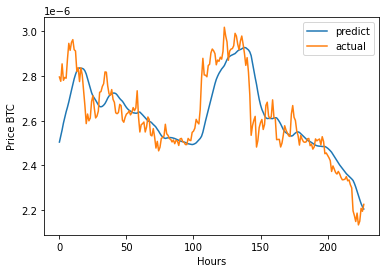

In [793]:
plt.plot(scaler.inverse_transform(scaler2.inverse_transform([[x,0,0] for x in predicted]))[:,0], label='predict')
plt.plot(scaler.inverse_transform(scaler2.inverse_transform([[x,0,0] for x in y_test]))[:, 0], label='actual')
plt.xlabel('Hours')
plt.ylabel('Price BTC')
plt.legend()

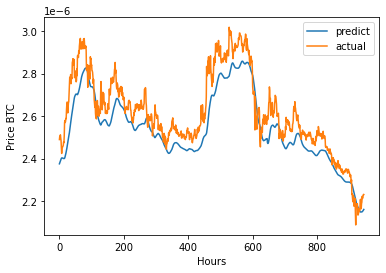

In [807]:
plt.plot(scaler.inverse_transform(scaler2.inverse_transform([[x,0,0] for x in predicted]))[:,0], label='predict')
plt.plot(scaler.inverse_transform(scaler2.inverse_transform([[x,0,0] for x in y_test]))[:, 0], label='actual')
plt.xlabel('Hours')
plt.ylabel('Price BTC')
plt.legend()

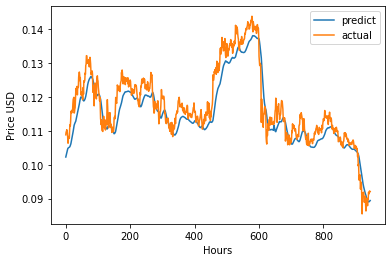

In [815]:
plt.plot(scaler.inverse_transform(scaler2.inverse_transform([[x,0,0] for x in predicted]))[:,0], label='predict')
plt.plot(scaler.inverse_transform(scaler2.inverse_transform([[x,0,0] for x in y_test]))[:, 0], label='actual')
plt.xlabel('Hours')
plt.ylabel('Price USD')
plt.legend()

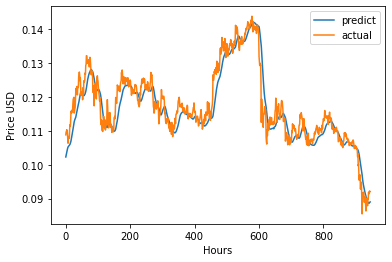

In [851]:
plt.plot(scaler.inverse_transform(scaler2.inverse_transform([[x,0,0] for x in predicted]))[:,0], label='predict')
plt.plot(scaler.inverse_transform(scaler2.inverse_transform([[x,0,0] for x in y_test]))[:, 0], label='actual')
plt.xlabel('Hours')
plt.ylabel('Price USD')
plt.legend()

In [834]:
predicted.shape

(263934,)

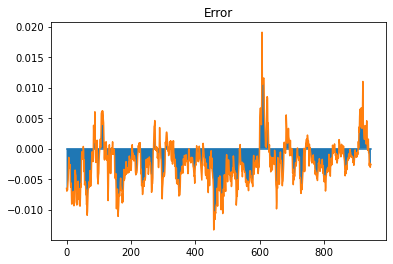

In [827]:
plt.title('Error')
error = scaler.inverse_transform(scaler2.inverse_transform([[x,0,0] for x in predicted]))[:,0] - scaler.inverse_transform(scaler2.inverse_transform([[x,0,0] for x in y_test]))[:, 0]
plt.plot(np.arange(len(error)), [0] * len(error))
plt.plot(error)
plt.fill_between(np.arange(len(error)), [0] * len(error), error)

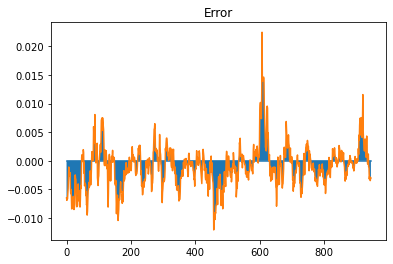

In [859]:
plt.title('Error')
error = scaler.inverse_transform(scaler2.inverse_transform([[x,0,0] for x in predicted]))[:,0] - scaler.inverse_transform(scaler2.inverse_transform([[x,0,0] for x in y_test]))[:, 0]
plt.plot(np.arange(len(error)), [0] * len(error))
plt.plot(error)
plt.fill_between(np.arange(len(error)), [0] * len(error), error)

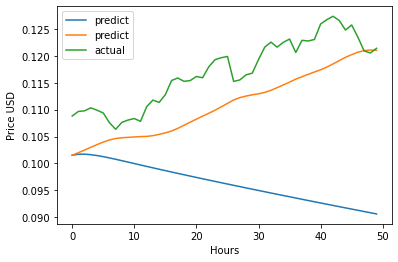

In [931]:
plt.plot(scaler.inverse_transform(scaler2.inverse_transform([[x,0,0] for x in np.array(a[-946:])]))[:50,0], label='predict')
plt.plot(scaler.inverse_transform(scaler2.inverse_transform([[x,0,0] for x in predicted]))[:50,0], label='predict')
plt.plot(scaler.inverse_transform(scaler2.inverse_transform([[x,0,0] for x in y_test]))[:50, 0], label='actual')
plt.xlabel('Hours')
plt.ylabel('Price USD')
plt.legend()

In [926]:
np.array(a[-946:]).shape

(946,)

In [821]:
np.arange(12)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])

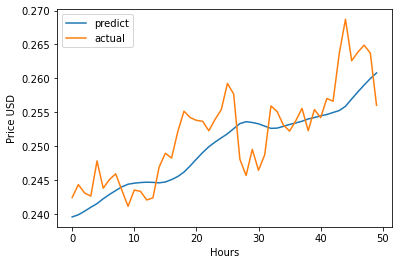

In [958]:
#plt.plot(scaler.inverse_transform(scaler2.inverse_transform([[x,0,0] for x in np.array(a[-946:])]))[:,0], label='predict')
plt.plot(scaler.inverse_transform(scaler2.inverse_transform([[x,0,0] for x in predicted2]))[:50,0], label='predict')
plt.plot(scaler.inverse_transform(scaler2.inverse_transform([[x,0,0] for x in y_test]))[:50, 0], label='actual')
plt.xlabel('Hours')
plt.ylabel('Price USD')
plt.legend()

In [765]:
y_test

array([0.58374982, 0.57916409, 0.59779362, 0.58023887, 0.58329603,
       0.5824362 , 0.60288091, 0.61971914, 0.61224345, 0.62077004,
       0.62368388, 0.61295997, 0.61155081, 0.58964917, 0.59373334,
       0.57887748, 0.59361392, 0.58613822, 0.56996875, 0.55339324,
       0.53395165, 0.5441979 , 0.53693716, 0.53992266, 0.55766848,
       0.56378279, 0.55067046, 0.54001819, 0.54197668, 0.54720728,
       0.56746093, 0.56815356, 0.573623  , 0.57663239, 0.58919538,
       0.58888488, 0.57441117, 0.56574128, 0.56433212, 0.57032701,
       0.55988969, 0.55664147, 0.54551152, 0.54455616, 0.54577424,
       0.55451579, 0.5531544 , 0.53755814, 0.53543246, 0.54061529,
       0.54417401, 0.54522491, 0.54758943, 0.54331419, 0.54565482,
       0.55105261, 0.54785215, 0.55069435, 0.56903727, 0.54099744,
       0.52499515, 0.53280522, 0.53385612, 0.53564742, 0.52501903,
       0.5304407 , 0.54104521, 0.53829855, 0.52177081, 0.52083933,
       0.52862552, 0.5196929 , 0.50782254, 0.51496386, 0.50486

In [956]:
len(a)

838

We employ the Box-Jenkins methodology of time series analysis. 

#### 1. Condition data and select a model

Let us analyse the time series by plotting the raw **Price USD** data (in log scale because the difference in price range of cryptocurrencies are quite large). A clear upward trend, cyclical variation, and some irregularities (sudden surge of price) can be observed. Seasonal variation does not seem to be present. As there is a trend, the time series is not stationary.

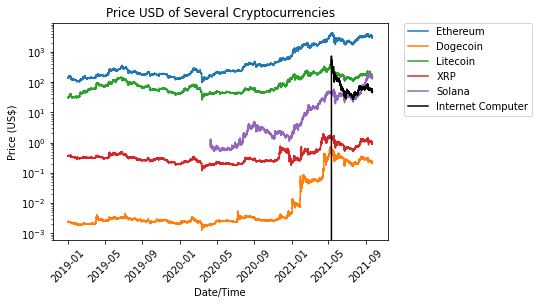

In [5]:
import matplotlib.pyplot as plt

index = 'Price USD'

eth = df[df['Currency']=='Ethereum']
plt.plot(eth['DateTime'], eth[index], label='Ethereum')

vec = df[df['Currency']=='Dogecoin']
plt.plot(vec['DateTime'], vec[index], label='Dogecoin')

btc = df[df['Currency']=='Litecoin']
plt.plot(btc['DateTime'], btc[index], label='Litecoin')

xrp = df[df['Currency']=='XRP']
plt.plot(xrp['DateTime'], xrp[index], label='XRP')

sol = df[df['Currency']=='Solana']
plt.plot(sol['DateTime'], sol[index], label='Solana')

ico = df[df['Currency']=='Internet Computer']
plt.plot(ico['DateTime'], ico[index], 'k-', label='Internet Computer')

plt.title(f'{index} of Several Cryptocurrencies')
plt.xlabel('Date/Time')
plt.ylabel('Price (US$)')
plt.xticks(rotation=45)
plt.yscale('log')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

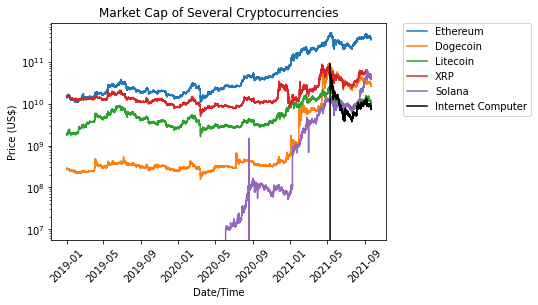

In [7]:
import matplotlib.pyplot as plt

index = 'Market Cap'

eth = df[df['Currency']=='Ethereum']
plt.plot(eth['DateTime'], eth[index], label='Ethereum')

vec = df[df['Currency']=='Dogecoin']
plt.plot(vec['DateTime'], vec[index], label='Dogecoin')

btc = df[df['Currency']=='Litecoin']
plt.plot(btc['DateTime'], btc[index], label='Litecoin')

xrp = df[df['Currency']=='XRP']
plt.plot(xrp['DateTime'], xrp[index], label='XRP')

sol = df[df['Currency']=='Solana']
plt.plot(sol['DateTime'], sol[index], label='Solana')

ico = df[df['Currency']=='Internet Computer']
plt.plot(ico['DateTime'], ico[index], 'k-', label='Internet Computer')

plt.title(f'{index} of Several Cryptocurrencies')
plt.xlabel('Date/Time')
plt.ylabel('Price (US$)')
plt.xticks(rotation=45)
plt.yscale('log')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

#### Examine remaining time series to determine a model

Therefore, to make the series stationary, we have to apply ARIMA techniques. Below we will try and compare different autoregression (AR), integration (I), and moving average (MA) values.

The usual plot does not provide insight into the cov and its structure. A autocorrelation function (ACF) plot will do better in this.

Because the $cov(0)$ is the variance, the ACF is analogous to the correlation function of two variables, $corr(y_t, y_t+h)$, and the value of the ACF falls between -1 and 1.
Thus, the closer the absolute value of $ACF(h)$ is to 1,the more useful $y_t$ can be as a predictor of $y_t+h$.

In [6]:
import matplotlib.pyplot as plt
from pandas.plotting import autocorrelation_plot

help(autocorrelation_plot)

Help on function autocorrelation_plot in module pandas.plotting._misc:

autocorrelation_plot(series, ax=None, **kwargs)
    Autocorrelation plot for time series.
    
    Parameters
    ----------
    series : Time series
    ax : Matplotlib axis object, optional
    **kwargs
        Options to pass to matplotlib plotting method.
    
    Returns
    -------
    class:`matplotlib.axis.Axes`
    
    Examples
    --------
    
    The horizontal lines in the plot correspond to 95% and 99% confidence bands.
    
    The dashed line is 99% confidence band.
    
    .. plot::
        :context: close-figs
    
        >>> spacing = np.linspace(-9 * np.pi, 9 * np.pi, num=1000)
        >>> s = pd.Series(0.7 * np.random.rand(1000) + 0.3 * np.sin(spacing))
        >>> pd.plotting.autocorrelation_plot(s)



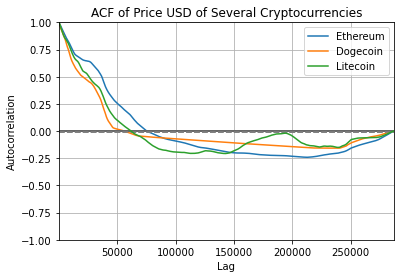

In [8]:
import matplotlib.pyplot as plt
from pandas.plotting import autocorrelation_plot

index = 'Price USD'

eth = df[df['Currency']=='Ethereum']
autocorrelation_plot(eth[index], label='Ethereum')

vec = df[df['Currency']=='Dogecoin']
autocorrelation_plot(vec[index], label='Dogecoin')

btc = df[df['Currency']=='Litecoin']
autocorrelation_plot(btc[index], label='Litecoin')

# xrp = df[df['Currency']=='XRP']
# autocorrelation_plot(xrp[index], label='XRP')

# sol = df[df['Currency']=='Solana']
# autocorrelation_plot(sol[index], label='Solana')

# ico = df[df['Currency']=='Internet Computer']
# autocorrelation_plot(ico[index], 'k-', label='Internet Computer')

plt.title(f'ACF of {index} of Several Cryptocurrencies')
# plt.xticks(rotation=45)
# plt.yscale('log')
plt.legend()

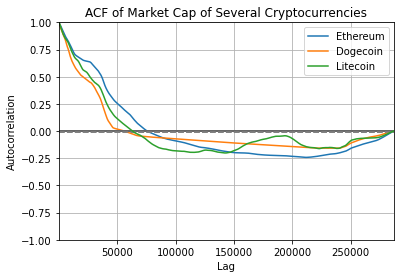

In [3]:
import matplotlib.pyplot as plt
from pandas.plotting import autocorrelation_plot

index = 'Market Cap'

eth = df[df['Currency']=='Ethereum']
autocorrelation_plot(eth[index], label='Ethereum')

vec = df[df['Currency']=='Dogecoin']
autocorrelation_plot(vec[index], label='Dogecoin')

btc = df[df['Currency']=='Litecoin']
autocorrelation_plot(btc[index], label='Litecoin')

# xrp = df[df['Currency']=='XRP']
# autocorrelation_plot(xrp[index], label='XRP')

# sol = df[df['Currency']=='Solana']
# autocorrelation_plot(sol[index], label='Solana')

# ico = df[df['Currency']=='Internet Computer']
# autocorrelation_plot(ico[index], 'k-', label='Internet Computer')

plt.title(f'ACF of {index} of Several Cryptocurrencies')
# plt.xticks(rotation=45)
# plt.yscale('log')
plt.legend()

The `pmdarima` package provides the function `auto_arima()`.

`auto_arima()` uses a stepwise approach to search multiple combinations of p,d,q parameters and picks the best model that has the smallest AIC. (Ref: [https://www.machinelearningplus.com/time-series/arima-model-time-series-forecasting-python/](https://www.machinelearningplus.com/time-series/arima-model-time-series-forecasting-python/))

In [5]:
from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm

help(pm.auto_arima)

Help on function auto_arima in module pmdarima.arima.auto:

auto_arima(y, X=None, start_p=2, d=None, start_q=2, max_p=5, max_d=2, max_q=5, start_P=1, D=None, start_Q=1, max_P=2, max_D=1, max_Q=2, max_order=5, m=1, seasonal=True, stationary=False, information_criterion='aic', alpha=0.05, test='kpss', seasonal_test='ocsb', stepwise=True, n_jobs=1, start_params=None, trend=None, method='lbfgs', maxiter=50, offset_test_args=None, seasonal_test_args=None, suppress_warnings=True, error_action='trace', trace=False, random=False, random_state=None, n_fits=10, return_valid_fits=False, out_of_sample_size=0, scoring='mse', scoring_args=None, with_intercept='auto', sarimax_kwargs=None, **fit_args)
    Automatically discover the optimal order for an ARIMA model.
    
    The auto-ARIMA process seeks to identify the most optimal
    parameters for an ``ARIMA`` model, settling on a single fitted ARIMA model.
    This process is based on the commonly-used R function,
    ``forecast::auto.arima`` [3].


In [12]:
variable = 'Price USD'

model = pm.auto_arima(df[df['Currency']=='Ethereum'][variable],
                      start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # no seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1691067.438, Time=38.42 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1691070.447, Time=9.49 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1691066.131, Time=12.62 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1691066.215, Time=22.38 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1691069.846, Time=4.44 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=1691055.075, Time=15.94 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=1691051.783, Time=19.85 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=1691053.820, Time=54.42 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1691067.732, Time=56.40 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=1691051.164, Time=10.94 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=1691054.468, Time=8.04 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=1691053.201, Time=26.03 sec


MemoryError: Unable to allocate 19.7 MiB for an array with shape (3, 3, 286846) and data type float64

In [6]:
variable = 'Market Cap'

model = pm.auto_arima(df[df['Currency']=='Ethereum'][variable],
                      start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of serieshttp://localhost:8888/notebooks/notebook.ipynb#
                      d=None,           # let model determine 'd'
                      seasonal=False,   # no seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=12344137.129, Time=28.91 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=12344142.919, Time=7.79 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=12344136.948, Time=17.86 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=12344137.054, Time=23.43 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=12344142.372, Time=6.21 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=12344126.041, Time=23.20 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=12344122.942, Time=31.36 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=12344124.980, Time=57.17 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=12344143.176, Time=39.48 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=12344122.377, Time=26.47 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=12344125.489, Time=19.00 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=12344124.416, Time=29.41 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=12344138.503, Time=33.63 sec

Best model:  ARIMA(3,1,0)(0,0,0)[0]

#### 2. Estimate the model parameters.
#### 3. Assess the model, return to Step 1 if necessary